In [1]:
import random
import threading
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from parameters import *
from utils import next_train, initialization, get_next_starting_Time, get_ActiveSchedule, get_df_ofPassengers, arrival_time

sa_neighbors=3
T=0  # 轻微跳跃
cooling_rate=0.95

In [2]:
df=pd.read_csv('../shenzhen_data/morning_longtime_100000(processed).csv')
df.drop_duplicates(inplace=True)
print(df.shape, df.columns)
df.sort_values(by=['time'], inplace=True)
df['time']=df['time']+2*int(stations_N*2*(skipped_saved+station_interval)) # 提前一定时间开始运营地铁，发出的第一台车跑完一圈就开始接待高峰期乘客
print(passenger_max)
df.head(2)

(10000, 7) Index(['start', 'end', 'time', 'id', 'forward', 'start_', 'end_'], dtype='object')
75


,start,end,time,id,forward,start_,end_
4936,23,13,270,94603,0,26,36
9127,2,17,270,13973,1,2,17


In [3]:
# initialization 后的StartTrain_time是上一台已经发车的列车的时间，故在while里面要新建
# df_schedule, StartTrain_time=initialization()

# while StartTrain_time<final_time:
#     StartTrain_time=get_next_starting_Time(get_ActiveSchedule(df_schedule, StartTrain_time)) 
#     temp_schedule=next_train(stop_stations=list(np.ones(stations_N*2).astype(int)), StartTrain_time=StartTrain_time)
#     df_schedule=pd.concat([df_schedule, temp_schedule])
# df_schedule.reset_index(drop=True, inplace=True)
# df_schedule
df_schedule=pd.read_csv('../result/df_schedule_al3.csv')
print(df_schedule.shape, df_schedule.columns)
df_schedule.head(5)

(120, 101) Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '41_stop', '42_stop', '43_stop', '44_stop', '45_stop', '46_stop',
       '47_stop', '48_stop', '49_stop', 'restart_time'],
      dtype='object', length=101)


,0,1,2,3,4,5,6,7,8,9,...,41_stop,42_stop,43_stop,44_stop,45_stop,46_stop,47_stop,48_stop,49_stop,restart_time
0,0.0,2.7,5.4,8.1,10.8,13.5,16.2,18.9,21.6,24.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,135.0
1,5.0,7.7,10.4,13.1,15.8,18.5,21.2,23.9,26.6,29.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,140.0
2,10.0,12.7,15.4,18.1,20.8,23.5,26.2,28.9,31.6,34.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,145.0
3,15.0,17.7,20.4,23.1,25.8,28.5,31.2,33.9,36.6,39.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,150.0
4,20.0,22.7,25.4,28.1,30.8,33.5,36.2,38.9,41.6,44.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,155.0


In [4]:
def new_neighbor_schedule(df_schedule,sa_neighbors=sa_neighbors):
    random_indices = [(random.randint(train_N, len(df_schedule)-2), random.choice(column_names_with_stop)) for _ in range(sa_neighbors)] #数据去头去尾
    for index, col in random_indices:
        df_schedule.at[index, col] = random.choice([0, 1])
    df_schedule_temp, StartTrain_time=initialization()
    init_n=len(df_schedule_temp)
    assert train_N==init_n
    for i in range(train_N, len(df_schedule)):
        StartTrain_time=get_next_starting_Time(get_ActiveSchedule(df_schedule_temp, StartTrain_time)) 
        temp_schedule=next_train(stop_stations=list(df_schedule[column_names_with_stop].iloc[i]), 
                                StartTrain_time=StartTrain_time)
        df_schedule_temp=pd.concat([df_schedule_temp, temp_schedule])
    df_schedule_temp.reset_index(drop=True, inplace=True)
    df_schedule=df_schedule_temp.copy()

    return df_schedule

def heat_func(delta, T):
    if delta<=0:
        return 1
    else:
        return np.e**(-delta/T)        
    

In [5]:
###
print(new_neighbor_schedule(df_schedule.copy(),3).sum().sum())
df_schedule.sum().sum()


2239410.5999999964


2239799.9999999967

In [6]:
def calculating_waiting_time_for_SA(df_schedule, df,result_t=None, result_df=None):
    waiting_time=0
    waiting_time_list=[]
    station_interval_list=[]
    df_changing=df.copy()
    df_schedule_temp=pd.DataFrame()
    for i in range(df_schedule.shape[0]):
        temp_schedule=df_schedule.iloc[[i]]
        stop_stations=temp_schedule.T.reset_index()[stations_N*2:stations_N*4][i].values
        df_schedule_temp=pd.concat([df_schedule_temp, temp_schedule])
        df_drop, _=get_df_ofPassengers(next_schedule_Ref=temp_schedule, stop_stations=stop_stations.copy(), df_changing=df_changing.copy()) # 新车把旧车接走了
        if len(df_drop)!=0:
            waiting_time_list.append(df_drop.apply(lambda row: arrival_time(row['start_'], row['end_'], row['time'],df_schedule=temp_schedule)[1], axis=1))
            waiting_time+=waiting_time_list[-1].sum()
            station_interval_list.append(list(df_drop['end_']-df_drop['start_']))

        df_changing=pd.merge(df_changing, df_drop, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
        # print("stop_stations:", stop_stations)

    #
    while df_changing.shape[0]>0:
        print('a new shcedule is generated')
        stop_stations=list(np.ones(stations_N*2).astype(int))
        StartTrain_time=df_schedule_temp['restart_time'].iloc[-train_N:].min()  # 已经在运行列车最早回来的值
        temp_schedule=next_train(stop_stations=stop_stations, StartTrain_time=StartTrain_time)
        df_schedule_temp=pd.concat([df_schedule_temp, temp_schedule])
        df_schedule_temp.reset_index(drop=True, inplace=True)
        df_drop, _=get_df_ofPassengers(next_schedule_Ref=temp_schedule, stop_stations=stop_stations.copy(), df_changing=df_changing.copy()) # 新车把旧车接走了
        if len(df_drop)!=0:
            waiting_time_list.append(df_drop.apply(lambda row: arrival_time(row['start_'], row['end_'], row['time'],df_schedule=temp_schedule)[1], axis=1))
            waiting_time+=waiting_time_list[-1].sum()
            station_interval_list.append(list(df_drop['end_']-df_drop['start_']))

        df_changing=pd.merge(df_changing, df_drop, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
#         print("stop_stations:", stop_stations)
        
    df_schedule_temp.reset_index(drop=True, inplace=True)
    if result_t!=None:
        result_t.append(waiting_time)
        result_df.append(df_schedule)
    return waiting_time, df_schedule_temp

In [7]:
costTime_best, df_schedule=calculating_waiting_time_for_SA(df_schedule=df_schedule.copy(), df=df.copy())
df_schedule=df_schedule
ref_time=costTime_best
result=[]
for i in tqdm(range(3000)):
    df_schedule_temp=new_neighbor_schedule(df_schedule.copy())
    costTime_temp,df_schedule_temp = calculating_waiting_time_for_SA(df_schedule=df_schedule_temp.copy(), df=df.copy())
    delta=costTime_best-costTime_temp
    print(df_schedule.shape[0], df_schedule_temp.shape[0])
    if delta>0:
        costTime_best=costTime_temp
        df_schedule=df_schedule_temp.copy()
    else:
        pass
    result.append(costTime_temp)
    print('original_time:', ref_time, 'optimization_time:', costTime_temp)

  0%|          | 1/3000 [00:26<21:59:56, 26.41s/it]

120 120
original_time: 294113.4999999889 optimization_time: 294013.4999999888


  0%|          | 2/3000 [00:52<21:50:10, 26.22s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293946.09999998886


  0%|          | 3/3000 [01:19<22:02:02, 26.47s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293883.89999998885


  0%|          | 4/3000 [01:46<22:07:54, 26.59s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293848.4999999889


  0%|          | 5/3000 [02:12<22:06:37, 26.58s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293715.89999998885


  0%|          | 6/3000 [02:39<22:06:17, 26.58s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293444.2999999889


  0%|          | 7/3000 [03:06<22:10:43, 26.68s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293440.49999998894


  0%|          | 8/3000 [03:32<22:05:12, 26.58s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293440.49999998894


  0%|          | 9/3000 [03:58<21:56:09, 26.40s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293368.49999998894


  0%|          | 10/3000 [04:24<21:50:52, 26.31s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293176.8999999891


  0%|          | 11/3000 [04:51<21:53:12, 26.36s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293524.0999999891


  0%|          | 12/3000 [05:17<21:57:58, 26.47s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293176.8999999891


  0%|          | 13/3000 [05:44<22:08:44, 26.69s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293032.89999998914


  0%|          | 14/3000 [06:11<22:12:16, 26.77s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293036.6999999891


  0%|          | 15/3000 [06:38<22:07:37, 26.69s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292827.499999989


  1%|          | 16/3000 [07:04<22:03:15, 26.61s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292813.0999999891


  1%|          | 17/3000 [07:31<22:00:05, 26.55s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292563.2999999891


  1%|          | 18/3000 [07:57<22:01:25, 26.59s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292579.6999999891


  1%|          | 19/3000 [08:24<21:59:38, 26.56s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292542.49999998906


  1%|          | 20/3000 [08:50<21:56:18, 26.50s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292542.49999998906


  1%|          | 21/3000 [09:17<21:59:18, 26.57s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292542.49999998906


  1%|          | 22/3000 [09:44<21:58:51, 26.57s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292782.299999989


  1%|          | 23/3000 [10:10<22:01:06, 26.63s/it]

120 120
original_time: 294113.4999999889 optimization_time: 293024.09999998903


  1%|          | 24/3000 [10:37<22:02:52, 26.67s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292521.09999998903


  1%|          | 25/3000 [11:03<21:53:33, 26.49s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292493.69999998895


  1%|          | 26/3000 [11:29<21:50:12, 26.43s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292354.4999999888


  1%|          | 27/3000 [11:56<21:49:01, 26.42s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292401.09999998886


  1%|          | 28/3000 [12:23<21:55:54, 26.57s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292604.69999998884


  1%|          | 29/3000 [12:49<21:55:47, 26.57s/it]

120 120
original_time: 294113.4999999889 optimization_time: 292271.69999998884


  1%|          | 30/3000 [13:16<21:54:27, 26.55s/it]

120 120
original_time: 294113.4999999889 optimization_time: 295115.69999998895


  1%|          | 31/3000 [13:42<21:50:57, 26.49s/it]

120 120
original_time: 294113.4999999889 optimization_time: 291697.09999998886


  1%|          | 32/3000 [14:09<21:49:06, 26.46s/it]

120 120
original_time: 294113.4999999889 optimization_time: 291476.09999998886


  1%|          | 33/3000 [14:35<21:54:11, 26.58s/it]

120 120
original_time: 294113.4999999889 optimization_time: 291183.0999999888


  1%|          | 34/3000 [15:02<22:00:39, 26.72s/it]

120 120
original_time: 294113.4999999889 optimization_time: 291088.4999999888


  1%|          | 35/3000 [15:26<21:14:13, 25.79s/it]

120 120
original_time: 294113.4999999889 optimization_time: 291171.4999999889


  1%|          | 36/3000 [15:53<21:23:17, 25.98s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290932.09999998886


  1%|          | 37/3000 [16:20<21:38:56, 26.30s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290932.09999998886


  1%|▏         | 38/3000 [16:46<21:47:03, 26.48s/it]

120 120
original_time: 294113.4999999889 optimization_time: 291105.2999999889


  1%|▏         | 39/3000 [17:13<21:47:28, 26.49s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290819.4999999889


  1%|▏         | 40/3000 [17:40<21:47:53, 26.51s/it]

120 120
original_time: 294113.4999999889 optimization_time: 291429.09999998886


  1%|▏         | 41/3000 [18:06<21:48:28, 26.53s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290819.4999999889


  1%|▏         | 42/3000 [18:30<21:02:58, 25.62s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290595.69999998884


  1%|▏         | 43/3000 [18:54<20:39:37, 25.15s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290854.0999999889


  1%|▏         | 44/3000 [19:18<20:25:41, 24.88s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290629.29999998887


  2%|▏         | 45/3000 [19:43<20:22:34, 24.82s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290523.29999998887


  2%|▏         | 46/3000 [20:07<20:12:16, 24.62s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290459.8999999889


  2%|▏         | 47/3000 [20:31<20:01:31, 24.41s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290459.8999999889


  2%|▏         | 48/3000 [20:55<19:53:23, 24.26s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290447.69999998895


  2%|▏         | 49/3000 [21:19<19:51:48, 24.23s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290281.299999989


  2%|▏         | 50/3000 [21:43<19:45:53, 24.12s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290116.499999989


  2%|▏         | 51/3000 [22:06<19:37:22, 23.95s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290116.499999989


  2%|▏         | 52/3000 [22:30<19:34:18, 23.90s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290683.69999998895


  2%|▏         | 53/3000 [22:54<19:29:39, 23.81s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290399.69999998895


  2%|▏         | 54/3000 [23:17<19:25:21, 23.73s/it]

120 120
original_time: 294113.4999999889 optimization_time: 289873.49999998906


  2%|▏         | 55/3000 [23:39<18:59:11, 23.21s/it]

120 120
original_time: 294113.4999999889 optimization_time: 290105.099999989


  2%|▏         | 56/3000 [24:03<19:10:27, 23.45s/it]

120 120
original_time: 294113.4999999889 optimization_time: 289861.8999999889


  2%|▏         | 57/3000 [24:27<19:18:12, 23.61s/it]

120 120
original_time: 294113.4999999889 optimization_time: 289857.29999998887


  2%|▏         | 58/3000 [24:52<19:34:26, 23.95s/it]

120 120
original_time: 294113.4999999889 optimization_time: 289390.49999998894


  2%|▏         | 59/3000 [25:16<19:42:56, 24.13s/it]

120 120
original_time: 294113.4999999889 optimization_time: 289254.499999989


  2%|▏         | 60/3000 [25:41<19:46:08, 24.21s/it]

120 120
original_time: 294113.4999999889 optimization_time: 289219.89999998914


  2%|▏         | 61/3000 [26:05<19:48:54, 24.27s/it]

120 120
original_time: 294113.4999999889 optimization_time: 289179.8999999891


  2%|▏         | 62/3000 [26:29<19:47:10, 24.24s/it]

120 120
original_time: 294113.4999999889 optimization_time: 289159.89999998896


  2%|▏         | 63/3000 [26:54<19:47:35, 24.26s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288987.099999989


  2%|▏         | 64/3000 [27:18<19:51:17, 24.35s/it]

120 120
original_time: 294113.4999999889 optimization_time: 289115.89999998896


  2%|▏         | 65/3000 [27:42<19:49:41, 24.32s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288865.49999998894


  2%|▏         | 66/3000 [28:07<19:47:54, 24.29s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288882.89999998885


  2%|▏         | 67/3000 [28:31<19:48:51, 24.32s/it]

120 120
original_time: 294113.4999999889 optimization_time: 289453.2999999889


  2%|▏         | 68/3000 [28:56<19:52:05, 24.39s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288784.0999999889


  2%|▏         | 69/3000 [29:20<19:50:54, 24.38s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288748.6999999889


  2%|▏         | 70/3000 [29:44<19:48:11, 24.33s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288809.69999998895


  2%|▏         | 71/3000 [30:09<19:49:22, 24.36s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288757.499999989


  2%|▏         | 72/3000 [30:33<19:46:33, 24.31s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288771.8999999889


  2%|▏         | 73/3000 [30:57<19:44:39, 24.28s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288922.49999998894


  2%|▏         | 74/3000 [31:21<19:39:46, 24.19s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288814.0999999889


  2%|▎         | 75/3000 [31:46<19:43:05, 24.27s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288731.29999998887


  3%|▎         | 76/3000 [32:10<19:44:30, 24.31s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288911.8999999889


  3%|▎         | 77/3000 [32:34<19:44:04, 24.31s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288700.8999999889


  3%|▎         | 78/3000 [32:58<19:41:54, 24.27s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288702.4999999889


  3%|▎         | 79/3000 [33:23<19:41:02, 24.26s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288700.8999999889


  3%|▎         | 80/3000 [33:47<19:40:43, 24.26s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288698.4999999889


  3%|▎         | 81/3000 [34:11<19:37:55, 24.21s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288747.4999999889


  3%|▎         | 82/3000 [34:35<19:36:54, 24.20s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288698.4999999889


  3%|▎         | 83/3000 [34:59<19:36:47, 24.21s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288727.69999998895


  3%|▎         | 84/3000 [35:24<19:39:11, 24.26s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288984.4999999889


  3%|▎         | 85/3000 [35:48<19:35:59, 24.21s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288734.49999998894


  3%|▎         | 86/3000 [36:12<19:33:32, 24.16s/it]

120 120
original_time: 294113.4999999889 optimization_time: 289153.69999998895


  3%|▎         | 87/3000 [36:36<19:28:57, 24.08s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288720.4999999889


  3%|▎         | 88/3000 [37:00<19:27:57, 24.07s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288698.4999999889


  3%|▎         | 89/3000 [37:24<19:30:24, 24.12s/it]

120 120
original_time: 294113.4999999889 optimization_time: 289032.0999999889


  3%|▎         | 90/3000 [37:48<19:32:35, 24.18s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288597.699999989


  3%|▎         | 91/3000 [38:13<19:36:18, 24.26s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288441.6999999891


  3%|▎         | 92/3000 [38:37<19:35:28, 24.25s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288407.89999998914


  3%|▎         | 93/3000 [39:01<19:32:19, 24.20s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288409.4999999891


  3%|▎         | 94/3000 [39:25<19:30:21, 24.16s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288237.6999999891


  3%|▎         | 95/3000 [39:49<19:26:27, 24.09s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288566.899999989


  3%|▎         | 96/3000 [40:13<19:27:41, 24.13s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288590.49999998906


  3%|▎         | 97/3000 [40:38<19:31:06, 24.20s/it]

120 120
original_time: 294113.4999999889 optimization_time: 288219.69999998924


  3%|▎         | 98/3000 [41:02<19:29:36, 24.18s/it]

120 120
original_time: 294113.4999999889 optimization_time: 287862.8999999892


  3%|▎         | 99/3000 [41:26<19:25:33, 24.11s/it]

120 120
original_time: 294113.4999999889 optimization_time: 287704.4999999891


  3%|▎         | 100/3000 [41:50<19:22:03, 24.04s/it]

120 120
original_time: 294113.4999999889 optimization_time: 287883.09999998903


  3%|▎         | 101/3000 [42:14<19:24:48, 24.11s/it]

120 120
original_time: 294113.4999999889 optimization_time: 287347.6999999891


  3%|▎         | 102/3000 [42:38<19:25:49, 24.14s/it]

120 120
original_time: 294113.4999999889 optimization_time: 287374.2999999891


  3%|▎         | 103/3000 [43:02<19:27:24, 24.18s/it]

120 120
original_time: 294113.4999999889 optimization_time: 287444.299999989


  3%|▎         | 104/3000 [43:27<19:29:16, 24.23s/it]

120 120
original_time: 294113.4999999889 optimization_time: 287288.6999999891


  4%|▎         | 105/3000 [43:51<19:27:29, 24.20s/it]

120 120
original_time: 294113.4999999889 optimization_time: 287156.89999998914


  4%|▎         | 106/3000 [44:15<19:26:23, 24.18s/it]

120 120
original_time: 294113.4999999889 optimization_time: 287114.2999999891


  4%|▎         | 107/3000 [44:39<19:21:32, 24.09s/it]

120 120
original_time: 294113.4999999889 optimization_time: 286972.89999998914


  4%|▎         | 108/3000 [45:03<19:17:08, 24.01s/it]

120 120
original_time: 294113.4999999889 optimization_time: 286972.89999998914


  4%|▎         | 109/3000 [45:27<19:17:20, 24.02s/it]

120 120
original_time: 294113.4999999889 optimization_time: 286874.8999999892


  4%|▎         | 110/3000 [45:51<19:18:03, 24.04s/it]

120 120
original_time: 294113.4999999889 optimization_time: 286871.29999998916


  4%|▎         | 111/3000 [46:15<19:22:32, 24.14s/it]

120 120
original_time: 294113.4999999889 optimization_time: 286871.29999998916


  4%|▎         | 112/3000 [46:39<19:20:18, 24.11s/it]

120 120
original_time: 294113.4999999889 optimization_time: 286904.6999999891


  4%|▍         | 113/3000 [47:04<19:22:01, 24.15s/it]

120 120
original_time: 294113.4999999889 optimization_time: 286784.0999999891


  4%|▍         | 114/3000 [47:28<19:31:09, 24.35s/it]

120 120
original_time: 294113.4999999889 optimization_time: 286668.4999999892


  4%|▍         | 115/3000 [47:53<19:30:45, 24.35s/it]

120 120
original_time: 294113.4999999889 optimization_time: 286796.89999998914


  4%|▍         | 116/3000 [48:17<19:32:28, 24.39s/it]

120 120
original_time: 294113.4999999889 optimization_time: 286551.0999999892


  4%|▍         | 117/3000 [48:42<19:33:38, 24.43s/it]

120 120
original_time: 294113.4999999889 optimization_time: 286391.89999998925


  4%|▍         | 118/3000 [49:06<19:32:21, 24.41s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285991.09999998915


  4%|▍         | 119/3000 [49:31<19:32:17, 24.41s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285690.4999999892


  4%|▍         | 120/3000 [49:55<19:26:58, 24.31s/it]

120 120
original_time: 294113.4999999889 optimization_time: 287367.29999998916


  4%|▍         | 121/3000 [50:19<19:22:04, 24.22s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285690.4999999892


  4%|▍         | 122/3000 [50:42<19:16:57, 24.12s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285684.09999998915


  4%|▍         | 123/3000 [51:06<19:14:06, 24.07s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285684.09999998915


  4%|▍         | 124/3000 [51:30<19:13:43, 24.07s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285690.8999999892


  4%|▍         | 125/3000 [51:54<19:09:02, 23.98s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285722.09999998915


  4%|▍         | 126/3000 [52:18<19:07:57, 23.97s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285421.6999999891


  4%|▍         | 127/3000 [52:42<19:07:07, 23.96s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285421.6999999891


  4%|▍         | 128/3000 [53:06<19:04:35, 23.91s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285257.2999999891


  4%|▍         | 129/3000 [53:30<19:09:12, 24.02s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285283.8999999891


  4%|▍         | 130/3000 [53:54<19:11:18, 24.07s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285258.0999999892


  4%|▍         | 131/3000 [54:18<19:07:02, 23.99s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285067.2999999892


  4%|▍         | 132/3000 [54:43<19:12:30, 24.11s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285064.09999998927


  4%|▍         | 133/3000 [55:07<19:10:48, 24.08s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285064.09999998927


  4%|▍         | 134/3000 [55:31<19:08:20, 24.04s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285065.49999998923


  4%|▍         | 135/3000 [55:55<19:13:37, 24.16s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285461.4999999891


  5%|▍         | 136/3000 [56:19<19:14:34, 24.19s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285374.0999999891


  5%|▍         | 137/3000 [56:44<19:16:38, 24.24s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284700.89999998925


  5%|▍         | 138/3000 [57:08<19:18:33, 24.29s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284748.49999998906


  5%|▍         | 139/3000 [57:32<19:11:20, 24.15s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284344.49999998923


  5%|▍         | 140/3000 [57:56<19:09:55, 24.12s/it]

120 120
original_time: 294113.4999999889 optimization_time: 286388.8999999891


  5%|▍         | 141/3000 [58:20<19:09:10, 24.12s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284284.2999999892


  5%|▍         | 142/3000 [58:44<19:09:59, 24.14s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284284.2999999892


  5%|▍         | 143/3000 [59:08<19:08:24, 24.12s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284425.0999999892


  5%|▍         | 144/3000 [59:32<19:05:43, 24.07s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284284.2999999892


  5%|▍         | 145/3000 [59:56<19:05:09, 24.07s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284284.2999999892


  5%|▍         | 146/3000 [1:00:20<19:01:52, 24.01s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284480.49999998906


  5%|▍         | 147/3000 [1:00:44<19:03:11, 24.04s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284268.6999999892


  5%|▍         | 148/3000 [1:01:09<19:06:59, 24.13s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284541.2999999893


  5%|▍         | 149/3000 [1:01:33<19:07:36, 24.15s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284263.89999998914


  5%|▌         | 150/3000 [1:01:57<19:07:49, 24.16s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285612.4999999892


  5%|▌         | 151/3000 [1:02:21<19:05:17, 24.12s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284179.8999999892


  5%|▌         | 152/3000 [1:02:45<19:00:26, 24.03s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284146.69999998907


  5%|▌         | 153/3000 [1:03:09<18:56:34, 23.95s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283887.49999998906


  5%|▌         | 154/3000 [1:03:32<18:53:27, 23.90s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283844.0999999892


  5%|▌         | 155/3000 [1:03:56<18:55:31, 23.95s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283928.09999998915


  5%|▌         | 156/3000 [1:04:20<18:52:59, 23.90s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284038.69999998924


  5%|▌         | 157/3000 [1:04:44<18:53:07, 23.91s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283806.6999999892


  5%|▌         | 158/3000 [1:05:08<18:53:17, 23.93s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283797.699999989


  5%|▌         | 159/3000 [1:05:32<18:48:39, 23.84s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283672.29999998905


  5%|▌         | 160/3000 [1:05:55<18:47:01, 23.81s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283661.89999998896


  5%|▌         | 161/3000 [1:06:19<18:45:37, 23.79s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283554.299999989


  5%|▌         | 162/3000 [1:06:43<18:44:28, 23.77s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283549.899999989


  5%|▌         | 163/3000 [1:07:07<18:41:10, 23.71s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283270.0999999891


  5%|▌         | 164/3000 [1:07:30<18:41:25, 23.73s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283257.2999999891


  6%|▌         | 165/3000 [1:07:54<18:39:44, 23.70s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283425.0999999891


  6%|▌         | 166/3000 [1:08:16<18:17:29, 23.24s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283243.0999999891


  6%|▌         | 167/3000 [1:08:37<17:51:06, 22.68s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283129.6999999891


  6%|▌         | 168/3000 [1:08:59<17:30:29, 22.26s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283134.89999998914


  6%|▌         | 169/3000 [1:09:20<17:17:49, 22.00s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282788.2999999891


  6%|▌         | 170/3000 [1:09:41<17:07:10, 21.78s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282785.89999998914


  6%|▌         | 171/3000 [1:10:04<17:15:16, 21.96s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282744.49999998906


  6%|▌         | 172/3000 [1:10:26<17:12:03, 21.90s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282657.29999998905


  6%|▌         | 173/3000 [1:10:47<17:01:11, 21.67s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282657.29999998905


  6%|▌         | 174/3000 [1:11:08<16:56:57, 21.59s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282657.29999998905


  6%|▌         | 175/3000 [1:11:30<17:00:16, 21.67s/it]

120 120
original_time: 294113.4999999889 optimization_time: 285255.89999998914


  6%|▌         | 176/3000 [1:11:51<16:56:31, 21.60s/it]

120 120
original_time: 294113.4999999889 optimization_time: 283047.09999998915


  6%|▌         | 177/3000 [1:12:13<16:52:36, 21.52s/it]

a new shcedule is generated
120 121
original_time: 294113.4999999889 optimization_time: 282801.4999999891


  6%|▌         | 178/3000 [1:12:34<16:50:38, 21.49s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282583.299999989


  6%|▌         | 179/3000 [1:12:58<17:19:45, 22.11s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282583.299999989


  6%|▌         | 180/3000 [1:13:23<18:07:45, 23.14s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282317.09999998903


  6%|▌         | 181/3000 [1:13:48<18:34:38, 23.72s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282180.8999999891


  6%|▌         | 182/3000 [1:14:13<18:51:29, 24.09s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282114.09999998903


  6%|▌         | 183/3000 [1:14:38<18:58:53, 24.26s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281815.69999998907


  6%|▌         | 184/3000 [1:15:00<18:22:34, 23.49s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281815.69999998907


  6%|▌         | 185/3000 [1:15:21<17:59:16, 23.00s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281895.09999998915


  6%|▌         | 186/3000 [1:15:43<17:42:46, 22.66s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281815.69999998907


  6%|▌         | 187/3000 [1:16:05<17:30:59, 22.42s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281595.0999999891


  6%|▋         | 188/3000 [1:16:27<17:25:59, 22.32s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281653.29999998916


  6%|▋         | 189/3000 [1:16:49<17:21:24, 22.23s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281451.0999999891


  6%|▋         | 190/3000 [1:17:12<17:20:57, 22.23s/it]

120 120
original_time: 294113.4999999889 optimization_time: 284536.4999999891


  6%|▋         | 191/3000 [1:17:33<17:12:11, 22.05s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281711.6999999892


  6%|▋         | 192/3000 [1:17:56<17:23:07, 22.29s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281451.0999999891


  6%|▋         | 193/3000 [1:18:20<17:53:05, 22.94s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281590.0999999891


  6%|▋         | 194/3000 [1:18:45<18:15:08, 23.42s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281451.0999999891


  6%|▋         | 195/3000 [1:19:10<18:34:02, 23.83s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281255.29999998916


  7%|▋         | 196/3000 [1:19:34<18:39:49, 23.96s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281294.69999998907


  7%|▋         | 197/3000 [1:19:59<18:50:26, 24.20s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281255.29999998916


  7%|▋         | 198/3000 [1:20:24<18:59:12, 24.39s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281232.09999998915


  7%|▋         | 199/3000 [1:20:48<19:04:01, 24.51s/it]

a new shcedule is generated
120 121
original_time: 294113.4999999889 optimization_time: 281237.4999999892


  7%|▋         | 200/3000 [1:21:13<19:07:45, 24.59s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282070.0999999891


  7%|▋         | 201/3000 [1:21:38<19:09:39, 24.64s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281232.09999998915


  7%|▋         | 202/3000 [1:22:02<19:06:51, 24.59s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281516.4999999891


  7%|▋         | 203/3000 [1:22:27<19:07:55, 24.62s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281439.0999999892


  7%|▋         | 204/3000 [1:22:52<19:10:59, 24.70s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281060.8999999892


  7%|▋         | 205/3000 [1:23:16<19:06:25, 24.61s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281108.2999999892


  7%|▋         | 206/3000 [1:23:41<19:07:39, 24.65s/it]

120 120
original_time: 294113.4999999889 optimization_time: 280910.8999999892


  7%|▋         | 207/3000 [1:24:06<19:04:56, 24.60s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282236.69999998924


  7%|▋         | 208/3000 [1:24:30<19:05:34, 24.62s/it]

120 120
original_time: 294113.4999999889 optimization_time: 280824.0999999893


  7%|▋         | 209/3000 [1:24:55<19:01:52, 24.55s/it]

120 120
original_time: 294113.4999999889 optimization_time: 280824.0999999893


  7%|▋         | 210/3000 [1:25:19<19:01:08, 24.54s/it]

120 120
original_time: 294113.4999999889 optimization_time: 280380.4999999892


  7%|▋         | 211/3000 [1:25:44<19:00:39, 24.54s/it]

120 120
original_time: 294113.4999999889 optimization_time: 280266.6999999892


  7%|▋         | 212/3000 [1:26:08<18:59:31, 24.52s/it]

120 120
original_time: 294113.4999999889 optimization_time: 280767.6999999892


  7%|▋         | 213/3000 [1:26:33<19:02:44, 24.60s/it]

120 120
original_time: 294113.4999999889 optimization_time: 280263.0999999892


  7%|▋         | 214/3000 [1:26:58<19:03:41, 24.63s/it]

120 120
original_time: 294113.4999999889 optimization_time: 280299.6999999892


  7%|▋         | 215/3000 [1:27:22<19:03:42, 24.64s/it]

120 120
original_time: 294113.4999999889 optimization_time: 280114.6999999891


  7%|▋         | 216/3000 [1:27:47<19:04:05, 24.66s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281493.8999999891


  7%|▋         | 217/3000 [1:28:12<19:06:22, 24.72s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279796.8999999891


  7%|▋         | 218/3000 [1:28:37<19:04:45, 24.69s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279664.29999998916


  7%|▋         | 219/3000 [1:29:01<19:07:17, 24.75s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279621.2999999892


  7%|▋         | 220/3000 [1:29:26<19:08:52, 24.80s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279637.29999998916


  7%|▋         | 221/3000 [1:29:51<19:09:48, 24.83s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279621.2999999892


  7%|▋         | 222/3000 [1:30:15<18:49:26, 24.39s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279566.8999999892


  7%|▋         | 223/3000 [1:30:36<18:12:29, 23.60s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279594.09999998915


  7%|▋         | 224/3000 [1:30:58<17:46:40, 23.06s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279606.4999999892


  8%|▊         | 225/3000 [1:31:20<17:30:57, 22.72s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279417.2999999892


  8%|▊         | 226/3000 [1:31:42<17:19:53, 22.49s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281251.2999999892


  8%|▊         | 227/3000 [1:32:04<17:09:09, 22.27s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279521.4999999893


  8%|▊         | 228/3000 [1:32:26<17:03:52, 22.16s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279528.2999999893


  8%|▊         | 229/3000 [1:32:47<16:57:43, 22.04s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279358.2999999892


  8%|▊         | 230/3000 [1:33:09<16:53:11, 21.95s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279352.49999998923


  8%|▊         | 231/3000 [1:33:31<16:54:17, 21.98s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279259.09999998915


  8%|▊         | 232/3000 [1:33:51<16:16:10, 21.16s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279239.8999999892


  8%|▊         | 233/3000 [1:34:10<15:58:30, 20.78s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279236.09999998927


  8%|▊         | 234/3000 [1:34:32<16:14:28, 21.14s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279072.2999999892


  8%|▊         | 235/3000 [1:34:54<16:20:37, 21.28s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278879.49999998923


  8%|▊         | 236/3000 [1:35:16<16:27:02, 21.43s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278848.8999999892


  8%|▊         | 237/3000 [1:35:38<16:32:15, 21.55s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279316.69999998924


  8%|▊         | 238/3000 [1:36:00<16:39:07, 21.70s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278820.6999999892


  8%|▊         | 239/3000 [1:36:22<16:41:01, 21.75s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278820.6999999892


  8%|▊         | 240/3000 [1:36:44<16:44:17, 21.83s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278877.2999999891


  8%|▊         | 241/3000 [1:37:06<16:46:00, 21.88s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279052.8999999893


  8%|▊         | 242/3000 [1:37:27<16:46:23, 21.89s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279008.89999998925


  8%|▊         | 243/3000 [1:37:49<16:47:07, 21.92s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279042.8999999892


  8%|▊         | 244/3000 [1:38:11<16:46:55, 21.92s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278582.0999999892


  8%|▊         | 245/3000 [1:38:33<16:46:41, 21.92s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278562.2999999892


  8%|▊         | 246/3000 [1:38:55<16:43:52, 21.87s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278481.89999998925


  8%|▊         | 247/3000 [1:39:17<16:45:05, 21.91s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278481.89999998925


  8%|▊         | 248/3000 [1:39:39<16:44:05, 21.89s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278840.49999998935


  8%|▊         | 249/3000 [1:40:01<16:48:02, 21.99s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282402.6999999893


  8%|▊         | 250/3000 [1:40:23<16:42:58, 21.88s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278472.0999999892


  8%|▊         | 251/3000 [1:40:45<16:41:43, 21.86s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282609.0999999894


  8%|▊         | 252/3000 [1:41:06<16:36:19, 21.75s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278469.8999999892


  8%|▊         | 253/3000 [1:41:28<16:36:29, 21.77s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278686.6999999891


  8%|▊         | 254/3000 [1:41:50<16:35:36, 21.75s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278457.8999999892


  8%|▊         | 255/3000 [1:42:11<16:35:19, 21.76s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278456.6999999892


  9%|▊         | 256/3000 [1:42:33<16:37:41, 21.82s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278492.6999999892


  9%|▊         | 257/3000 [1:42:55<16:37:59, 21.83s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278137.09999998915


  9%|▊         | 258/3000 [1:43:17<16:36:23, 21.80s/it]

a new shcedule is generated
120 121
original_time: 294113.4999999889 optimization_time: 278142.899999989


  9%|▊         | 259/3000 [1:43:39<16:34:35, 21.77s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278045.09999998915


  9%|▊         | 260/3000 [1:44:00<16:30:16, 21.68s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279764.2999999892


  9%|▊         | 261/3000 [1:44:22<16:28:06, 21.65s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278040.8999999891


  9%|▊         | 262/3000 [1:44:43<16:28:54, 21.67s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278048.49999998906


  9%|▉         | 263/3000 [1:45:05<16:28:17, 21.67s/it]

120 120
original_time: 294113.4999999889 optimization_time: 282264.6999999892


  9%|▉         | 264/3000 [1:45:27<16:31:24, 21.74s/it]

120 120
original_time: 294113.4999999889 optimization_time: 278043.8999999891


  9%|▉         | 265/3000 [1:45:49<16:30:47, 21.74s/it]

120 120
original_time: 294113.4999999889 optimization_time: 281773.6999999891


  9%|▉         | 266/3000 [1:46:10<16:28:10, 21.69s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277967.4999999891


  9%|▉         | 267/3000 [1:46:32<16:23:12, 21.59s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277966.2999999891


  9%|▉         | 268/3000 [1:46:53<16:24:52, 21.63s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277983.69999998907


  9%|▉         | 269/3000 [1:47:15<16:26:29, 21.67s/it]

a new shcedule is generated
120 121
original_time: 294113.4999999889 optimization_time: 277992.8999999891


  9%|▉         | 270/3000 [1:47:37<16:30:45, 21.78s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277819.4999999891


  9%|▉         | 271/3000 [1:47:59<16:31:01, 21.79s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277535.29999998916


  9%|▉         | 272/3000 [1:48:21<16:29:49, 21.77s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277535.29999998916


  9%|▉         | 273/3000 [1:48:42<16:27:04, 21.72s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277476.29999998916


  9%|▉         | 274/3000 [1:49:04<16:23:27, 21.65s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277476.29999998916


  9%|▉         | 275/3000 [1:49:26<16:25:54, 21.71s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277476.29999998916


  9%|▉         | 276/3000 [1:49:47<16:22:28, 21.64s/it]

120 120
original_time: 294113.4999999889 optimization_time: 279825.4999999892


  9%|▉         | 277/3000 [1:50:09<16:23:49, 21.68s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277660.8999999891


  9%|▉         | 278/3000 [1:50:31<16:27:46, 21.77s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277483.6999999892


  9%|▉         | 279/3000 [1:50:53<16:28:39, 21.80s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277334.0999999892


  9%|▉         | 280/3000 [1:51:15<16:28:47, 21.81s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277384.6999999891


  9%|▉         | 281/3000 [1:51:36<16:26:14, 21.76s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277462.09999998915


  9%|▉         | 282/3000 [1:51:58<16:27:00, 21.79s/it]

120 120
original_time: 294113.4999999889 optimization_time: 277305.2999999892


  9%|▉         | 283/3000 [1:52:20<16:30:44, 21.88s/it]

a new shcedule is generated
120 121
original_time: 294113.4999999889 optimization_time: 277214.8999999892


  9%|▉         | 284/3000 [1:52:42<16:33:19, 21.94s/it]

121 121
original_time: 294113.4999999889 optimization_time: 277206.29999998916


 10%|▉         | 285/3000 [1:53:04<16:27:45, 21.83s/it]

121 121
original_time: 294113.4999999889 optimization_time: 279469.09999998915


 10%|▉         | 286/3000 [1:53:25<16:25:06, 21.78s/it]

121 121
original_time: 294113.4999999889 optimization_time: 277206.29999998916


 10%|▉         | 287/3000 [1:53:47<16:23:17, 21.75s/it]

121 121
original_time: 294113.4999999889 optimization_time: 281590.89999998914


 10%|▉         | 288/3000 [1:54:09<16:23:41, 21.76s/it]

121 121
original_time: 294113.4999999889 optimization_time: 277012.89999998914


 10%|▉         | 289/3000 [1:54:31<16:25:09, 21.80s/it]

121 121
original_time: 294113.4999999889 optimization_time: 277150.29999998916


 10%|▉         | 290/3000 [1:54:53<16:30:27, 21.93s/it]

121 121
original_time: 294113.4999999889 optimization_time: 280661.2999999892


 10%|▉         | 291/3000 [1:55:15<16:31:28, 21.96s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276857.2999999892


 10%|▉         | 292/3000 [1:55:37<16:29:18, 21.92s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276855.89999998914


 10%|▉         | 293/3000 [1:55:59<16:26:17, 21.86s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276659.89999998914


 10%|▉         | 294/3000 [1:56:20<16:23:05, 21.80s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276719.29999998916


 10%|▉         | 295/3000 [1:56:42<16:23:29, 21.81s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276659.89999998914


 10%|▉         | 296/3000 [1:57:04<16:19:20, 21.73s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276746.2999999891


 10%|▉         | 297/3000 [1:57:25<16:17:19, 21.69s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276679.8999999891


 10%|▉         | 298/3000 [1:57:47<16:12:46, 21.60s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276575.4999999892


 10%|▉         | 299/3000 [1:58:08<16:12:10, 21.60s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276469.89999998914


 10%|█         | 300/3000 [1:58:30<16:11:44, 21.59s/it]

121 121
original_time: 294113.4999999889 optimization_time: 278075.0999999892


 10%|█         | 301/3000 [1:58:51<16:12:28, 21.62s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276398.8999999891


 10%|█         | 302/3000 [1:59:13<16:14:53, 21.68s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276398.8999999891


 10%|█         | 303/3000 [1:59:35<16:14:36, 21.68s/it]

121 121
original_time: 294113.4999999889 optimization_time: 280082.89999998914


 10%|█         | 304/3000 [1:59:56<16:11:35, 21.62s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276414.299999989


 10%|█         | 305/3000 [2:00:18<16:07:03, 21.53s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276829.6999999892


 10%|█         | 306/3000 [2:00:39<16:06:48, 21.53s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276407.69999998907


 10%|█         | 307/3000 [2:01:01<16:11:08, 21.64s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276187.0999999891


 10%|█         | 308/3000 [2:01:23<16:14:28, 21.72s/it]

121 121
original_time: 294113.4999999889 optimization_time: 277150.69999998907


 10%|█         | 309/3000 [2:01:45<16:12:26, 21.68s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276025.8999999891


 10%|█         | 310/3000 [2:02:07<16:15:46, 21.76s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275973.4999999891


 10%|█         | 311/3000 [2:02:28<16:09:57, 21.64s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275845.09999998915


 10%|█         | 312/3000 [2:02:50<16:08:09, 21.61s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276046.6999999892


 10%|█         | 313/3000 [2:03:11<16:07:35, 21.61s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275852.4999999892


 10%|█         | 314/3000 [2:03:33<16:09:08, 21.65s/it]

121 121
original_time: 294113.4999999889 optimization_time: 280090.2999999891


 10%|█         | 315/3000 [2:03:55<16:11:47, 21.72s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275845.09999998915


 11%|█         | 316/3000 [2:04:17<16:13:29, 21.76s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276714.6999999893


 11%|█         | 317/3000 [2:04:38<16:13:03, 21.76s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275843.2999999891


 11%|█         | 318/3000 [2:05:00<16:14:42, 21.81s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275843.2999999891


 11%|█         | 319/3000 [2:05:22<16:12:25, 21.76s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275843.2999999891


 11%|█         | 320/3000 [2:05:44<16:09:50, 21.71s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275843.2999999891


 11%|█         | 321/3000 [2:06:05<16:08:35, 21.69s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276011.6999999891


 11%|█         | 322/3000 [2:06:27<16:09:55, 21.73s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275717.8999999892


 11%|█         | 323/3000 [2:06:49<16:09:42, 21.73s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275713.2999999892


 11%|█         | 324/3000 [2:07:11<16:09:45, 21.74s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275716.89999998925


 11%|█         | 325/3000 [2:07:32<16:12:02, 21.80s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275854.49999998923


 11%|█         | 326/3000 [2:07:54<16:10:27, 21.78s/it]

121 121
original_time: 294113.4999999889 optimization_time: 279845.6999999892


 11%|█         | 327/3000 [2:08:16<16:08:20, 21.74s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275713.2999999892


 11%|█         | 328/3000 [2:08:37<16:04:14, 21.65s/it]

121 121
original_time: 294113.4999999889 optimization_time: 279835.49999998923


 11%|█         | 329/3000 [2:08:59<16:05:45, 21.69s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275713.2999999892


 11%|█         | 330/3000 [2:09:21<16:05:25, 21.70s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275766.09999998927


 11%|█         | 331/3000 [2:09:43<16:16:14, 21.95s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275907.6999999892


 11%|█         | 332/3000 [2:10:06<16:22:30, 22.10s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275675.89999998914


 11%|█         | 333/3000 [2:10:28<16:27:20, 22.21s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275581.4999999891


 11%|█         | 334/3000 [2:10:50<16:20:00, 22.06s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275647.6999999892


 11%|█         | 335/3000 [2:11:12<16:16:44, 21.99s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275624.2999999891


 11%|█         | 336/3000 [2:11:33<16:11:43, 21.89s/it]

121 121
original_time: 294113.4999999889 optimization_time: 279381.2999999891


 11%|█         | 337/3000 [2:11:55<16:10:43, 21.87s/it]

a new shcedule is generated
121 122
original_time: 294113.4999999889 optimization_time: 275794.2999999891


 11%|█▏        | 338/3000 [2:12:17<16:06:20, 21.78s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275499.29999998916


 11%|█▏        | 339/3000 [2:12:39<16:10:20, 21.88s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275499.29999998916


 11%|█▏        | 340/3000 [2:13:01<16:11:03, 21.90s/it]

121 121
original_time: 294113.4999999889 optimization_time: 278800.29999998916


 11%|█▏        | 341/3000 [2:13:23<16:12:32, 21.95s/it]

121 121
original_time: 294113.4999999889 optimization_time: 277208.29999998916


 11%|█▏        | 342/3000 [2:13:44<16:05:35, 21.80s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275400.4999999892


 11%|█▏        | 343/3000 [2:14:06<15:58:49, 21.65s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275260.6999999892


 11%|█▏        | 344/3000 [2:14:27<15:57:45, 21.64s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275236.6999999892


 12%|█▏        | 345/3000 [2:14:49<15:53:42, 21.55s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275254.09999998915


 12%|█▏        | 346/3000 [2:15:11<15:57:14, 21.64s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275272.29999998916


 12%|█▏        | 347/3000 [2:15:32<15:58:45, 21.68s/it]

121 121
original_time: 294113.4999999889 optimization_time: 277332.09999998927


 12%|█▏        | 348/3000 [2:15:54<16:00:25, 21.73s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275236.6999999892


 12%|█▏        | 349/3000 [2:16:16<16:05:21, 21.85s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275154.29999998916


 12%|█▏        | 350/3000 [2:16:38<16:04:17, 21.83s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274824.4999999892


 12%|█▏        | 351/3000 [2:17:00<16:02:45, 21.81s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274885.49999998906


 12%|█▏        | 352/3000 [2:17:21<15:57:45, 21.70s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274805.4999999892


 12%|█▏        | 353/3000 [2:17:43<15:55:18, 21.65s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274798.4999999891


 12%|█▏        | 354/3000 [2:18:04<15:51:34, 21.58s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274798.4999999891


 12%|█▏        | 355/3000 [2:18:26<15:50:52, 21.57s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274823.6999999891


 12%|█▏        | 356/3000 [2:18:48<15:54:36, 21.66s/it]

121 121
original_time: 294113.4999999889 optimization_time: 277163.09999998927


 12%|█▏        | 357/3000 [2:19:09<15:56:21, 21.71s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274789.09999998915


 12%|█▏        | 358/3000 [2:19:31<15:51:39, 21.61s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274766.29999998916


 12%|█▏        | 359/3000 [2:19:52<15:50:31, 21.59s/it]

121 121
original_time: 294113.4999999889 optimization_time: 278584.8999999892


 12%|█▏        | 360/3000 [2:20:14<15:47:09, 21.53s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274745.89999998925


 12%|█▏        | 361/3000 [2:20:35<15:48:46, 21.57s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274800.0999999892


 12%|█▏        | 362/3000 [2:20:57<15:47:57, 21.56s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274730.89999998925


 12%|█▏        | 363/3000 [2:21:19<15:48:58, 21.59s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274711.8999999892


 12%|█▏        | 364/3000 [2:21:40<15:47:54, 21.58s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274725.6999999892


 12%|█▏        | 365/3000 [2:22:02<15:49:48, 21.63s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274704.4999999893


 12%|█▏        | 366/3000 [2:22:23<15:48:15, 21.60s/it]

121 121
original_time: 294113.4999999889 optimization_time: 277198.2999999893


 12%|█▏        | 367/3000 [2:22:45<15:45:12, 21.54s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274704.4999999893


 12%|█▏        | 368/3000 [2:23:07<15:47:23, 21.60s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274980.69999998936


 12%|█▏        | 369/3000 [2:23:28<15:48:06, 21.62s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274488.4999999893


 12%|█▏        | 370/3000 [2:23:50<15:45:19, 21.57s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274836.29999998934


 12%|█▏        | 371/3000 [2:24:11<15:45:01, 21.57s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276819.8999999894


 12%|█▏        | 372/3000 [2:24:33<15:48:21, 21.65s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274488.4999999893


 12%|█▏        | 373/3000 [2:24:55<15:48:06, 21.65s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274488.29999998934


 12%|█▏        | 374/3000 [2:25:16<15:45:56, 21.61s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274475.6999999893


 12%|█▎        | 375/3000 [2:25:38<15:41:13, 21.51s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276410.49999998923


 13%|█▎        | 376/3000 [2:25:59<15:39:05, 21.47s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274475.6999999893


 13%|█▎        | 377/3000 [2:26:20<15:36:21, 21.42s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274637.29999998934


 13%|█▎        | 378/3000 [2:26:42<15:38:34, 21.48s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274988.69999998936


 13%|█▎        | 379/3000 [2:27:03<15:37:48, 21.47s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274399.29999998934


 13%|█▎        | 380/3000 [2:27:25<15:37:58, 21.48s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274399.29999998934


 13%|█▎        | 381/3000 [2:27:46<15:37:21, 21.47s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274504.89999998925


 13%|█▎        | 382/3000 [2:28:08<15:34:59, 21.43s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274399.29999998934


 13%|█▎        | 383/3000 [2:28:29<15:33:20, 21.40s/it]

121 121
original_time: 294113.4999999889 optimization_time: 278038.49999998946


 13%|█▎        | 384/3000 [2:28:50<15:34:16, 21.43s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274626.09999998927


 13%|█▎        | 385/3000 [2:29:12<15:37:03, 21.50s/it]

121 121
original_time: 294113.4999999889 optimization_time: 278420.49999998935


 13%|█▎        | 386/3000 [2:29:34<15:41:49, 21.62s/it]

a new shcedule is generated
121 122
original_time: 294113.4999999889 optimization_time: 274520.8999999893


 13%|█▎        | 387/3000 [2:29:56<15:42:27, 21.64s/it]

121 121
original_time: 294113.4999999889 optimization_time: 278174.6999999893


 13%|█▎        | 388/3000 [2:30:17<15:40:37, 21.61s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274387.09999998927


 13%|█▎        | 389/3000 [2:30:39<15:38:18, 21.56s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274342.8999999893


 13%|█▎        | 390/3000 [2:31:00<15:35:46, 21.51s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274354.8999999893


 13%|█▎        | 391/3000 [2:31:21<15:33:27, 21.47s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274342.8999999893


 13%|█▎        | 392/3000 [2:31:43<15:31:50, 21.44s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275612.0999999893


 13%|█▎        | 393/3000 [2:32:04<15:31:00, 21.43s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274342.8999999893


 13%|█▎        | 394/3000 [2:32:26<15:31:54, 21.46s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274342.8999999893


 13%|█▎        | 395/3000 [2:32:47<15:31:06, 21.45s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274942.89999998925


 13%|█▎        | 396/3000 [2:33:09<15:32:16, 21.48s/it]

121 121
original_time: 294113.4999999889 optimization_time: 278051.29999998934


 13%|█▎        | 397/3000 [2:33:30<15:35:28, 21.56s/it]

121 121
original_time: 294113.4999999889 optimization_time: 278267.69999998936


 13%|█▎        | 398/3000 [2:33:52<15:40:09, 21.68s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274223.49999998935


 13%|█▎        | 399/3000 [2:34:14<15:43:11, 21.76s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274582.2999999893


 13%|█▎        | 400/3000 [2:34:36<15:45:38, 21.82s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274287.8999999893


 13%|█▎        | 401/3000 [2:34:58<15:47:06, 21.86s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274209.2999999894


 13%|█▎        | 402/3000 [2:35:20<15:47:52, 21.89s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276534.0999999894


 13%|█▎        | 403/3000 [2:35:42<15:47:10, 21.88s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274066.0999999894


 13%|█▎        | 404/3000 [2:36:04<15:47:46, 21.91s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274065.0999999894


 14%|█▎        | 405/3000 [2:36:26<15:47:53, 21.92s/it]

121 121
original_time: 294113.4999999889 optimization_time: 276873.0999999892


 14%|█▎        | 406/3000 [2:36:48<15:43:34, 21.83s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273967.09999998944


 14%|█▎        | 407/3000 [2:37:09<15:40:22, 21.76s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273895.2999999893


 14%|█▎        | 408/3000 [2:37:31<15:42:15, 21.81s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274259.2999999893


 14%|█▎        | 409/3000 [2:37:53<15:38:16, 21.73s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274125.2999999893


 14%|█▎        | 410/3000 [2:38:15<15:40:49, 21.80s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273892.8999999892


 14%|█▎        | 411/3000 [2:38:36<15:40:56, 21.81s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273876.0999999892


 14%|█▎        | 412/3000 [2:38:58<15:38:56, 21.77s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274068.8999999892


 14%|█▍        | 413/3000 [2:39:20<15:38:53, 21.78s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273603.4999999892


 14%|█▍        | 414/3000 [2:39:42<15:40:25, 21.82s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273491.6999999892


 14%|█▍        | 415/3000 [2:40:04<15:40:29, 21.83s/it]

121 121
original_time: 294113.4999999889 optimization_time: 278539.8999999891


 14%|█▍        | 416/3000 [2:40:25<15:39:18, 21.81s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274783.89999998914


 14%|█▍        | 417/3000 [2:40:47<15:38:18, 21.80s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273491.6999999892


 14%|█▍        | 418/3000 [2:41:09<15:37:33, 21.79s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273491.6999999892


 14%|█▍        | 419/3000 [2:41:31<15:36:55, 21.78s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273547.89999998925


 14%|█▍        | 420/3000 [2:41:53<15:39:03, 21.84s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273491.6999999892


 14%|█▍        | 421/3000 [2:42:15<15:37:55, 21.82s/it]

121 121
original_time: 294113.4999999889 optimization_time: 277348.29999998916


 14%|█▍        | 422/3000 [2:42:36<15:35:33, 21.77s/it]

121 121
original_time: 294113.4999999889 optimization_time: 274745.4999999891


 14%|█▍        | 423/3000 [2:42:58<15:33:42, 21.74s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273491.6999999892


 14%|█▍        | 424/3000 [2:43:19<15:30:55, 21.68s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273491.6999999892


 14%|█▍        | 425/3000 [2:43:41<15:34:40, 21.78s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273650.89999998914


 14%|█▍        | 426/3000 [2:44:03<15:36:19, 21.83s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273491.6999999892


 14%|█▍        | 427/3000 [2:44:25<15:35:07, 21.81s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273826.29999998916


 14%|█▍        | 428/3000 [2:44:47<15:32:02, 21.74s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273692.09999998915


 14%|█▍        | 429/3000 [2:45:08<15:29:13, 21.69s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273714.49999998906


 14%|█▍        | 430/3000 [2:45:30<15:31:45, 21.75s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273714.49999998906


 14%|█▍        | 431/3000 [2:45:52<15:31:32, 21.76s/it]

a new shcedule is generated
121 122
original_time: 294113.4999999889 optimization_time: 274031.8999999892


 14%|█▍        | 432/3000 [2:46:14<15:29:21, 21.71s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273494.4999999892


 14%|█▍        | 433/3000 [2:46:35<15:27:57, 21.69s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273491.6999999892


 14%|█▍        | 434/3000 [2:46:57<15:27:28, 21.69s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273607.09999998915


 14%|█▍        | 435/3000 [2:47:18<15:25:51, 21.66s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275844.89999998914


 15%|█▍        | 436/3000 [2:47:40<15:26:37, 21.68s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273768.2999999891


 15%|█▍        | 437/3000 [2:48:02<15:22:44, 21.60s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273307.4999999892


 15%|█▍        | 438/3000 [2:48:23<15:22:51, 21.61s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273307.4999999892


 15%|█▍        | 439/3000 [2:48:45<15:23:49, 21.64s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273307.4999999892


 15%|█▍        | 440/3000 [2:49:07<15:26:09, 21.71s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273595.49999998923


 15%|█▍        | 441/3000 [2:49:28<15:23:36, 21.66s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273307.4999999892


 15%|█▍        | 442/3000 [2:49:50<15:20:11, 21.58s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275652.2999999891


 15%|█▍        | 443/3000 [2:50:11<15:20:33, 21.60s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273077.69999998924


 15%|█▍        | 444/3000 [2:50:33<15:23:55, 21.69s/it]

121 121
original_time: 294113.4999999889 optimization_time: 275807.89999998925


 15%|█▍        | 445/3000 [2:50:55<15:24:06, 21.70s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273932.89999998914


 15%|█▍        | 446/3000 [2:51:17<15:28:27, 21.81s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273537.4999999891


 15%|█▍        | 447/3000 [2:51:39<15:28:51, 21.83s/it]

121 121
original_time: 294113.4999999889 optimization_time: 272982.2999999892


 15%|█▍        | 448/3000 [2:52:01<15:27:46, 21.81s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273009.0999999892


 15%|█▍        | 449/3000 [2:52:22<15:22:08, 21.69s/it]

121 121
original_time: 294113.4999999889 optimization_time: 272988.69999998924


 15%|█▌        | 450/3000 [2:52:44<15:21:18, 21.68s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273098.09999998915


 15%|█▌        | 451/3000 [2:53:05<15:18:17, 21.62s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273181.6999999891


 15%|█▌        | 452/3000 [2:53:27<15:19:41, 21.66s/it]

121 121
original_time: 294113.4999999889 optimization_time: 272982.2999999892


 15%|█▌        | 453/3000 [2:53:49<15:19:29, 21.66s/it]

121 121
original_time: 294113.4999999889 optimization_time: 272846.4999999892


 15%|█▌        | 454/3000 [2:54:11<15:23:37, 21.77s/it]

121 121
original_time: 294113.4999999889 optimization_time: 272846.4999999892


 15%|█▌        | 455/3000 [2:54:33<15:24:34, 21.80s/it]

121 121
original_time: 294113.4999999889 optimization_time: 273323.2999999892


 15%|█▌        | 456/3000 [2:54:55<15:28:31, 21.90s/it]

a new shcedule is generated
121 122
original_time: 294113.4999999889 optimization_time: 272882.09999998915


 15%|█▌        | 457/3000 [2:55:17<15:29:11, 21.92s/it]

121 121
original_time: 294113.4999999889 optimization_time: 272709.4999999893


 15%|█▌        | 458/3000 [2:55:38<15:26:51, 21.88s/it]

121 121
original_time: 294113.4999999889 optimization_time: 272708.2999999893


 15%|█▌        | 459/3000 [2:56:00<15:23:56, 21.82s/it]

a new shcedule is generated
121 122
original_time: 294113.4999999889 optimization_time: 272683.29999998916


 15%|█▌        | 460/3000 [2:56:22<15:22:38, 21.79s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272582.69999998924


 15%|█▌        | 461/3000 [2:56:44<15:23:54, 21.83s/it]

122 122
original_time: 294113.4999999889 optimization_time: 275445.2999999892


 15%|█▌        | 462/3000 [2:57:06<15:25:48, 21.89s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272734.8999999892


 15%|█▌        | 463/3000 [2:57:28<15:30:21, 22.00s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272717.8999999893


 15%|█▌        | 464/3000 [2:57:50<15:26:53, 21.93s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272576.09999998927


 16%|█▌        | 465/3000 [2:58:12<15:23:34, 21.86s/it]

122 122
original_time: 294113.4999999889 optimization_time: 274860.49999998923


 16%|█▌        | 466/3000 [2:58:33<15:23:19, 21.86s/it]

122 122
original_time: 294113.4999999889 optimization_time: 273180.8999999893


 16%|█▌        | 467/3000 [2:58:55<15:22:48, 21.86s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272572.4999999893


 16%|█▌        | 468/3000 [2:59:17<15:22:16, 21.85s/it]

122 122
original_time: 294113.4999999889 optimization_time: 275192.6999999893


 16%|█▌        | 469/3000 [2:59:39<15:25:19, 21.94s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272570.09999998927


 16%|█▌        | 470/3000 [3:00:01<15:24:04, 21.91s/it]

122 122
original_time: 294113.4999999889 optimization_time: 274385.69999998924


 16%|█▌        | 471/3000 [3:00:23<15:23:12, 21.90s/it]

122 122
original_time: 294113.4999999889 optimization_time: 274657.4999999892


 16%|█▌        | 472/3000 [3:00:45<15:18:52, 21.81s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272570.09999998927


 16%|█▌        | 473/3000 [3:01:06<15:16:36, 21.76s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272647.4999999893


 16%|█▌        | 474/3000 [3:01:28<15:19:03, 21.83s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272570.09999998927


 16%|█▌        | 475/3000 [3:01:50<15:20:58, 21.88s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272570.09999998927


 16%|█▌        | 476/3000 [3:02:12<15:22:13, 21.92s/it]

122 122
original_time: 294113.4999999889 optimization_time: 275217.2999999893


 16%|█▌        | 477/3000 [3:02:34<15:19:38, 21.87s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272542.6999999893


 16%|█▌        | 478/3000 [3:02:56<15:25:37, 22.02s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272554.49999998923


 16%|█▌        | 479/3000 [3:03:18<15:25:22, 22.02s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272315.8999999893


 16%|█▌        | 480/3000 [3:03:40<15:21:20, 21.94s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272315.8999999893


 16%|█▌        | 481/3000 [3:04:02<15:16:38, 21.83s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272329.0999999893


 16%|█▌        | 482/3000 [3:04:23<15:13:59, 21.78s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272315.8999999893


 16%|█▌        | 483/3000 [3:04:45<15:12:41, 21.76s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272315.8999999893


 16%|█▌        | 484/3000 [3:05:07<15:15:10, 21.82s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272297.29999998934


 16%|█▌        | 485/3000 [3:05:29<15:15:37, 21.84s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272260.29999998934


 16%|█▌        | 486/3000 [3:05:51<15:19:27, 21.94s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272260.29999998934


 16%|█▌        | 487/3000 [3:06:13<15:19:06, 21.94s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272238.6999999893


 16%|█▋        | 488/3000 [3:06:35<15:14:54, 21.85s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272064.69999998924


 16%|█▋        | 489/3000 [3:06:57<15:17:43, 21.93s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272063.49999998923


 16%|█▋        | 490/3000 [3:07:19<15:19:50, 21.99s/it]

122 122
original_time: 294113.4999999889 optimization_time: 278332.2999999892


 16%|█▋        | 491/3000 [3:07:41<15:20:48, 22.02s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272281.49999998935


 16%|█▋        | 492/3000 [3:08:03<15:19:02, 21.99s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271731.2999999893


 16%|█▋        | 493/3000 [3:08:25<15:19:17, 22.00s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271731.2999999893


 16%|█▋        | 494/3000 [3:08:47<15:17:11, 21.96s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271731.2999999893


 16%|█▋        | 495/3000 [3:09:08<15:11:17, 21.83s/it]

122 122
original_time: 294113.4999999889 optimization_time: 275609.69999998924


 17%|█▋        | 496/3000 [3:09:30<15:04:50, 21.68s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271811.4999999892


 17%|█▋        | 497/3000 [3:09:51<15:05:21, 21.70s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271589.89999998925


 17%|█▋        | 498/3000 [3:10:13<15:07:42, 21.77s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271583.2999999892


 17%|█▋        | 499/3000 [3:10:35<15:06:36, 21.75s/it]

122 122
original_time: 294113.4999999889 optimization_time: 274103.8999999892


 17%|█▋        | 500/3000 [3:10:57<15:07:07, 21.77s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271533.29999998916


 17%|█▋        | 501/3000 [3:11:19<15:06:58, 21.78s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271514.4999999892


 17%|█▋        | 502/3000 [3:11:41<15:07:44, 21.80s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271588.49999998923


 17%|█▋        | 503/3000 [3:12:02<15:07:18, 21.80s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271818.8999999893


 17%|█▋        | 504/3000 [3:12:25<15:11:54, 21.92s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271514.4999999892


 17%|█▋        | 505/3000 [3:12:47<15:15:26, 22.01s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271605.4999999893


 17%|█▋        | 506/3000 [3:13:09<15:21:08, 22.16s/it]

122 122
original_time: 294113.4999999889 optimization_time: 273593.4999999892


 17%|█▋        | 507/3000 [3:13:32<15:23:39, 22.23s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271514.4999999892


 17%|█▋        | 508/3000 [3:13:54<15:26:06, 22.30s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271894.6999999892


 17%|█▋        | 509/3000 [3:14:16<15:23:46, 22.25s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271602.8999999892


 17%|█▋        | 510/3000 [3:14:38<15:21:49, 22.21s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271503.2999999893


 17%|█▋        | 511/3000 [3:15:01<15:20:35, 22.19s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271503.2999999893


 17%|█▋        | 512/3000 [3:15:22<15:14:41, 22.06s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271631.09999998927


 17%|█▋        | 513/3000 [3:15:44<15:14:44, 22.07s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271707.89999998925


 17%|█▋        | 514/3000 [3:16:06<15:10:09, 21.97s/it]

122 122
original_time: 294113.4999999889 optimization_time: 273665.8999999893


 17%|█▋        | 515/3000 [3:16:28<15:07:21, 21.91s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271500.8999999893


 17%|█▋        | 516/3000 [3:16:50<15:05:51, 21.88s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271500.8999999893


 17%|█▋        | 517/3000 [3:17:12<15:05:19, 21.88s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271500.8999999893


 17%|█▋        | 518/3000 [3:17:33<15:05:50, 21.90s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271469.6999999893


 17%|█▋        | 519/3000 [3:17:55<15:04:55, 21.88s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271469.6999999893


 17%|█▋        | 520/3000 [3:18:17<15:03:38, 21.86s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271472.2999999892


 17%|█▋        | 521/3000 [3:18:39<15:05:49, 21.92s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271580.6999999893


 17%|█▋        | 522/3000 [3:19:01<15:05:41, 21.93s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271428.8999999893


 17%|█▋        | 523/3000 [3:19:23<15:04:30, 21.91s/it]

122 122
original_time: 294113.4999999889 optimization_time: 273248.0999999894


 17%|█▋        | 524/3000 [3:19:45<15:05:53, 21.95s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271405.09999998927


 18%|█▊        | 525/3000 [3:20:07<15:06:28, 21.97s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271372.4999999893


 18%|█▊        | 526/3000 [3:20:30<15:11:15, 22.10s/it]

122 122
original_time: 294113.4999999889 optimization_time: 273466.29999998945


 18%|█▊        | 527/3000 [3:20:51<15:09:25, 22.06s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271552.2999999893


 18%|█▊        | 528/3000 [3:21:14<15:10:23, 22.10s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271492.09999998927


 18%|█▊        | 529/3000 [3:21:36<15:06:55, 22.02s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271383.6999999893


 18%|█▊        | 530/3000 [3:21:57<15:03:57, 21.96s/it]

122 122
original_time: 294113.4999999889 optimization_time: 273466.89999998943


 18%|█▊        | 531/3000 [3:22:20<15:07:38, 22.06s/it]

122 122
original_time: 294113.4999999889 optimization_time: 273926.89999998943


 18%|█▊        | 532/3000 [3:22:42<15:07:35, 22.06s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271372.4999999893


 18%|█▊        | 533/3000 [3:23:04<15:07:21, 22.07s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272619.0999999894


 18%|█▊        | 534/3000 [3:23:26<15:05:30, 22.03s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271415.4999999893


 18%|█▊        | 535/3000 [3:23:48<15:03:29, 21.99s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272989.2999999893


 18%|█▊        | 536/3000 [3:24:10<15:04:19, 22.02s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271237.2999999892


 18%|█▊        | 537/3000 [3:24:32<15:03:36, 22.01s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271553.69999998924


 18%|█▊        | 538/3000 [3:24:53<14:57:47, 21.88s/it]

122 122
original_time: 294113.4999999889 optimization_time: 273733.0999999894


 18%|█▊        | 539/3000 [3:25:15<14:55:20, 21.83s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271165.2999999892


 18%|█▊        | 540/3000 [3:25:37<14:53:01, 21.78s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271165.2999999892


 18%|█▊        | 541/3000 [3:25:58<14:51:47, 21.76s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271165.2999999892


 18%|█▊        | 542/3000 [3:26:20<14:53:16, 21.81s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271038.2999999893


 18%|█▊        | 543/3000 [3:26:42<14:53:33, 21.82s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271170.2999999892


 18%|█▊        | 544/3000 [3:27:04<14:58:12, 21.94s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270905.29999998934


 18%|█▊        | 545/3000 [3:27:26<15:00:19, 22.00s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270875.69999998924


 18%|█▊        | 546/3000 [3:27:48<14:59:47, 22.00s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270944.2999999892


 18%|█▊        | 547/3000 [3:28:10<14:56:18, 21.92s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270908.09999998927


 18%|█▊        | 548/3000 [3:28:32<14:58:42, 21.99s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271457.49999998923


 18%|█▊        | 549/3000 [3:28:55<15:00:51, 22.05s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270865.29999998916


 18%|█▊        | 550/3000 [3:29:17<15:03:23, 22.12s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270741.4999999891


 18%|█▊        | 551/3000 [3:29:39<15:00:36, 22.06s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270767.0999999892


 18%|█▊        | 552/3000 [3:30:00<14:53:37, 21.90s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270804.6999999891


 18%|█▊        | 553/3000 [3:30:22<14:50:14, 21.83s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272805.0999999892


 18%|█▊        | 554/3000 [3:30:44<14:52:05, 21.88s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270867.49999998923


 18%|█▊        | 555/3000 [3:31:06<14:51:57, 21.89s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270742.6999999891


 19%|█▊        | 556/3000 [3:31:28<14:55:41, 21.99s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272781.09999998927


 19%|█▊        | 557/3000 [3:31:50<14:53:05, 21.93s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272801.2999999893


 19%|█▊        | 558/3000 [3:32:11<14:45:43, 21.76s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270741.4999999891


 19%|█▊        | 559/3000 [3:32:33<14:43:38, 21.72s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270741.4999999891


 19%|█▊        | 560/3000 [3:32:54<14:41:08, 21.67s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270852.0999999892


 19%|█▊        | 561/3000 [3:33:16<14:42:02, 21.70s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270741.4999999891


 19%|█▊        | 562/3000 [3:33:38<14:44:31, 21.77s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270741.4999999891


 19%|█▉        | 563/3000 [3:34:00<14:45:03, 21.79s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270561.29999998905


 19%|█▉        | 564/3000 [3:34:22<14:46:47, 21.84s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270481.0999999891


 19%|█▉        | 565/3000 [3:34:44<14:50:21, 21.94s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270417.49999998906


 19%|█▉        | 566/3000 [3:35:06<14:46:33, 21.85s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270357.0999999891


 19%|█▉        | 567/3000 [3:35:27<14:43:14, 21.78s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270468.2999999893


 19%|█▉        | 568/3000 [3:35:49<14:44:19, 21.82s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270232.29999998916


 19%|█▉        | 569/3000 [3:36:11<14:45:11, 21.85s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270232.29999998916


 19%|█▉        | 570/3000 [3:36:33<14:44:57, 21.85s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270232.29999998916


 19%|█▉        | 571/3000 [3:36:55<14:44:39, 21.85s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270266.89999998914


 19%|█▉        | 572/3000 [3:37:17<14:46:21, 21.90s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270498.2999999892


 19%|█▉        | 573/3000 [3:37:39<14:42:59, 21.83s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270229.8999999892


 19%|█▉        | 574/3000 [3:38:00<14:40:48, 21.78s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270258.89999998925


 19%|█▉        | 575/3000 [3:38:22<14:41:17, 21.80s/it]

122 122
original_time: 294113.4999999889 optimization_time: 274282.8999999891


 19%|█▉        | 576/3000 [3:38:44<14:44:22, 21.89s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272306.2999999892


 19%|█▉        | 577/3000 [3:39:06<14:46:17, 21.95s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270133.6999999892


 19%|█▉        | 578/3000 [3:39:28<14:45:04, 21.93s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270133.6999999892


 19%|█▉        | 579/3000 [3:39:50<14:42:25, 21.87s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270132.4999999892


 19%|█▉        | 580/3000 [3:40:12<14:45:51, 21.96s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270102.2999999892


 19%|█▉        | 581/3000 [3:40:34<14:42:32, 21.89s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270171.69999998924


 19%|█▉        | 582/3000 [3:40:56<14:43:47, 21.93s/it]

122 122
original_time: 294113.4999999889 optimization_time: 273591.69999998924


 19%|█▉        | 583/3000 [3:41:18<14:40:37, 21.86s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271565.0999999892


 19%|█▉        | 584/3000 [3:41:39<14:37:49, 21.80s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270596.2999999892


 20%|█▉        | 585/3000 [3:42:01<14:35:58, 21.76s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270318.6999999893


 20%|█▉        | 586/3000 [3:42:23<14:34:44, 21.74s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270101.49999998923


 20%|█▉        | 587/3000 [3:42:44<14:29:25, 21.62s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269910.49999998923


 20%|█▉        | 588/3000 [3:43:06<14:32:32, 21.71s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269864.2999999892


 20%|█▉        | 589/3000 [3:43:28<14:36:57, 21.82s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269868.69999998924


 20%|█▉        | 590/3000 [3:43:50<14:38:05, 21.86s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269804.2999999893


 20%|█▉        | 591/3000 [3:44:12<14:37:24, 21.85s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269804.2999999893


 20%|█▉        | 592/3000 [3:44:33<14:29:35, 21.67s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269800.6999999893


 20%|█▉        | 593/3000 [3:44:54<14:25:48, 21.58s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270063.8999999893


 20%|█▉        | 594/3000 [3:45:16<14:27:40, 21.64s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269938.2999999892


 20%|█▉        | 595/3000 [3:45:37<14:22:06, 21.51s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269800.6999999893


 20%|█▉        | 596/3000 [3:45:59<14:22:21, 21.52s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269861.8999999893


 20%|█▉        | 597/3000 [3:46:21<14:25:08, 21.60s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269865.09999998927


 20%|█▉        | 598/3000 [3:46:42<14:27:24, 21.67s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269663.49999998935


 20%|█▉        | 599/3000 [3:47:04<14:30:58, 21.77s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269663.6999999893


 20%|██        | 600/3000 [3:47:26<14:33:50, 21.85s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269663.49999998935


 20%|██        | 601/3000 [3:47:49<14:41:57, 22.06s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269830.4999999893


 20%|██        | 602/3000 [3:48:10<14:32:39, 21.83s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269674.29999998934


 20%|██        | 603/3000 [3:48:30<14:04:10, 21.13s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272189.6999999893


 20%|██        | 604/3000 [3:48:52<14:19:03, 21.51s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269915.6999999893


 20%|██        | 605/3000 [3:49:14<14:23:04, 21.62s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269658.89999998925


 20%|██        | 606/3000 [3:49:36<14:23:48, 21.65s/it]

122 122
original_time: 294113.4999999889 optimization_time: 273207.6999999892


 20%|██        | 607/3000 [3:49:58<14:25:59, 21.71s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269658.89999998925


 20%|██        | 608/3000 [3:50:19<14:26:24, 21.73s/it]

122 122
original_time: 294113.4999999889 optimization_time: 273003.4999999892


 20%|██        | 609/3000 [3:50:41<14:24:22, 21.69s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269664.2999999893


 20%|██        | 610/3000 [3:51:03<14:22:33, 21.65s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269542.8999999893


 20%|██        | 611/3000 [3:51:24<14:22:55, 21.67s/it]

122 122
original_time: 294113.4999999889 optimization_time: 274272.89999998925


 20%|██        | 612/3000 [3:51:46<14:22:55, 21.68s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269540.6999999893


 20%|██        | 613/3000 [3:52:08<14:24:11, 21.72s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269884.49999998923


 20%|██        | 614/3000 [3:52:30<14:25:34, 21.77s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269540.6999999893


 20%|██        | 615/3000 [3:52:51<14:24:36, 21.75s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269437.49999998923


 21%|██        | 616/3000 [3:53:13<14:24:26, 21.76s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269437.49999998923


 21%|██        | 617/3000 [3:53:35<14:21:40, 21.70s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269437.49999998923


 21%|██        | 618/3000 [3:53:56<14:20:44, 21.68s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269588.8999999892


 21%|██        | 619/3000 [3:54:18<14:21:12, 21.70s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269519.6999999893


 21%|██        | 620/3000 [3:54:40<14:20:25, 21.69s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269810.8999999892


 21%|██        | 621/3000 [3:55:02<14:21:49, 21.74s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272902.89999998925


 21%|██        | 622/3000 [3:55:23<14:21:42, 21.74s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269432.0999999894


 21%|██        | 623/3000 [3:55:45<14:21:39, 21.75s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269392.8999999893


 21%|██        | 624/3000 [3:56:07<14:22:18, 21.78s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272054.29999998934


 21%|██        | 625/3000 [3:56:29<14:18:43, 21.69s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269266.8999999894


 21%|██        | 626/3000 [3:56:50<14:19:01, 21.71s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272529.2999999894


 21%|██        | 627/3000 [3:57:12<14:19:56, 21.74s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269249.89999998943


 21%|██        | 628/3000 [3:57:34<14:22:29, 21.82s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269242.4999999894


 21%|██        | 629/3000 [3:57:56<14:18:26, 21.72s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272521.0999999894


 21%|██        | 630/3000 [3:58:18<14:20:54, 21.80s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269334.69999998936


 21%|██        | 631/3000 [3:58:39<14:16:23, 21.69s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269253.6999999894


 21%|██        | 632/3000 [3:59:01<14:15:13, 21.67s/it]

122 122
original_time: 294113.4999999889 optimization_time: 273067.6999999893


 21%|██        | 633/3000 [3:59:22<14:12:03, 21.60s/it]

122 122
original_time: 294113.4999999889 optimization_time: 272410.4999999893


 21%|██        | 634/3000 [3:59:44<14:13:11, 21.64s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269242.4999999894


 21%|██        | 635/3000 [4:00:06<14:16:36, 21.73s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269345.89999998943


 21%|██        | 636/3000 [4:00:27<14:16:08, 21.73s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269148.8999999895


 21%|██        | 637/3000 [4:00:49<14:08:04, 21.53s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269566.8999999895


 21%|██▏       | 638/3000 [4:01:10<14:01:26, 21.37s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270935.69999998936


 21%|██▏       | 639/3000 [4:01:31<13:56:44, 21.26s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269148.8999999895


 21%|██▏       | 640/3000 [4:01:52<13:53:59, 21.20s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269050.4999999894


 21%|██▏       | 641/3000 [4:02:13<13:54:53, 21.24s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269537.2999999895


 21%|██▏       | 642/3000 [4:02:35<14:00:02, 21.37s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269050.4999999894


 21%|██▏       | 643/3000 [4:02:56<14:03:58, 21.48s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269050.4999999894


 21%|██▏       | 644/3000 [4:03:19<14:13:53, 21.75s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269191.29999998945


 22%|██▏       | 645/3000 [4:03:40<14:12:55, 21.73s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270149.0999999894


 22%|██▏       | 646/3000 [4:04:02<14:06:54, 21.59s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269050.4999999894


 22%|██▏       | 647/3000 [4:04:23<14:03:29, 21.51s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269167.4999999894


 22%|██▏       | 648/3000 [4:04:44<14:01:17, 21.46s/it]

122 122
original_time: 294113.4999999889 optimization_time: 269073.29999998945


 22%|██▏       | 649/3000 [4:05:06<14:03:26, 21.53s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268979.8999999895


 22%|██▏       | 650/3000 [4:05:27<13:57:32, 21.38s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268879.2999999894


 22%|██▏       | 651/3000 [4:05:48<13:46:32, 21.11s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268867.4999999894


 22%|██▏       | 652/3000 [4:06:08<13:41:32, 20.99s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268733.0999999894


 22%|██▏       | 653/3000 [4:06:29<13:35:47, 20.86s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270453.6999999894


 22%|██▏       | 654/3000 [4:06:49<13:31:06, 20.74s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271293.89999998925


 22%|██▏       | 655/3000 [4:07:10<13:30:06, 20.73s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270929.0999999892


 22%|██▏       | 656/3000 [4:07:31<13:36:02, 20.89s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268635.8999999893


 22%|██▏       | 657/3000 [4:07:52<13:37:26, 20.93s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268635.8999999893


 22%|██▏       | 658/3000 [4:08:13<13:40:23, 21.02s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268643.8999999893


 22%|██▏       | 659/3000 [4:08:34<13:36:25, 20.93s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268635.8999999893


 22%|██▏       | 660/3000 [4:08:54<13:27:07, 20.70s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268635.8999999893


 22%|██▏       | 661/3000 [4:09:15<13:23:13, 20.60s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268587.69999998936


 22%|██▏       | 662/3000 [4:09:36<13:30:32, 20.80s/it]

122 122
original_time: 294113.4999999889 optimization_time: 270118.69999998936


 22%|██▏       | 663/3000 [4:09:59<13:53:43, 21.41s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268613.0999999894


 22%|██▏       | 664/3000 [4:10:22<14:13:09, 21.91s/it]

122 122
original_time: 294113.4999999889 optimization_time: 271320.6999999893


 22%|██▏       | 665/3000 [4:10:45<14:27:38, 22.29s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268443.29999998934


 22%|██▏       | 666/3000 [4:11:08<14:39:41, 22.61s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268439.2999999894


 22%|██▏       | 667/3000 [4:11:31<14:43:55, 22.73s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268501.0999999894


 22%|██▏       | 668/3000 [4:11:55<14:48:38, 22.86s/it]

122 122
original_time: 294113.4999999889 optimization_time: 268589.6999999893


 22%|██▏       | 669/3000 [4:12:18<14:56:06, 23.07s/it]

a new shcedule is generated
122 123
original_time: 294113.4999999889 optimization_time: 268385.8999999894


 22%|██▏       | 670/3000 [4:12:42<15:00:01, 23.18s/it]

123 123
original_time: 294113.4999999889 optimization_time: 272054.69999998936


 22%|██▏       | 671/3000 [4:13:05<15:02:32, 23.25s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268382.2999999894


 22%|██▏       | 672/3000 [4:13:28<15:03:16, 23.28s/it]

123 123
original_time: 294113.4999999889 optimization_time: 270427.2999999894


 22%|██▏       | 673/3000 [4:13:52<15:06:15, 23.37s/it]

123 123
original_time: 294113.4999999889 optimization_time: 270007.2999999894


 22%|██▏       | 674/3000 [4:14:16<15:13:45, 23.57s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268564.8999999894


 22%|██▎       | 675/3000 [4:14:40<15:17:09, 23.67s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268434.0999999893


 23%|██▎       | 676/3000 [4:15:03<15:10:51, 23.52s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268332.6999999895


 23%|██▎       | 677/3000 [4:15:27<15:12:19, 23.56s/it]

123 123
original_time: 294113.4999999889 optimization_time: 269423.8999999894


 23%|██▎       | 678/3000 [4:15:51<15:15:10, 23.65s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268284.49999998946


 23%|██▎       | 679/3000 [4:16:14<15:17:07, 23.71s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268284.6999999895


 23%|██▎       | 680/3000 [4:16:38<15:18:07, 23.74s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268306.8999999895


 23%|██▎       | 681/3000 [4:17:02<15:15:35, 23.69s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268341.6999999894


 23%|██▎       | 682/3000 [4:17:26<15:15:53, 23.71s/it]

123 123
original_time: 294113.4999999889 optimization_time: 270266.6999999895


 23%|██▎       | 683/3000 [4:17:49<15:08:03, 23.51s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268452.2999999893


 23%|██▎       | 684/3000 [4:18:13<15:15:16, 23.71s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268705.89999998943


 23%|██▎       | 685/3000 [4:18:36<15:14:12, 23.69s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268284.49999998946


 23%|██▎       | 686/3000 [4:19:00<15:13:43, 23.69s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268471.89999998955


 23%|██▎       | 687/3000 [4:19:24<15:17:04, 23.79s/it]

a new shcedule is generated
123 124
original_time: 294113.4999999889 optimization_time: 268457.0999999894


 23%|██▎       | 688/3000 [4:19:47<15:11:29, 23.65s/it]

123 123
original_time: 294113.4999999889 optimization_time: 271622.89999998943


 23%|██▎       | 689/3000 [4:20:11<15:08:01, 23.57s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268167.6999999895


 23%|██▎       | 690/3000 [4:20:34<15:02:29, 23.44s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268167.6999999895


 23%|██▎       | 691/3000 [4:20:57<15:00:02, 23.39s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267923.49999998946


 23%|██▎       | 692/3000 [4:21:21<15:04:44, 23.52s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267923.49999998946


 23%|██▎       | 693/3000 [4:21:44<14:51:28, 23.19s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268054.69999998936


 23%|██▎       | 694/3000 [4:22:06<14:48:18, 23.11s/it]

123 123
original_time: 294113.4999999889 optimization_time: 269998.69999998936


 23%|██▎       | 695/3000 [4:22:30<14:49:08, 23.14s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267931.2999999895


 23%|██▎       | 696/3000 [4:22:53<14:49:08, 23.15s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267923.49999998946


 23%|██▎       | 697/3000 [4:23:16<14:48:38, 23.15s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267982.89999998943


 23%|██▎       | 698/3000 [4:23:39<14:50:27, 23.21s/it]

123 123
original_time: 294113.4999999889 optimization_time: 271240.4999999895


 23%|██▎       | 699/3000 [4:24:01<14:33:58, 22.79s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267919.89999998943


 23%|██▎       | 700/3000 [4:24:23<14:22:55, 22.51s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267919.89999998943


 23%|██▎       | 701/3000 [4:24:45<14:15:25, 22.33s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267851.6999999894


 23%|██▎       | 702/3000 [4:25:06<14:01:03, 21.96s/it]

123 123
original_time: 294113.4999999889 optimization_time: 270484.6999999894


 23%|██▎       | 703/3000 [4:25:28<14:03:00, 22.02s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267851.6999999894


 23%|██▎       | 704/3000 [4:25:50<14:02:32, 22.02s/it]

123 123
original_time: 294113.4999999889 optimization_time: 269463.8999999895


 24%|██▎       | 705/3000 [4:26:13<14:11:51, 22.27s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268171.6999999894


 24%|██▎       | 706/3000 [4:26:36<14:15:40, 22.38s/it]

123 123
original_time: 294113.4999999889 optimization_time: 269073.49999998946


 24%|██▎       | 707/3000 [4:26:57<14:06:03, 22.14s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267851.6999999894


 24%|██▎       | 708/3000 [4:27:19<14:04:18, 22.10s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267990.89999998943


 24%|██▎       | 709/3000 [4:27:41<14:04:14, 22.11s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267851.6999999894


 24%|██▎       | 710/3000 [4:28:03<14:00:34, 22.02s/it]

123 123
original_time: 294113.4999999889 optimization_time: 271904.4999999895


 24%|██▎       | 711/3000 [4:28:25<13:58:59, 21.99s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267851.6999999894


 24%|██▎       | 712/3000 [4:28:46<13:48:00, 21.71s/it]

123 123
original_time: 294113.4999999889 optimization_time: 269637.2999999894


 24%|██▍       | 713/3000 [4:29:07<13:42:27, 21.58s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267855.4999999894


 24%|██▍       | 714/3000 [4:29:29<13:36:27, 21.43s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267809.8999999895


 24%|██▍       | 715/3000 [4:29:50<13:35:57, 21.43s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267815.29999998945


 24%|██▍       | 716/3000 [4:30:11<13:35:40, 21.43s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267713.8999999895


 24%|██▍       | 717/3000 [4:30:33<13:33:27, 21.38s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267713.8999999895


 24%|██▍       | 718/3000 [4:30:54<13:31:31, 21.34s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267713.8999999895


 24%|██▍       | 719/3000 [4:31:16<13:41:54, 21.62s/it]

123 123
original_time: 294113.4999999889 optimization_time: 270434.4999999894


 24%|██▍       | 720/3000 [4:31:38<13:44:05, 21.69s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267713.8999999895


 24%|██▍       | 721/3000 [4:32:00<13:49:45, 21.85s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267676.2999999895


 24%|██▍       | 722/3000 [4:32:22<13:53:54, 21.96s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267720.0999999894


 24%|██▍       | 723/3000 [4:32:44<13:44:45, 21.73s/it]

123 123
original_time: 294113.4999999889 optimization_time: 269304.0999999894


 24%|██▍       | 724/3000 [4:33:05<13:38:39, 21.58s/it]

123 123
original_time: 294113.4999999889 optimization_time: 269640.8999999894


 24%|██▍       | 725/3000 [4:33:27<13:39:58, 21.63s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267660.4999999896


 24%|██▍       | 726/3000 [4:33:48<13:40:28, 21.65s/it]

123 123
original_time: 294113.4999999889 optimization_time: 269439.69999998953


 24%|██▍       | 727/3000 [4:34:10<13:38:58, 21.62s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267671.69999998953


 24%|██▍       | 728/3000 [4:34:31<13:33:07, 21.47s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267612.6999999895


 24%|██▍       | 729/3000 [4:34:53<13:34:17, 21.51s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267612.6999999895


 24%|██▍       | 730/3000 [4:35:14<13:29:17, 21.39s/it]

123 123
original_time: 294113.4999999889 optimization_time: 271096.69999998953


 24%|██▍       | 731/3000 [4:35:35<13:28:32, 21.38s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267787.49999998946


 24%|██▍       | 732/3000 [4:35:57<13:31:27, 21.47s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267612.6999999895


 24%|██▍       | 733/3000 [4:36:18<13:32:47, 21.51s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267569.2999999895


 24%|██▍       | 734/3000 [4:36:40<13:37:51, 21.66s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267403.69999998953


 24%|██▍       | 735/3000 [4:37:02<13:34:37, 21.58s/it]

a new shcedule is generated
123 124
original_time: 294113.4999999889 optimization_time: 267485.8999999895


 25%|██▍       | 736/3000 [4:37:23<13:34:40, 21.59s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267496.6999999895


 25%|██▍       | 737/3000 [4:37:45<13:34:54, 21.61s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267398.89999998955


 25%|██▍       | 738/3000 [4:38:06<13:32:05, 21.54s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267282.89999998955


 25%|██▍       | 739/3000 [4:38:28<13:32:57, 21.57s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267211.4999999894


 25%|██▍       | 740/3000 [4:38:50<13:31:27, 21.54s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267396.2999999895


 25%|██▍       | 741/3000 [4:39:11<13:35:13, 21.65s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267211.4999999894


 25%|██▍       | 742/3000 [4:39:33<13:31:42, 21.57s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267175.89999998943


 25%|██▍       | 743/3000 [4:39:54<13:31:14, 21.57s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267042.29999998945


 25%|██▍       | 744/3000 [4:40:16<13:30:30, 21.56s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267008.2999999895


 25%|██▍       | 745/3000 [4:40:38<13:32:33, 21.62s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267008.2999999895


 25%|██▍       | 746/3000 [4:40:59<13:23:58, 21.40s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267021.09999998944


 25%|██▍       | 747/3000 [4:41:20<13:23:26, 21.40s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266946.29999998945


 25%|██▍       | 748/3000 [4:41:41<13:23:13, 21.40s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266949.49999998946


 25%|██▍       | 749/3000 [4:42:03<13:26:34, 21.50s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266956.89999998943


 25%|██▌       | 750/3000 [4:42:24<13:22:51, 21.41s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267009.49999998935


 25%|██▌       | 751/3000 [4:42:46<13:21:42, 21.39s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268327.4999999894


 25%|██▌       | 752/3000 [4:43:07<13:19:57, 21.35s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266860.6999999895


 25%|██▌       | 753/3000 [4:43:29<13:24:34, 21.48s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266862.69999998936


 25%|██▌       | 754/3000 [4:43:51<13:29:18, 21.62s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266860.6999999895


 25%|██▌       | 755/3000 [4:44:14<13:43:37, 22.01s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268267.2999999894


 25%|██▌       | 756/3000 [4:44:37<13:57:37, 22.40s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266996.2999999894


 25%|██▌       | 757/3000 [4:44:59<13:59:34, 22.46s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266979.6999999895


 25%|██▌       | 758/3000 [4:45:21<13:51:38, 22.26s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268625.0999999895


 25%|██▌       | 759/3000 [4:45:42<13:38:59, 21.93s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266636.29999998945


 25%|██▌       | 760/3000 [4:46:04<13:32:17, 21.76s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266681.49999998946


 25%|██▌       | 761/3000 [4:46:25<13:29:12, 21.68s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266780.49999998946


 25%|██▌       | 762/3000 [4:46:47<13:28:03, 21.66s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266605.2999999894


 25%|██▌       | 763/3000 [4:47:08<13:26:10, 21.62s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266356.4999999894


 25%|██▌       | 764/3000 [4:47:30<13:25:49, 21.62s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268362.09999998927


 26%|██▌       | 765/3000 [4:47:52<13:25:19, 21.62s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266674.4999999894


 26%|██▌       | 766/3000 [4:48:13<13:21:30, 21.53s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266356.4999999894


 26%|██▌       | 767/3000 [4:48:34<13:14:49, 21.36s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266327.4999999894


 26%|██▌       | 768/3000 [4:48:56<13:17:30, 21.44s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266327.4999999894


 26%|██▌       | 769/3000 [4:49:17<13:14:30, 21.37s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266900.2999999894


 26%|██▌       | 770/3000 [4:49:38<13:12:27, 21.32s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267354.4999999894


 26%|██▌       | 771/3000 [4:49:59<13:09:18, 21.25s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266408.09999998944


 26%|██▌       | 772/3000 [4:50:21<13:13:02, 21.36s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267515.4999999894


 26%|██▌       | 773/3000 [4:50:43<13:19:41, 21.55s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266474.8999999893


 26%|██▌       | 774/3000 [4:51:04<13:18:52, 21.53s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266326.2999999894


 26%|██▌       | 775/3000 [4:51:25<13:13:33, 21.40s/it]

123 123
original_time: 294113.4999999889 optimization_time: 272115.8999999893


 26%|██▌       | 776/3000 [4:51:47<13:17:16, 21.51s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266209.8999999893


 26%|██▌       | 777/3000 [4:52:09<13:18:37, 21.56s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266206.29999998934


 26%|██▌       | 778/3000 [4:52:30<13:16:13, 21.50s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267593.6999999894


 26%|██▌       | 779/3000 [4:52:51<13:09:06, 21.32s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266205.6999999893


 26%|██▌       | 780/3000 [4:53:12<13:07:57, 21.30s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267968.4999999893


 26%|██▌       | 781/3000 [4:53:35<13:19:24, 21.62s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266205.6999999893


 26%|██▌       | 782/3000 [4:53:57<13:32:52, 21.99s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266211.89999998925


 26%|██▌       | 783/3000 [4:54:21<13:46:43, 22.37s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266744.49999998946


 26%|██▌       | 784/3000 [4:54:44<14:00:30, 22.76s/it]

123 123
original_time: 294113.4999999889 optimization_time: 269766.69999998936


 26%|██▌       | 785/3000 [4:55:07<13:59:32, 22.74s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266205.6999999893


 26%|██▌       | 786/3000 [4:55:28<13:43:49, 22.33s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266472.8999999894


 26%|██▌       | 787/3000 [4:55:50<13:30:16, 21.97s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266386.0999999893


 26%|██▋       | 788/3000 [4:56:10<13:19:01, 21.67s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267490.89999998943


 26%|██▋       | 789/3000 [4:56:32<13:14:12, 21.55s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266130.0999999894


 26%|██▋       | 790/3000 [4:56:53<13:12:57, 21.53s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266130.0999999894


 26%|██▋       | 791/3000 [4:57:15<13:16:08, 21.62s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266130.0999999894


 26%|██▋       | 792/3000 [4:57:37<13:17:17, 21.67s/it]

a new shcedule is generated
123 124
original_time: 294113.4999999889 optimization_time: 266248.29999998945


 27%|██▋       | 798/3000 [4:59:49<13:29:54, 22.07s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266447.6999999893


 27%|██▋       | 799/3000 [5:00:11<13:32:41, 22.15s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268352.2999999894


 27%|██▋       | 800/3000 [5:00:32<13:19:36, 21.81s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266130.0999999894


 27%|██▋       | 801/3000 [5:00:54<13:15:43, 21.71s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266183.69999998936


 27%|██▋       | 802/3000 [5:01:15<13:07:02, 21.48s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266823.2999999894


 27%|██▋       | 803/3000 [5:01:36<13:06:12, 21.47s/it]

a new shcedule is generated
123 124
original_time: 294113.4999999889 optimization_time: 266237.2999999895


 27%|██▋       | 804/3000 [5:01:58<13:04:50, 21.44s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266149.49999998935


 27%|██▋       | 805/3000 [5:02:18<12:57:49, 21.26s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265989.6999999894


 27%|██▋       | 806/3000 [5:02:39<12:49:17, 21.04s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267902.6999999894


 27%|██▋       | 807/3000 [5:03:00<12:54:54, 21.20s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266013.8999999894


 27%|██▋       | 808/3000 [5:03:22<12:59:06, 21.33s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265946.69999998936


 27%|██▋       | 809/3000 [5:03:44<13:07:44, 21.57s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265946.69999998936


 27%|██▋       | 810/3000 [5:04:06<13:04:29, 21.49s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265939.6999999894


 27%|██▋       | 811/3000 [5:04:27<13:03:59, 21.49s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265939.6999999894


 27%|██▋       | 812/3000 [5:04:49<13:03:51, 21.50s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265939.6999999894


 27%|██▋       | 813/3000 [5:05:09<12:55:45, 21.28s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266053.4999999894


 27%|██▋       | 814/3000 [5:05:30<12:53:24, 21.23s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265939.6999999894


 27%|██▋       | 815/3000 [5:05:52<12:55:22, 21.29s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265939.6999999894


 27%|██▋       | 816/3000 [5:06:13<12:58:13, 21.38s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265939.6999999894


 27%|██▋       | 817/3000 [5:06:35<13:01:38, 21.48s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266005.89999998943


 27%|██▋       | 818/3000 [5:06:56<12:56:30, 21.35s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266693.2999999894


 27%|██▋       | 819/3000 [5:07:17<12:53:03, 21.27s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265939.6999999894


 27%|██▋       | 820/3000 [5:07:38<12:51:17, 21.23s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267420.49999998935


 27%|██▋       | 821/3000 [5:08:00<12:57:41, 21.41s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268208.29999998934


 27%|██▋       | 822/3000 [5:08:21<12:54:30, 21.34s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267967.29999998957


 27%|██▋       | 823/3000 [5:08:42<12:46:41, 21.13s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265773.2999999894


 27%|██▋       | 824/3000 [5:09:03<12:40:47, 20.98s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265773.2999999894


 28%|██▊       | 825/3000 [5:09:25<12:49:36, 21.23s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265915.2999999893


 28%|██▊       | 826/3000 [5:09:45<12:45:43, 21.13s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265988.8999999893


 28%|██▊       | 827/3000 [5:10:06<12:41:14, 21.02s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265982.0999999894


 28%|██▊       | 828/3000 [5:10:28<12:44:54, 21.13s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268963.0999999893


 28%|██▊       | 829/3000 [5:10:49<12:51:38, 21.33s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268882.0999999894


 28%|██▊       | 830/3000 [5:11:11<12:54:30, 21.41s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265756.89999998943


 28%|██▊       | 831/3000 [5:11:33<12:56:18, 21.47s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268053.8999999894


 28%|██▊       | 832/3000 [5:11:56<13:11:49, 21.91s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268821.8999999893


 28%|██▊       | 833/3000 [5:12:18<13:19:30, 22.14s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268384.8999999893


 28%|██▊       | 834/3000 [5:12:41<13:24:48, 22.29s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265720.4999999894


 28%|██▊       | 835/3000 [5:13:03<13:23:04, 22.26s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266575.8999999893


 28%|██▊       | 836/3000 [5:13:24<13:11:18, 21.94s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268919.4999999893


 28%|██▊       | 837/3000 [5:13:45<13:01:38, 21.68s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267927.4999999894


 28%|██▊       | 838/3000 [5:14:06<12:47:20, 21.30s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265635.2999999894


 28%|██▊       | 839/3000 [5:14:27<12:45:40, 21.26s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265867.0999999894


 28%|██▊       | 840/3000 [5:14:48<12:47:25, 21.32s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266517.0999999895


 28%|██▊       | 841/3000 [5:15:10<12:46:44, 21.31s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265635.2999999894


 28%|██▊       | 842/3000 [5:15:31<12:49:30, 21.39s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265691.2999999894


 28%|██▊       | 843/3000 [5:15:53<12:51:58, 21.47s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265799.4999999894


 28%|██▊       | 844/3000 [5:16:15<12:54:27, 21.55s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266807.8999999894


 28%|██▊       | 845/3000 [5:16:36<12:50:51, 21.46s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267065.2999999894


 28%|██▊       | 846/3000 [5:16:57<12:48:41, 21.41s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265795.2999999894


 28%|██▊       | 847/3000 [5:17:18<12:40:02, 21.18s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265635.2999999894


 28%|██▊       | 848/3000 [5:17:40<12:47:34, 21.40s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265474.6999999894


 28%|██▊       | 849/3000 [5:18:03<13:05:03, 21.90s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265474.6999999894


 28%|██▊       | 850/3000 [5:18:25<13:11:57, 22.10s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267986.09999998944


 28%|██▊       | 851/3000 [5:18:47<13:09:09, 22.03s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265474.6999999894


 28%|██▊       | 852/3000 [5:19:10<13:19:26, 22.33s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265474.6999999894


 28%|██▊       | 853/3000 [5:19:33<13:28:29, 22.59s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265557.2999999894


 28%|██▊       | 854/3000 [5:19:56<13:31:40, 22.69s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265407.6999999894


 28%|██▊       | 855/3000 [5:20:18<13:21:26, 22.42s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266861.8999999895


 29%|██▊       | 856/3000 [5:20:40<13:10:01, 22.11s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265347.2999999894


 29%|██▊       | 857/3000 [5:21:01<13:03:03, 21.92s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265790.8999999895


 29%|██▊       | 858/3000 [5:21:22<12:56:57, 21.76s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267694.09999998944


 29%|██▊       | 859/3000 [5:21:44<12:51:12, 21.61s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266958.8999999895


 29%|██▊       | 860/3000 [5:22:05<12:50:30, 21.60s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265793.6999999894


 29%|██▊       | 861/3000 [5:22:27<12:52:34, 21.67s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267092.09999998944


 29%|██▊       | 862/3000 [5:22:50<13:06:46, 22.08s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265339.2999999894


 29%|██▉       | 863/3000 [5:23:13<13:18:55, 22.43s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265359.09999998944


 29%|██▉       | 864/3000 [5:23:37<13:26:30, 22.65s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265494.29999998945


 29%|██▉       | 865/3000 [5:24:00<13:30:38, 22.78s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265339.2999999894


 29%|██▉       | 866/3000 [5:24:23<13:34:12, 22.89s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265370.4999999894


 29%|██▉       | 867/3000 [5:24:46<13:32:05, 22.84s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265336.2999999894


 29%|██▉       | 868/3000 [5:25:08<13:30:19, 22.80s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265327.0999999894


 29%|██▉       | 869/3000 [5:25:31<13:26:14, 22.70s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265720.09999998944


 29%|██▉       | 870/3000 [5:25:52<13:10:22, 22.26s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267681.89999998943


 29%|██▉       | 871/3000 [5:26:14<13:07:49, 22.20s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268634.8999999895


 29%|██▉       | 872/3000 [5:26:36<13:09:04, 22.25s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265327.0999999894


 29%|██▉       | 873/3000 [5:26:58<12:58:15, 21.95s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265327.0999999894


 29%|██▉       | 874/3000 [5:27:18<12:40:53, 21.47s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265323.8999999894


 29%|██▉       | 875/3000 [5:27:37<12:19:36, 20.88s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265323.8999999894


 29%|██▉       | 876/3000 [5:27:59<12:23:36, 21.01s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267506.0999999894


 29%|██▉       | 877/3000 [5:28:20<12:24:46, 21.05s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266272.4999999894


 29%|██▉       | 878/3000 [5:28:44<12:56:15, 21.95s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265243.69999998936


 29%|██▉       | 879/3000 [5:29:08<13:13:52, 22.46s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265243.69999998936


 29%|██▉       | 880/3000 [5:29:31<13:25:59, 22.81s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265374.0999999893


 29%|██▉       | 881/3000 [5:29:55<13:34:28, 23.06s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268397.29999998934


 29%|██▉       | 882/3000 [5:30:19<13:40:49, 23.25s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267238.29999998945


 29%|██▉       | 883/3000 [5:30:42<13:43:43, 23.35s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265117.0999999894


 29%|██▉       | 884/3000 [5:31:06<13:44:05, 23.37s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265376.69999998936


 30%|██▉       | 885/3000 [5:31:29<13:46:49, 23.46s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265117.0999999894


 30%|██▉       | 886/3000 [5:31:53<13:46:06, 23.45s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266722.0999999893


 30%|██▉       | 887/3000 [5:32:16<13:45:33, 23.44s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265485.0999999893


 30%|██▉       | 888/3000 [5:32:40<13:45:24, 23.45s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265154.8999999894


 30%|██▉       | 889/3000 [5:33:03<13:44:40, 23.44s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265279.0999999894


 30%|██▉       | 890/3000 [5:33:26<13:43:15, 23.41s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265126.0999999893


 30%|██▉       | 891/3000 [5:33:50<13:43:57, 23.44s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265115.0999999893


 30%|██▉       | 892/3000 [5:34:13<13:44:01, 23.45s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267195.0999999893


 30%|██▉       | 893/3000 [5:34:37<13:45:03, 23.49s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265113.8999999893


 30%|██▉       | 894/3000 [5:35:00<13:42:04, 23.42s/it]

123 123
original_time: 294113.4999999889 optimization_time: 268286.29999998945


 30%|██▉       | 895/3000 [5:35:24<13:44:05, 23.49s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265113.0999999893


 30%|██▉       | 896/3000 [5:35:47<13:45:34, 23.54s/it]

a new shcedule is generated
123 124
original_time: 294113.4999999889 optimization_time: 265164.0999999894


 30%|██▉       | 897/3000 [5:36:11<13:48:06, 23.63s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265778.4999999894


 30%|██▉       | 898/3000 [5:36:35<13:49:33, 23.68s/it]

123 123
original_time: 294113.4999999889 optimization_time: 264964.2999999893


 30%|██▉       | 899/3000 [5:36:59<13:54:12, 23.82s/it]

a new shcedule is generated
123 124
original_time: 294113.4999999889 optimization_time: 267479.0999999893


 30%|███       | 900/3000 [5:37:23<13:53:02, 23.80s/it]

123 123
original_time: 294113.4999999889 optimization_time: 266126.6999999893


 30%|███       | 901/3000 [5:37:46<13:47:35, 23.66s/it]

123 123
original_time: 294113.4999999889 optimization_time: 264958.2999999893


 30%|███       | 902/3000 [5:38:10<13:44:44, 23.59s/it]

123 123
original_time: 294113.4999999889 optimization_time: 264939.4999999893


 30%|███       | 903/3000 [5:38:33<13:44:47, 23.60s/it]

123 123
original_time: 294113.4999999889 optimization_time: 264941.2999999893


 30%|███       | 904/3000 [5:38:57<13:44:59, 23.62s/it]

123 123
original_time: 294113.4999999889 optimization_time: 264951.8999999893


 30%|███       | 905/3000 [5:39:20<13:43:01, 23.57s/it]

123 123
original_time: 294113.4999999889 optimization_time: 264992.6999999894


 30%|███       | 906/3000 [5:39:44<13:41:45, 23.55s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267114.6999999894


 30%|███       | 907/3000 [5:40:07<13:40:25, 23.52s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265921.4999999894


 30%|███       | 908/3000 [5:40:31<13:43:37, 23.62s/it]

123 123
original_time: 294113.4999999889 optimization_time: 265771.8999999894


 30%|███       | 909/3000 [5:40:54<13:38:36, 23.49s/it]

123 123
original_time: 294113.4999999889 optimization_time: 267251.8999999894


 30%|███       | 910/3000 [5:41:18<13:40:10, 23.55s/it]

a new shcedule is generated
123 124
original_time: 294113.4999999889 optimization_time: 264916.8999999893


 30%|███       | 911/3000 [5:41:42<13:42:17, 23.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264916.8999999893


 30%|███       | 912/3000 [5:42:06<13:43:39, 23.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265964.4999999895


 30%|███       | 913/3000 [5:42:30<13:46:59, 23.78s/it]

124 124
original_time: 294113.4999999889 optimization_time: 267813.8999999893


 30%|███       | 914/3000 [5:42:54<13:48:05, 23.82s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264916.8999999893


 30%|███       | 915/3000 [5:43:17<13:45:47, 23.76s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264954.69999998936


 31%|███       | 916/3000 [5:43:41<13:44:18, 23.73s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265748.69999998936


 31%|███       | 917/3000 [5:44:05<13:44:23, 23.75s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265117.09999998927


 31%|███       | 918/3000 [5:44:28<13:42:03, 23.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264935.6999999893


 31%|███       | 919/3000 [5:44:52<13:42:09, 23.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264929.8999999893


 31%|███       | 920/3000 [5:45:16<13:41:59, 23.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 268051.89999998943


 31%|███       | 921/3000 [5:45:39<13:41:21, 23.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265058.29999998934


 31%|███       | 922/3000 [5:46:03<13:38:11, 23.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265010.09999998927


 31%|███       | 923/3000 [5:46:26<13:32:41, 23.48s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264871.0999999893


 31%|███       | 924/3000 [5:46:50<13:36:16, 23.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 267035.6999999893


 31%|███       | 925/3000 [5:47:14<13:40:28, 23.72s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264841.8999999893


 31%|███       | 926/3000 [5:47:38<13:41:12, 23.76s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265223.49999998935


 31%|███       | 927/3000 [5:48:02<13:40:51, 23.76s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264841.8999999893


 31%|███       | 928/3000 [5:48:25<13:36:28, 23.64s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264844.29999998934


 31%|███       | 929/3000 [5:48:49<13:37:37, 23.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264953.0999999894


 31%|███       | 930/3000 [5:49:12<13:37:41, 23.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264773.6999999893


 31%|███       | 931/3000 [5:49:36<13:38:26, 23.73s/it]

124 124
original_time: 294113.4999999889 optimization_time: 267137.49999998935


 31%|███       | 932/3000 [5:50:00<13:37:56, 23.73s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266522.2999999894


 31%|███       | 933/3000 [5:50:23<13:35:23, 23.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264659.6999999895


 31%|███       | 934/3000 [5:50:47<13:36:19, 23.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 267716.89999998943


 31%|███       | 935/3000 [5:51:11<13:38:14, 23.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264649.4999999895


 31%|███       | 936/3000 [5:51:35<13:36:29, 23.74s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264736.29999998945


 31%|███       | 937/3000 [5:51:58<13:34:16, 23.68s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264742.6999999895


 31%|███▏      | 938/3000 [5:52:22<13:31:03, 23.60s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264662.4999999895


 31%|███▏      | 939/3000 [5:52:45<13:29:53, 23.58s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265714.0999999894


 31%|███▏      | 940/3000 [5:53:09<13:31:30, 23.64s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264636.2999999895


 31%|███▏      | 941/3000 [5:53:33<13:30:06, 23.61s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264792.6999999893


 31%|███▏      | 942/3000 [5:53:56<13:26:29, 23.51s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264996.6999999893


 31%|███▏      | 943/3000 [5:54:19<13:26:33, 23.53s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264636.2999999895


 31%|███▏      | 944/3000 [5:54:43<13:26:09, 23.53s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264863.49999998946


 32%|███▏      | 945/3000 [5:55:07<13:26:50, 23.56s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264532.2999999894


 32%|███▏      | 946/3000 [5:55:31<13:31:43, 23.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264531.0999999894


 32%|███▏      | 947/3000 [5:55:55<13:32:19, 23.74s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264553.4999999894


 32%|███▏      | 948/3000 [5:56:18<13:29:00, 23.66s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264702.6999999894


 32%|███▏      | 949/3000 [5:56:41<13:25:12, 23.56s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264330.89999998943


 32%|███▏      | 950/3000 [5:57:04<13:18:24, 23.37s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264332.6999999894


 32%|███▏      | 951/3000 [5:57:28<13:21:12, 23.46s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264801.8999999893


 32%|███▏      | 952/3000 [5:57:51<13:14:06, 23.26s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264330.89999998943


 32%|███▏      | 953/3000 [5:58:12<12:52:41, 22.65s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264523.8999999894


 32%|███▏      | 954/3000 [5:58:34<12:42:20, 22.36s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264928.09999998927


 32%|███▏      | 955/3000 [5:58:55<12:33:44, 22.11s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264330.89999998943


 32%|███▏      | 956/3000 [5:59:17<12:26:00, 21.90s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264333.49999998946


 32%|███▏      | 957/3000 [5:59:38<12:24:09, 21.85s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266266.0999999894


 32%|███▏      | 958/3000 [6:00:00<12:21:05, 21.78s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264315.4999999894


 32%|███▏      | 959/3000 [6:00:21<12:17:24, 21.68s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264324.4999999894


 32%|███▏      | 960/3000 [6:00:43<12:14:35, 21.61s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264315.4999999894


 32%|███▏      | 961/3000 [6:01:04<12:14:13, 21.61s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265598.89999998943


 32%|███▏      | 962/3000 [6:01:26<12:13:11, 21.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264336.6999999893


 32%|███▏      | 963/3000 [6:01:48<12:13:51, 21.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 268030.0999999894


 32%|███▏      | 964/3000 [6:02:09<12:13:36, 21.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264314.0999999894


 32%|███▏      | 965/3000 [6:02:31<12:11:18, 21.56s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264458.4999999893


 32%|███▏      | 966/3000 [6:02:52<12:08:17, 21.48s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264314.0999999894


 32%|███▏      | 967/3000 [6:03:13<12:06:57, 21.45s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266519.0999999895


 32%|███▏      | 968/3000 [6:03:35<12:05:02, 21.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264314.0999999894


 32%|███▏      | 969/3000 [6:03:56<12:04:11, 21.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264237.0999999894


 32%|███▏      | 970/3000 [6:04:17<12:03:58, 21.40s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264246.2999999894


 32%|███▏      | 971/3000 [6:04:39<12:04:01, 21.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266450.6999999894


 32%|███▏      | 972/3000 [6:05:00<12:03:47, 21.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264559.8999999893


 32%|███▏      | 973/3000 [6:05:22<12:06:16, 21.50s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264476.6999999893


 32%|███▏      | 974/3000 [6:05:44<12:12:55, 21.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264374.8999999893


 32%|███▎      | 975/3000 [6:06:06<12:09:27, 21.61s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266133.8999999893


 33%|███▎      | 976/3000 [6:06:28<12:16:37, 21.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265943.0999999893


 33%|███▎      | 977/3000 [6:06:51<12:25:13, 22.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264136.0999999893


 33%|███▎      | 978/3000 [6:07:13<12:32:20, 22.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264421.4999999893


 33%|███▎      | 979/3000 [6:07:36<12:36:56, 22.47s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264134.8999999893


 33%|███▎      | 980/3000 [6:07:59<12:41:49, 22.63s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264136.29999998934


 33%|███▎      | 981/3000 [6:08:22<12:44:13, 22.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264445.49999998935


 33%|███▎      | 982/3000 [6:08:45<12:48:12, 22.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265561.29999998934


 33%|███▎      | 983/3000 [6:09:09<12:52:37, 22.98s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264134.8999999893


 33%|███▎      | 984/3000 [6:09:32<12:52:03, 22.98s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264138.2999999893


 33%|███▎      | 985/3000 [6:09:55<12:58:12, 23.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264932.29999998934


 33%|███▎      | 986/3000 [6:10:18<12:57:24, 23.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265909.09999998944


 33%|███▎      | 987/3000 [6:10:42<12:58:01, 23.19s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265840.8999999893


 33%|███▎      | 988/3000 [6:11:05<12:54:35, 23.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264152.8999999893


 33%|███▎      | 989/3000 [6:11:27<12:51:32, 23.02s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264134.8999999893


 33%|███▎      | 990/3000 [6:11:50<12:48:59, 22.96s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264206.8999999894


 33%|███▎      | 991/3000 [6:12:13<12:49:27, 22.98s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264130.49999998935


 33%|███▎      | 992/3000 [6:12:37<12:58:45, 23.27s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264108.8999999894


 33%|███▎      | 993/3000 [6:13:00<12:58:27, 23.27s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264050.49999998935


 33%|███▎      | 994/3000 [6:13:24<12:59:00, 23.30s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264060.8999999894


 33%|███▎      | 995/3000 [6:13:47<12:54:36, 23.18s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264049.29999998934


 33%|███▎      | 996/3000 [6:14:10<12:51:09, 23.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263960.29999998934


 33%|███▎      | 997/3000 [6:14:32<12:49:05, 23.04s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263960.29999998934


 33%|███▎      | 998/3000 [6:14:55<12:47:53, 23.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264329.89999998943


 33%|███▎      | 999/3000 [6:15:19<12:52:24, 23.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265865.2999999892


 33%|███▎      | 1000/3000 [6:15:42<12:52:16, 23.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264015.6999999893


 33%|███▎      | 1001/3000 [6:16:05<12:51:12, 23.15s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264654.69999998936


 33%|███▎      | 1002/3000 [6:16:28<12:46:21, 23.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266138.4999999894


 33%|███▎      | 1003/3000 [6:16:51<12:46:31, 23.03s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266155.0999999892


 33%|███▎      | 1004/3000 [6:17:14<12:45:42, 23.02s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263960.8999999893


 34%|███▎      | 1005/3000 [6:17:37<12:44:26, 22.99s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263961.6999999893


 34%|███▎      | 1006/3000 [6:18:00<12:45:10, 23.02s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266130.69999998924


 34%|███▎      | 1007/3000 [6:18:23<12:43:18, 22.98s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264016.8999999893


 34%|███▎      | 1008/3000 [6:18:46<12:46:44, 23.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264284.2999999894


 34%|███▎      | 1009/3000 [6:19:09<12:45:07, 23.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263988.4999999893


 34%|███▎      | 1010/3000 [6:19:32<12:42:37, 22.99s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263959.0999999893


 34%|███▎      | 1011/3000 [6:19:55<12:45:08, 23.08s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263959.0999999893


 34%|███▎      | 1012/3000 [6:20:18<12:44:54, 23.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263959.0999999893


 34%|███▍      | 1013/3000 [6:20:41<12:43:51, 23.07s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263976.09999998927


 34%|███▍      | 1014/3000 [6:21:05<12:47:46, 23.20s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263970.09999998944


 34%|███▍      | 1015/3000 [6:21:28<12:48:21, 23.22s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265024.6999999893


 34%|███▍      | 1016/3000 [6:21:51<12:45:25, 23.15s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263959.0999999893


 34%|███▍      | 1017/3000 [6:22:14<12:42:06, 23.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264212.6999999893


 34%|███▍      | 1018/3000 [6:22:37<12:40:05, 23.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263959.0999999893


 34%|███▍      | 1019/3000 [6:23:00<12:37:08, 22.93s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264336.2999999894


 34%|███▍      | 1020/3000 [6:23:22<12:34:39, 22.87s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264011.8999999894


 34%|███▍      | 1021/3000 [6:23:47<12:47:47, 23.28s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263927.2999999893


 34%|███▍      | 1022/3000 [6:24:10<12:46:47, 23.26s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264619.49999998935


 34%|███▍      | 1023/3000 [6:24:33<12:46:02, 23.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263927.2999999893


 34%|███▍      | 1024/3000 [6:24:57<12:47:29, 23.30s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265908.2999999892


 34%|███▍      | 1025/3000 [6:25:20<12:45:43, 23.26s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265712.69999998924


 34%|███▍      | 1026/3000 [6:25:43<12:43:06, 23.19s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264187.29999998934


 34%|███▍      | 1027/3000 [6:26:06<12:43:37, 23.22s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263927.2999999893


 34%|███▍      | 1028/3000 [6:26:30<12:46:04, 23.31s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263862.09999998927


 34%|███▍      | 1029/3000 [6:26:53<12:44:54, 23.28s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265763.8999999892


 34%|███▍      | 1030/3000 [6:27:16<12:41:40, 23.20s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263862.09999998927


 34%|███▍      | 1031/3000 [6:27:39<12:39:10, 23.13s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266027.09999998927


 34%|███▍      | 1032/3000 [6:28:02<12:41:40, 23.22s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265188.2999999892


 34%|███▍      | 1033/3000 [6:28:25<12:40:45, 23.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263998.4999999893


 34%|███▍      | 1034/3000 [6:28:48<12:33:25, 22.99s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263874.4999999893


 34%|███▍      | 1035/3000 [6:29:11<12:29:28, 22.88s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263985.6999999893


 35%|███▍      | 1036/3000 [6:29:33<12:28:26, 22.86s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263918.4999999893


 35%|███▍      | 1037/3000 [6:29:55<12:18:18, 22.57s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263995.09999998927


 35%|███▍      | 1038/3000 [6:30:16<12:05:11, 22.18s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263995.6999999893


 35%|███▍      | 1039/3000 [6:30:38<12:02:34, 22.11s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263862.09999998927


 35%|███▍      | 1040/3000 [6:31:00<11:56:58, 21.95s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263882.89999998925


 35%|███▍      | 1041/3000 [6:31:22<11:53:38, 21.86s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264018.69999998924


 35%|███▍      | 1042/3000 [6:31:44<11:58:22, 22.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263757.29999998934


 35%|███▍      | 1043/3000 [6:32:06<12:02:10, 22.14s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264012.0999999893


 35%|███▍      | 1044/3000 [6:32:28<11:53:38, 21.89s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263907.2999999893


 35%|███▍      | 1045/3000 [6:32:49<11:49:02, 21.76s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264468.49999998923


 35%|███▍      | 1046/3000 [6:33:10<11:44:02, 21.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263755.29999998934


 35%|███▍      | 1047/3000 [6:33:32<11:44:42, 21.65s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263983.8999999893


 35%|███▍      | 1048/3000 [6:33:54<11:41:36, 21.57s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264147.0999999893


 35%|███▍      | 1049/3000 [6:34:15<11:39:49, 21.52s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263794.4999999894


 35%|███▌      | 1050/3000 [6:34:36<11:37:59, 21.48s/it]

124 124
original_time: 294113.4999999889 optimization_time: 267113.0999999892


 35%|███▌      | 1051/3000 [6:34:58<11:35:22, 21.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263755.29999998934


 35%|███▌      | 1052/3000 [6:35:20<11:40:00, 21.56s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263755.29999998934


 35%|███▌      | 1053/3000 [6:35:41<11:40:01, 21.57s/it]

124 124
original_time: 294113.4999999889 optimization_time: 267357.2999999893


 35%|███▌      | 1054/3000 [6:36:03<11:40:53, 21.61s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263751.69999998936


 35%|███▌      | 1055/3000 [6:36:24<11:38:28, 21.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263749.29999998934


 35%|███▌      | 1056/3000 [6:36:46<11:35:30, 21.47s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265497.6999999893


 35%|███▌      | 1057/3000 [6:37:07<11:36:17, 21.50s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263673.4999999894


 35%|███▌      | 1058/3000 [6:37:29<11:37:06, 21.54s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265841.0999999893


 35%|███▌      | 1059/3000 [6:37:50<11:37:01, 21.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263779.89999998943


 35%|███▌      | 1060/3000 [6:38:12<11:33:53, 21.46s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265679.69999998936


 35%|███▌      | 1061/3000 [6:38:33<11:32:13, 21.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 267743.8999999893


 35%|███▌      | 1062/3000 [6:38:54<11:32:13, 21.43s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264089.29999998934


 35%|███▌      | 1063/3000 [6:39:15<11:28:35, 21.33s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263692.8999999894


 35%|███▌      | 1064/3000 [6:39:36<11:25:38, 21.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263644.49999998935


 36%|███▌      | 1065/3000 [6:39:58<11:26:01, 21.27s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263676.0999999894


 36%|███▌      | 1066/3000 [6:40:19<11:27:30, 21.33s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263631.29999998934


 36%|███▌      | 1067/3000 [6:40:41<11:26:27, 21.31s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263631.29999998934


 36%|███▌      | 1068/3000 [6:41:02<11:27:31, 21.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266404.2999999893


 36%|███▌      | 1069/3000 [6:41:24<11:29:35, 21.43s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264057.6999999893


 36%|███▌      | 1070/3000 [6:41:45<11:31:06, 21.49s/it]

124 124
original_time: 294113.4999999889 optimization_time: 268754.89999998925


 36%|███▌      | 1071/3000 [6:42:06<11:23:37, 21.26s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266662.89999998925


 36%|███▌      | 1072/3000 [6:42:27<11:21:27, 21.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266253.49999998923


 36%|███▌      | 1073/3000 [6:42:48<11:21:20, 21.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263621.8999999893


 36%|███▌      | 1074/3000 [6:43:10<11:22:33, 21.26s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266132.8999999892


 36%|███▌      | 1075/3000 [6:43:32<11:28:49, 21.47s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263621.8999999893


 36%|███▌      | 1076/3000 [6:43:53<11:28:09, 21.46s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264770.09999998927


 36%|███▌      | 1077/3000 [6:44:14<11:24:52, 21.37s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263621.8999999893


 36%|███▌      | 1078/3000 [6:44:36<11:25:49, 21.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263622.2999999894


 36%|███▌      | 1079/3000 [6:44:57<11:25:16, 21.40s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265399.49999998935


 36%|███▌      | 1080/3000 [6:45:18<11:24:22, 21.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263591.29999998934


 36%|███▌      | 1081/3000 [6:45:41<11:37:08, 21.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266633.8999999892


 36%|███▌      | 1082/3000 [6:46:05<11:52:51, 22.30s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264698.2999999893


 36%|███▌      | 1083/3000 [6:46:28<12:03:40, 22.65s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263591.29999998934


 36%|███▌      | 1084/3000 [6:46:51<12:06:27, 22.75s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263620.0999999893


 36%|███▌      | 1085/3000 [6:47:14<12:07:48, 22.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263497.8999999894


 36%|███▌      | 1086/3000 [6:47:36<11:56:52, 22.47s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263774.29999998945


 36%|███▌      | 1087/3000 [6:47:58<11:50:15, 22.28s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263493.4999999894


 36%|███▋      | 1088/3000 [6:48:19<11:41:19, 22.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263575.0999999895


 36%|███▋      | 1089/3000 [6:48:41<11:41:29, 22.02s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266367.69999998936


 36%|███▋      | 1090/3000 [6:49:03<11:45:34, 22.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263544.09999998944


 36%|███▋      | 1091/3000 [6:49:27<11:53:17, 22.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263884.8999999894


 36%|███▋      | 1092/3000 [6:49:49<11:58:23, 22.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263318.2999999894


 36%|███▋      | 1093/3000 [6:50:13<12:07:07, 22.88s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264383.49999998946


 36%|███▋      | 1094/3000 [6:50:36<12:11:45, 23.04s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263318.2999999894


 36%|███▋      | 1095/3000 [6:50:59<12:07:51, 22.92s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263372.4999999894


 37%|███▋      | 1096/3000 [6:51:22<12:06:17, 22.89s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263512.0999999894


 37%|███▋      | 1097/3000 [6:51:44<11:56:22, 22.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263413.6999999894


 37%|███▋      | 1098/3000 [6:52:05<11:40:01, 22.08s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264790.69999998936


 37%|███▋      | 1099/3000 [6:52:26<11:36:35, 21.99s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263337.69999998936


 37%|███▋      | 1100/3000 [6:52:49<11:38:25, 22.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263495.4999999894


 37%|███▋      | 1101/3000 [6:53:11<11:36:34, 22.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263324.6999999894


 37%|███▋      | 1102/3000 [6:53:33<11:35:36, 21.99s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263318.2999999894


 37%|███▋      | 1103/3000 [6:53:55<11:36:33, 22.03s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263217.2999999894


 37%|███▋      | 1104/3000 [6:54:17<11:39:03, 22.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265946.8999999893


 37%|███▋      | 1105/3000 [6:54:40<11:47:08, 22.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263217.2999999894


 37%|███▋      | 1106/3000 [6:55:03<11:55:07, 22.65s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263250.09999998944


 37%|███▋      | 1107/3000 [6:55:27<12:06:25, 23.02s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263866.2999999895


 37%|███▋      | 1108/3000 [6:55:50<12:08:26, 23.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263347.0999999894


 37%|███▋      | 1109/3000 [6:56:14<12:11:22, 23.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265927.49999998935


 37%|███▋      | 1110/3000 [6:56:37<12:11:37, 23.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264747.4999999894


 37%|███▋      | 1111/3000 [6:57:00<12:04:07, 23.00s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265269.4999999893


 37%|███▋      | 1112/3000 [6:57:22<11:56:38, 22.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266199.2999999892


 37%|███▋      | 1113/3000 [6:57:44<11:51:52, 22.63s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263213.69999998936


 37%|███▋      | 1114/3000 [6:58:06<11:42:58, 22.36s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263207.49999998935


 37%|███▋      | 1115/3000 [6:58:27<11:33:38, 22.08s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263119.69999998936


 37%|███▋      | 1116/3000 [6:58:49<11:33:21, 22.08s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263093.0999999894


 37%|███▋      | 1117/3000 [6:59:12<11:33:28, 22.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263089.4999999894


 37%|███▋      | 1118/3000 [6:59:35<11:44:39, 22.47s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263440.29999998945


 37%|███▋      | 1119/3000 [6:59:58<11:52:00, 22.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263199.09999998944


 37%|███▋      | 1120/3000 [7:00:21<11:56:51, 22.88s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263632.0999999894


 37%|███▋      | 1121/3000 [7:00:45<12:02:05, 23.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263150.29999998945


 37%|███▋      | 1122/3000 [7:01:09<12:09:06, 23.29s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263089.4999999894


 37%|███▋      | 1123/3000 [7:01:32<12:10:46, 23.36s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263984.6999999894


 37%|███▋      | 1124/3000 [7:01:56<12:16:40, 23.56s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263089.4999999894


 38%|███▊      | 1125/3000 [7:02:20<12:15:14, 23.53s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263090.09999998944


 38%|███▊      | 1126/3000 [7:02:43<12:09:12, 23.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263089.4999999894


 38%|███▊      | 1127/3000 [7:03:06<12:04:36, 23.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264720.0999999894


 38%|███▊      | 1128/3000 [7:03:29<12:03:13, 23.18s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263222.4999999894


 38%|███▊      | 1129/3000 [7:03:52<12:00:05, 23.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266352.2999999893


 38%|███▊      | 1130/3000 [7:04:14<11:50:19, 22.79s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266301.29999998934


 38%|███▊      | 1131/3000 [7:04:36<11:43:16, 22.58s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263089.4999999894


 38%|███▊      | 1132/3000 [7:04:59<11:44:59, 22.64s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264835.69999998936


 38%|███▊      | 1133/3000 [7:05:22<11:49:03, 22.79s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263673.89999998943


 38%|███▊      | 1134/3000 [7:05:45<11:54:09, 22.96s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266352.2999999893


 38%|███▊      | 1135/3000 [7:06:08<11:56:09, 23.04s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264136.2999999894


 38%|███▊      | 1136/3000 [7:06:30<11:42:36, 22.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263198.2999999893


 38%|███▊      | 1137/3000 [7:06:49<11:11:15, 21.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264407.29999998945


 38%|███▊      | 1138/3000 [7:07:13<11:28:46, 22.19s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263608.69999998936


 38%|███▊      | 1139/3000 [7:07:36<11:36:09, 22.44s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263846.2999999895


 38%|███▊      | 1140/3000 [7:07:59<11:39:20, 22.56s/it]

124 124
original_time: 294113.4999999889 optimization_time: 266360.69999998924


 38%|███▊      | 1141/3000 [7:08:22<11:45:05, 22.76s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263217.2999999894


 38%|███▊      | 1142/3000 [7:08:45<11:46:41, 22.82s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263348.0999999893


 38%|███▊      | 1143/3000 [7:09:08<11:51:00, 22.97s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263089.4999999894


 38%|███▊      | 1144/3000 [7:09:31<11:52:02, 23.02s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263089.4999999894


 38%|███▊      | 1145/3000 [7:09:53<11:43:39, 22.76s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263122.2999999894


 38%|███▊      | 1146/3000 [7:10:15<11:35:40, 22.51s/it]

124 124
original_time: 294113.4999999889 optimization_time: 267665.69999998924


 38%|███▊      | 1147/3000 [7:10:38<11:36:18, 22.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263117.8999999894


 38%|███▊      | 1148/3000 [7:11:00<11:34:15, 22.49s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265930.49999998935


 38%|███▊      | 1149/3000 [7:11:23<11:32:02, 22.43s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263266.8999999894


 38%|███▊      | 1150/3000 [7:11:44<11:21:35, 22.11s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263089.4999999894


 38%|███▊      | 1151/3000 [7:12:05<11:13:20, 21.85s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263088.2999999894


 38%|███▊      | 1152/3000 [7:12:26<11:07:41, 21.68s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263088.2999999894


 38%|███▊      | 1153/3000 [7:12:49<11:12:03, 21.83s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264168.8999999895


 38%|███▊      | 1154/3000 [7:13:10<11:11:50, 21.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263135.49999998935


 38%|███▊      | 1155/3000 [7:13:32<11:06:27, 21.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263078.4999999894


 39%|███▊      | 1156/3000 [7:13:54<11:06:44, 21.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263078.4999999894


 39%|███▊      | 1157/3000 [7:14:16<11:11:13, 21.85s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262998.6999999894


 39%|███▊      | 1158/3000 [7:14:38<11:10:00, 21.82s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263322.4999999894


 39%|███▊      | 1159/3000 [7:14:59<11:09:51, 21.83s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263133.6999999894


 39%|███▊      | 1160/3000 [7:15:21<11:10:13, 21.86s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263003.6999999894


 39%|███▊      | 1161/3000 [7:15:42<11:02:47, 21.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262998.6999999894


 39%|███▊      | 1162/3000 [7:16:03<10:56:03, 21.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262969.6999999894


 39%|███▉      | 1163/3000 [7:16:25<10:56:38, 21.45s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264047.09999998944


 39%|███▉      | 1164/3000 [7:16:46<10:56:00, 21.44s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264834.69999998936


 39%|███▉      | 1165/3000 [7:17:08<10:56:57, 21.48s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262969.6999999894


 39%|███▉      | 1166/3000 [7:17:29<10:56:02, 21.46s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262924.6999999895


 39%|███▉      | 1167/3000 [7:17:51<10:59:23, 21.58s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262913.29999998945


 39%|███▉      | 1168/3000 [7:18:14<11:06:54, 21.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263990.09999998944


 39%|███▉      | 1169/3000 [7:18:36<11:09:05, 21.93s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262852.29999998945


 39%|███▉      | 1170/3000 [7:18:58<11:10:07, 21.97s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262900.0999999895


 39%|███▉      | 1171/3000 [7:19:19<10:59:52, 21.65s/it]

124 124
original_time: 294113.4999999889 optimization_time: 267098.8999999895


 39%|███▉      | 1172/3000 [7:19:41<11:02:38, 21.75s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262811.29999998945


 39%|███▉      | 1173/3000 [7:20:03<11:06:04, 21.87s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262775.2999999894


 39%|███▉      | 1174/3000 [7:20:25<11:08:43, 21.97s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262919.4999999894


 39%|███▉      | 1175/3000 [7:20:48<11:15:48, 22.22s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262659.8999999893


 39%|███▉      | 1176/3000 [7:21:11<11:23:54, 22.50s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262756.2999999894


 39%|███▉      | 1177/3000 [7:21:34<11:27:13, 22.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263340.2999999894


 39%|███▉      | 1178/3000 [7:21:56<11:24:17, 22.53s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262525.69999998936


 39%|███▉      | 1179/3000 [7:22:19<11:24:15, 22.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262651.09999998944


 39%|███▉      | 1180/3000 [7:22:41<11:18:43, 22.38s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262940.0999999894


 39%|███▉      | 1181/3000 [7:23:03<11:14:26, 22.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262559.49999998935


 39%|███▉      | 1182/3000 [7:23:25<11:17:13, 22.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262431.09999998944


 39%|███▉      | 1183/3000 [7:23:49<11:25:03, 22.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263977.09999998944


 39%|███▉      | 1184/3000 [7:24:12<11:32:09, 22.87s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262452.09999998944


 40%|███▉      | 1185/3000 [7:24:35<11:34:36, 22.96s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262510.29999998945


 40%|███▉      | 1186/3000 [7:24:59<11:38:12, 23.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265921.0999999894


 40%|███▉      | 1187/3000 [7:25:22<11:41:39, 23.22s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265309.8999999894


 40%|███▉      | 1188/3000 [7:25:45<11:38:14, 23.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263546.29999998957


 40%|███▉      | 1189/3000 [7:26:08<11:34:32, 23.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263804.6999999895


 40%|███▉      | 1190/3000 [7:26:30<11:28:41, 22.83s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262437.2999999894


 40%|███▉      | 1191/3000 [7:26:53<11:30:01, 22.89s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262427.0999999894


 40%|███▉      | 1192/3000 [7:27:16<11:31:37, 22.95s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262495.49999998946


 40%|███▉      | 1193/3000 [7:27:39<11:29:47, 22.90s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262644.09999998944


 40%|███▉      | 1194/3000 [7:28:02<11:28:48, 22.88s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262427.0999999894


 40%|███▉      | 1195/3000 [7:28:25<11:30:55, 22.97s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263017.69999998936


 40%|███▉      | 1196/3000 [7:28:48<11:33:12, 23.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262427.0999999894


 40%|███▉      | 1197/3000 [7:29:11<11:32:14, 23.04s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262467.2999999894


 40%|███▉      | 1198/3000 [7:29:34<11:32:36, 23.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264199.09999998944


 40%|███▉      | 1199/3000 [7:29:57<11:25:18, 22.83s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262849.09999998944


 40%|████      | 1200/3000 [7:30:19<11:19:51, 22.66s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262442.09999998944


 40%|████      | 1201/3000 [7:30:42<11:20:08, 22.68s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262427.0999999894


 40%|████      | 1202/3000 [7:31:05<11:26:37, 22.91s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264387.69999998936


 40%|████      | 1203/3000 [7:31:28<11:29:16, 23.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262430.89999998943


 40%|████      | 1204/3000 [7:31:52<11:30:13, 23.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262237.0999999894


 40%|████      | 1205/3000 [7:32:14<11:23:21, 22.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262237.0999999894


 40%|████      | 1206/3000 [7:32:36<11:15:34, 22.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262243.6999999894


 40%|████      | 1207/3000 [7:32:59<11:18:01, 22.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262250.8999999894


 40%|████      | 1208/3000 [7:33:22<11:20:29, 22.78s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264157.0999999894


 40%|████      | 1209/3000 [7:33:45<11:22:07, 22.85s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262237.0999999894


 40%|████      | 1210/3000 [7:34:08<11:20:42, 22.82s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262254.4999999894


 40%|████      | 1211/3000 [7:34:30<11:20:05, 22.81s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263581.89999998943


 40%|████      | 1212/3000 [7:34:53<11:18:13, 22.76s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262135.09999998938


 40%|████      | 1213/3000 [7:35:17<11:24:44, 22.99s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262147.8999999894


 40%|████      | 1214/3000 [7:35:39<11:21:16, 22.89s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262135.09999998938


 40%|████      | 1215/3000 [7:36:02<11:20:51, 22.89s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262320.29999998945


 41%|████      | 1216/3000 [7:36:25<11:20:44, 22.89s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265010.4999999894


 41%|████      | 1217/3000 [7:36:48<11:22:06, 22.95s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264822.8999999893


 41%|████      | 1218/3000 [7:37:11<11:19:23, 22.88s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262135.09999998938


 41%|████      | 1219/3000 [7:37:33<11:14:18, 22.72s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262385.2999999894


 41%|████      | 1220/3000 [7:37:57<11:23:58, 23.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262135.09999998938


 41%|████      | 1221/3000 [7:38:20<11:19:10, 22.91s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262137.49999998938


 41%|████      | 1222/3000 [7:38:43<11:20:50, 22.98s/it]

124 124
original_time: 294113.4999999889 optimization_time: 265382.4999999894


 41%|████      | 1223/3000 [7:39:05<11:16:47, 22.85s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262368.69999998936


 41%|████      | 1224/3000 [7:39:28<11:18:01, 22.91s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262039.4999999894


 41%|████      | 1225/3000 [7:39:51<11:19:04, 22.95s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262563.8999999894


 41%|████      | 1226/3000 [7:40:14<11:20:24, 23.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262211.8999999893


 41%|████      | 1227/3000 [7:40:37<11:13:04, 22.78s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262023.09999998944


 41%|████      | 1228/3000 [7:40:59<11:12:30, 22.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262162.0999999894


 41%|████      | 1229/3000 [7:41:23<11:16:19, 22.91s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262441.0999999893


 41%|████      | 1230/3000 [7:41:46<11:21:31, 23.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262758.0999999893


 41%|████      | 1231/3000 [7:42:09<11:21:45, 23.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262072.89999998946


 41%|████      | 1232/3000 [7:42:33<11:21:13, 23.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264573.69999998936


 41%|████      | 1233/3000 [7:42:56<11:23:07, 23.20s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261968.49999998944


 41%|████      | 1234/3000 [7:43:19<11:21:12, 23.14s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262094.69999998942


 41%|████      | 1235/3000 [7:43:43<11:25:29, 23.30s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261882.89999998934


 41%|████      | 1236/3000 [7:44:06<11:29:20, 23.45s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261932.2999999893


 41%|████      | 1237/3000 [7:44:30<11:30:29, 23.50s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261786.6999999894


 41%|████▏     | 1238/3000 [7:44:53<11:25:18, 23.34s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264121.49999998946


 41%|████▏     | 1239/3000 [7:45:16<11:22:58, 23.27s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261911.69999998936


 41%|████▏     | 1240/3000 [7:45:38<11:12:31, 22.93s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264301.8999999894


 41%|████▏     | 1241/3000 [7:46:00<10:58:03, 22.45s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262057.69999998945


 41%|████▏     | 1242/3000 [7:46:21<10:47:10, 22.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261689.09999998935


 41%|████▏     | 1243/3000 [7:46:42<10:37:32, 21.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261689.09999998935


 41%|████▏     | 1244/3000 [7:47:03<10:35:13, 21.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261767.49999998932


 42%|████▏     | 1245/3000 [7:47:25<10:30:26, 21.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263527.29999998945


 42%|████▏     | 1246/3000 [7:47:46<10:25:46, 21.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262709.2999999895


 42%|████▏     | 1247/3000 [7:48:06<10:20:09, 21.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261694.0999999894


 42%|████▏     | 1248/3000 [7:48:27<10:13:40, 21.02s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261700.69999998936


 42%|████▏     | 1249/3000 [7:48:48<10:17:45, 21.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261859.49999998935


 42%|████▏     | 1250/3000 [7:49:10<10:19:14, 21.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262958.6999999895


 42%|████▏     | 1251/3000 [7:49:31<10:14:57, 21.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261623.6999999895


 42%|████▏     | 1252/3000 [7:49:52<10:16:06, 21.15s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261632.0999999895


 42%|████▏     | 1253/3000 [7:50:13<10:13:29, 21.07s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261537.09999998947


 42%|████▏     | 1254/3000 [7:50:34<10:13:38, 21.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263607.8999999895


 42%|████▏     | 1255/3000 [7:50:55<10:11:07, 21.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261545.09999998947


 42%|████▏     | 1256/3000 [7:51:17<10:18:12, 21.27s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262216.49999998946


 42%|████▏     | 1257/3000 [7:51:39<10:25:53, 21.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261537.09999998947


 42%|████▏     | 1258/3000 [7:52:02<10:39:15, 22.02s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262874.4999999895


 42%|████▏     | 1259/3000 [7:52:25<10:45:36, 22.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262834.6999999895


 42%|████▏     | 1260/3000 [7:52:48<10:50:04, 22.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263060.0999999895


 42%|████▏     | 1261/3000 [7:53:11<10:57:26, 22.68s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261592.29999998937


 42%|████▏     | 1262/3000 [7:53:34<10:59:34, 22.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261564.8999999895


 42%|████▏     | 1263/3000 [7:53:57<11:05:02, 22.97s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261511.29999998945


 42%|████▏     | 1264/3000 [7:54:20<11:07:09, 23.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261476.69999998948


 42%|████▏     | 1265/3000 [7:54:44<11:08:47, 23.13s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261754.69999998953


 42%|████▏     | 1266/3000 [7:55:07<11:11:28, 23.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261476.69999998948


 42%|████▏     | 1267/3000 [7:55:31<11:11:26, 23.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264700.0999999894


 42%|████▏     | 1268/3000 [7:55:54<11:11:04, 23.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262191.8999999895


 42%|████▏     | 1269/3000 [7:56:17<11:07:59, 23.15s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261561.29999998948


 42%|████▏     | 1270/3000 [7:56:39<11:03:38, 23.02s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261853.89999998946


 42%|████▏     | 1271/3000 [7:57:01<10:51:18, 22.60s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261245.29999998942


 42%|████▏     | 1272/3000 [7:57:24<10:54:58, 22.74s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262004.4999999895


 42%|████▏     | 1273/3000 [7:57:47<10:57:24, 22.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261000.49999998946


 42%|████▏     | 1274/3000 [7:58:10<10:53:24, 22.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261200.49999998938


 42%|████▎     | 1275/3000 [7:58:31<10:37:39, 22.18s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263776.2999999894


 43%|████▎     | 1276/3000 [7:58:52<10:26:49, 21.82s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261000.49999998946


 43%|████▎     | 1277/3000 [7:59:13<10:22:57, 21.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261003.89999998946


 43%|████▎     | 1278/3000 [7:59:35<10:28:44, 21.91s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260959.4999999895


 43%|████▎     | 1279/3000 [7:59:57<10:25:24, 21.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264077.0999999894


 43%|████▎     | 1280/3000 [8:00:19<10:26:51, 21.87s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260926.29999998942


 43%|████▎     | 1281/3000 [8:00:40<10:16:07, 21.51s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260908.89999998943


 43%|████▎     | 1282/3000 [8:01:01<10:15:00, 21.48s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260970.89999998943


 43%|████▎     | 1283/3000 [8:01:22<10:13:10, 21.43s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260944.0999999894


 43%|████▎     | 1284/3000 [8:01:44<10:13:21, 21.45s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261588.89999998937


 43%|████▎     | 1285/3000 [8:02:05<10:14:05, 21.48s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260908.89999998943


 43%|████▎     | 1286/3000 [8:02:27<10:12:01, 21.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260925.29999998942


 43%|████▎     | 1287/3000 [8:02:48<10:13:11, 21.48s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260908.89999998943


 43%|████▎     | 1288/3000 [8:03:11<10:21:11, 21.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261198.2999999895


 43%|████▎     | 1289/3000 [8:03:32<10:18:57, 21.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260908.89999998943


 43%|████▎     | 1290/3000 [8:03:54<10:20:22, 21.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262984.6999999894


 43%|████▎     | 1291/3000 [8:04:16<10:21:38, 21.82s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260960.4999999894


 43%|████▎     | 1292/3000 [8:04:38<10:23:02, 21.89s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261030.09999998944


 43%|████▎     | 1293/3000 [8:05:01<10:29:27, 22.13s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260896.8999999894


 43%|████▎     | 1294/3000 [8:05:23<10:26:52, 22.05s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260916.0999999894


 43%|████▎     | 1295/3000 [8:05:44<10:21:02, 21.86s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260895.69999998942


 43%|████▎     | 1296/3000 [8:06:06<10:19:34, 21.82s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261031.89999998946


 43%|████▎     | 1297/3000 [8:06:28<10:20:53, 21.88s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260895.69999998942


 43%|████▎     | 1298/3000 [8:06:49<10:18:19, 21.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260970.69999998942


 43%|████▎     | 1299/3000 [8:07:12<10:22:49, 21.97s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260895.69999998942


 43%|████▎     | 1300/3000 [8:07:35<10:29:06, 22.20s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261004.29999998942


 43%|████▎     | 1301/3000 [8:07:57<10:33:04, 22.36s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261154.4999999894


 43%|████▎     | 1302/3000 [8:08:20<10:37:01, 22.51s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261767.8999999895


 43%|████▎     | 1303/3000 [8:08:43<10:35:18, 22.46s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261084.09999998944


 43%|████▎     | 1304/3000 [8:09:05<10:32:20, 22.37s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261295.09999998947


 44%|████▎     | 1305/3000 [8:09:26<10:20:00, 21.95s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260941.09999998944


 44%|████▎     | 1306/3000 [8:09:46<10:10:30, 21.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260895.69999998942


 44%|████▎     | 1307/3000 [8:10:08<10:09:44, 21.61s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260917.29999998945


 44%|████▎     | 1308/3000 [8:10:29<10:03:53, 21.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260895.69999998942


 44%|████▎     | 1309/3000 [8:10:50<10:00:48, 21.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261372.49999998944


 44%|████▎     | 1310/3000 [8:11:11<9:55:42, 21.15s/it] 

124 124
original_time: 294113.4999999889 optimization_time: 260895.69999998942


 44%|████▎     | 1311/3000 [8:11:32<9:53:33, 21.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263305.0999999895


 44%|████▎     | 1312/3000 [8:11:53<9:54:50, 21.14s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260895.69999998942


 44%|████▍     | 1313/3000 [8:12:14<9:49:13, 20.96s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260956.89999998946


 44%|████▍     | 1314/3000 [8:12:34<9:43:05, 20.75s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260868.0999999895


 44%|████▍     | 1315/3000 [8:12:55<9:49:06, 20.98s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260868.0999999895


 44%|████▍     | 1316/3000 [8:13:18<10:01:48, 21.44s/it]

124 124
original_time: 294113.4999999889 optimization_time: 264231.89999998955


 44%|████▍     | 1317/3000 [8:13:41<10:12:35, 21.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260885.8999999895


 44%|████▍     | 1318/3000 [8:14:04<10:20:45, 22.14s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260936.69999998948


 44%|████▍     | 1319/3000 [8:14:27<10:29:54, 22.48s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260892.8999999895


 44%|████▍     | 1320/3000 [8:14:51<10:40:06, 22.86s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262259.29999998945


 44%|████▍     | 1321/3000 [8:15:15<10:50:32, 23.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260868.0999999895


 44%|████▍     | 1322/3000 [8:15:38<10:49:58, 23.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261466.49999998944


 44%|████▍     | 1323/3000 [8:16:01<10:45:26, 23.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260831.4999999895


 44%|████▍     | 1324/3000 [8:16:24<10:45:59, 23.13s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260831.4999999895


 44%|████▍     | 1325/3000 [8:16:45<10:30:13, 22.58s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260856.29999998954


 44%|████▍     | 1326/3000 [8:17:06<10:16:36, 22.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260831.4999999895


 44%|████▍     | 1327/3000 [8:17:27<10:05:52, 21.73s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261091.09999998938


 44%|████▍     | 1328/3000 [8:17:48<9:57:54, 21.46s/it] 

124 124
original_time: 294113.4999999889 optimization_time: 263114.89999998943


 44%|████▍     | 1329/3000 [8:18:09<9:57:58, 21.47s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263363.8999999895


 44%|████▍     | 1330/3000 [8:18:31<9:57:22, 21.46s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261089.69999998948


 44%|████▍     | 1331/3000 [8:18:52<9:51:24, 21.26s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260831.4999999895


 44%|████▍     | 1332/3000 [8:19:12<9:47:00, 21.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263587.0999999894


 44%|████▍     | 1333/3000 [8:19:33<9:44:50, 21.05s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262376.0999999895


 44%|████▍     | 1334/3000 [8:19:55<9:46:56, 21.14s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260826.6999999895


 44%|████▍     | 1335/3000 [8:20:16<9:50:38, 21.28s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260855.89999998952


 45%|████▍     | 1336/3000 [8:20:37<9:48:19, 21.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260874.2999999895


 45%|████▍     | 1337/3000 [8:20:59<9:48:37, 21.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262531.09999998944


 45%|████▍     | 1338/3000 [8:21:21<9:55:24, 21.50s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260809.09999998938


 45%|████▍     | 1339/3000 [8:21:42<9:53:40, 21.45s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260816.89999998937


 45%|████▍     | 1340/3000 [8:22:04<9:54:11, 21.48s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260720.2999999894


 45%|████▍     | 1341/3000 [8:22:25<9:52:37, 21.43s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260687.09999998938


 45%|████▍     | 1342/3000 [8:22:46<9:49:57, 21.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260712.4999999894


 45%|████▍     | 1343/3000 [8:23:07<9:48:51, 21.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260764.09999998932


 45%|████▍     | 1344/3000 [8:23:28<9:44:56, 21.19s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260613.89999998934


 45%|████▍     | 1345/3000 [8:23:51<9:57:41, 21.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260742.8999999894


 45%|████▍     | 1346/3000 [8:24:13<9:57:43, 21.68s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261858.49999998946


 45%|████▍     | 1347/3000 [8:24:35<10:01:41, 21.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263576.2999999893


 45%|████▍     | 1348/3000 [8:24:56<9:58:09, 21.73s/it] 

124 124
original_time: 294113.4999999889 optimization_time: 260613.89999998934


 45%|████▍     | 1349/3000 [8:25:17<9:50:03, 21.44s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260594.29999998934


 45%|████▌     | 1350/3000 [8:25:38<9:46:24, 21.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260594.29999998934


 45%|████▌     | 1351/3000 [8:25:59<9:42:43, 21.20s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260546.4999999894


 45%|████▌     | 1352/3000 [8:26:20<9:43:25, 21.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260583.4999999895


 45%|████▌     | 1353/3000 [8:26:42<9:44:32, 21.29s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260508.0999999895


 45%|████▌     | 1354/3000 [8:27:04<9:50:31, 21.53s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260573.4999999895


 45%|████▌     | 1355/3000 [8:27:25<9:49:24, 21.50s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261815.29999998945


 45%|████▌     | 1356/3000 [8:27:48<9:55:23, 21.73s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262352.4999999895


 45%|████▌     | 1357/3000 [8:28:10<10:02:15, 21.99s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260508.0999999895


 45%|████▌     | 1358/3000 [8:28:33<10:08:57, 22.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260508.0999999895


 45%|████▌     | 1359/3000 [8:28:56<10:11:11, 22.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260521.69999998948


 45%|████▌     | 1360/3000 [8:29:18<10:09:59, 22.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260508.0999999895


 45%|████▌     | 1361/3000 [8:29:41<10:13:03, 22.44s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260625.8999999895


 45%|████▌     | 1362/3000 [8:30:03<10:15:57, 22.56s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260933.6999999895


 45%|████▌     | 1363/3000 [8:30:27<10:20:42, 22.75s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262241.4999999896


 45%|████▌     | 1364/3000 [8:30:50<10:26:09, 22.96s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260501.6999999895


 46%|████▌     | 1365/3000 [8:31:12<10:20:24, 22.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260514.2999999895


 46%|████▌     | 1366/3000 [8:31:34<10:08:28, 22.34s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260543.69999998945


 46%|████▌     | 1367/3000 [8:31:56<10:07:10, 22.31s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263061.4999999894


 46%|████▌     | 1368/3000 [8:32:18<10:07:56, 22.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260448.4999999895


 46%|████▌     | 1369/3000 [8:32:41<10:09:20, 22.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261136.29999998945


 46%|████▌     | 1370/3000 [8:33:04<10:16:41, 22.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260576.6999999895


 46%|████▌     | 1371/3000 [8:33:27<10:13:34, 22.60s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260529.09999998956


 46%|████▌     | 1372/3000 [8:33:48<10:05:38, 22.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260659.09999998947


 46%|████▌     | 1373/3000 [8:34:10<9:57:28, 22.03s/it] 

124 124
original_time: 294113.4999999889 optimization_time: 260448.4999999895


 46%|████▌     | 1374/3000 [8:34:31<9:48:58, 21.73s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260448.4999999895


 46%|████▌     | 1375/3000 [8:34:52<9:48:08, 21.72s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260448.4999999895


 46%|████▌     | 1376/3000 [8:35:15<9:57:47, 22.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260623.29999998957


 46%|████▌     | 1377/3000 [8:35:39<10:06:43, 22.43s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260453.2999999895


 46%|████▌     | 1378/3000 [8:36:02<10:15:04, 22.75s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260397.0999999895


 46%|████▌     | 1379/3000 [8:36:25<10:13:25, 22.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260397.0999999895


 46%|████▌     | 1380/3000 [8:36:48<10:17:03, 22.85s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261494.69999998948


 46%|████▌     | 1381/3000 [8:37:11<10:17:18, 22.88s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260472.49999998946


 46%|████▌     | 1382/3000 [8:37:34<10:16:05, 22.85s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260409.4999999895


 46%|████▌     | 1383/3000 [8:37:56<10:11:22, 22.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260161.29999998948


 46%|████▌     | 1384/3000 [8:38:18<10:06:20, 22.51s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262624.6999999895


 46%|████▌     | 1385/3000 [8:38:40<10:03:35, 22.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260814.09999998944


 46%|████▌     | 1386/3000 [8:39:03<10:01:13, 22.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260510.89999998943


 46%|████▌     | 1387/3000 [8:39:24<9:52:29, 22.04s/it] 

124 124
original_time: 294113.4999999889 optimization_time: 260161.29999998948


 46%|████▋     | 1388/3000 [8:39:45<9:46:54, 21.85s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262893.0999999895


 46%|████▋     | 1389/3000 [8:40:05<9:33:58, 21.38s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261849.09999998947


 46%|████▋     | 1390/3000 [8:40:26<9:23:58, 21.02s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260255.29999998954


 46%|████▋     | 1391/3000 [8:40:47<9:24:55, 21.07s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260058.69999998945


 46%|████▋     | 1392/3000 [8:41:08<9:27:05, 21.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260008.49999998944


 46%|████▋     | 1393/3000 [8:41:30<9:28:02, 21.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260008.49999998944


 46%|████▋     | 1394/3000 [8:41:51<9:31:16, 21.34s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259978.0999999894


 46%|████▋     | 1395/3000 [8:42:12<9:27:56, 21.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261558.29999998954


 47%|████▋     | 1396/3000 [8:42:33<9:27:28, 21.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263177.09999998944


 47%|████▋     | 1397/3000 [8:42:55<9:30:55, 21.37s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263124.69999998936


 47%|████▋     | 1398/3000 [8:43:16<9:23:17, 21.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259964.8999999894


 47%|████▋     | 1399/3000 [8:43:35<9:12:34, 20.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262636.29999998945


 47%|████▋     | 1400/3000 [8:43:58<9:29:26, 21.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260003.8999999894


 47%|████▋     | 1401/3000 [8:44:21<9:43:29, 21.89s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259964.8999999894


 47%|████▋     | 1402/3000 [8:44:45<9:54:20, 22.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262649.6999999895


 47%|████▋     | 1403/3000 [8:45:08<10:01:00, 22.58s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260021.09999998944


 47%|████▋     | 1404/3000 [8:45:31<10:01:22, 22.61s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259906.89999998946


 47%|████▋     | 1405/3000 [8:45:54<10:07:37, 22.86s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260205.49999998946


 47%|████▋     | 1406/3000 [8:46:17<10:11:15, 23.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259906.89999998946


 47%|████▋     | 1407/3000 [8:46:40<10:10:38, 23.00s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261327.4999999894


 47%|████▋     | 1408/3000 [8:47:03<10:10:16, 23.00s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261016.6999999895


 47%|████▋     | 1409/3000 [8:47:27<10:13:45, 23.15s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262252.89999998943


 47%|████▋     | 1410/3000 [8:47:50<10:15:40, 23.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259945.09999998947


 47%|████▋     | 1411/3000 [8:48:14<10:18:39, 23.36s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259906.89999998946


 47%|████▋     | 1412/3000 [8:48:38<10:20:23, 23.44s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260356.09999998947


 47%|████▋     | 1413/3000 [8:49:01<10:23:22, 23.57s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260039.49999998944


 47%|████▋     | 1414/3000 [8:49:25<10:20:19, 23.47s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260052.29999998945


 47%|████▋     | 1415/3000 [8:49:48<10:16:27, 23.34s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259889.29999998945


 47%|████▋     | 1416/3000 [8:50:11<10:14:19, 23.27s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261740.29999998945


 47%|████▋     | 1417/3000 [8:50:35<10:17:48, 23.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260259.29999998942


 47%|████▋     | 1418/3000 [8:50:57<10:13:10, 23.26s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259990.69999998948


 47%|████▋     | 1419/3000 [8:51:20<10:10:23, 23.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259889.29999998945


 47%|████▋     | 1420/3000 [8:51:42<9:55:26, 22.61s/it] 

124 124
original_time: 294113.4999999889 optimization_time: 259882.09999998944


 47%|████▋     | 1421/3000 [8:52:03<9:46:37, 22.29s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260183.8999999894


 47%|████▋     | 1422/3000 [8:52:25<9:39:41, 22.04s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261939.4999999895


 47%|████▋     | 1423/3000 [8:52:46<9:29:51, 21.68s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262851.8999999895


 47%|████▋     | 1424/3000 [8:53:07<9:30:16, 21.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262107.29999998942


 48%|████▊     | 1425/3000 [8:53:29<9:31:06, 21.76s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259882.09999998944


 48%|████▊     | 1426/3000 [8:53:51<9:27:38, 21.64s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259876.09999998944


 48%|████▊     | 1427/3000 [8:54:13<9:31:06, 21.78s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260134.69999998945


 48%|████▊     | 1428/3000 [8:54:35<9:31:27, 21.81s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259876.09999998944


 48%|████▊     | 1429/3000 [8:54:56<9:31:10, 21.81s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259876.09999998944


 48%|████▊     | 1430/3000 [8:55:19<9:34:38, 21.96s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260936.29999998945


 48%|████▊     | 1431/3000 [8:55:41<9:38:58, 22.14s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259873.69999998945


 48%|████▊     | 1432/3000 [8:56:05<9:51:10, 22.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260929.09999998947


 48%|████▊     | 1433/3000 [8:56:29<10:02:13, 23.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259877.29999998945


 48%|████▊     | 1434/3000 [8:56:53<10:10:25, 23.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259990.4999999894


 48%|████▊     | 1435/3000 [8:57:17<10:11:33, 23.45s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259873.89999998946


 48%|████▊     | 1436/3000 [8:57:40<10:13:12, 23.52s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260006.69999998945


 48%|████▊     | 1437/3000 [8:58:04<10:14:02, 23.57s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259949.0999999895


 48%|████▊     | 1438/3000 [8:58:28<10:19:04, 23.78s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260725.29999998942


 48%|████▊     | 1439/3000 [8:58:52<10:20:07, 23.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259873.69999998945


 48%|████▊     | 1440/3000 [8:59:16<10:19:12, 23.82s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260321.69999998936


 48%|████▊     | 1441/3000 [8:59:40<10:20:22, 23.88s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260268.69999998948


 48%|████▊     | 1442/3000 [9:00:04<10:16:48, 23.75s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259877.29999998942


 48%|████▊     | 1443/3000 [9:00:27<10:13:05, 23.63s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259873.69999998945


 48%|████▊     | 1444/3000 [9:00:51<10:14:25, 23.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263458.29999998945


 48%|████▊     | 1445/3000 [9:01:15<10:15:38, 23.75s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262217.2999999894


 48%|████▊     | 1446/3000 [9:01:38<10:13:04, 23.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262364.6999999894


 48%|████▊     | 1447/3000 [9:02:00<9:59:05, 23.15s/it] 

124 124
original_time: 294113.4999999889 optimization_time: 259856.8999999894


 48%|████▊     | 1448/3000 [9:02:24<10:07:18, 23.48s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259844.49999998938


 48%|████▊     | 1449/3000 [9:02:48<10:11:45, 23.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259972.2999999894


 48%|████▊     | 1450/3000 [9:03:12<10:11:57, 23.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259970.8999999894


 48%|████▊     | 1451/3000 [9:03:36<10:11:34, 23.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259844.49999998938


 48%|████▊     | 1452/3000 [9:04:00<10:14:44, 23.83s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259844.49999998938


 48%|████▊     | 1453/3000 [9:04:24<10:15:20, 23.87s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261884.29999998934


 48%|████▊     | 1454/3000 [9:04:48<10:16:40, 23.93s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261702.09999998944


 48%|████▊     | 1455/3000 [9:05:12<10:17:31, 23.98s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259757.6999999894


 49%|████▊     | 1456/3000 [9:05:34<9:59:09, 23.28s/it] 

124 124
original_time: 294113.4999999889 optimization_time: 263615.49999998946


 49%|████▊     | 1457/3000 [9:05:55<9:43:33, 22.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259747.09999998938


 49%|████▊     | 1458/3000 [9:06:16<9:31:53, 22.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259830.89999998937


 49%|████▊     | 1459/3000 [9:06:38<9:22:47, 21.91s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261749.29999998934


 49%|████▊     | 1460/3000 [9:06:58<9:14:31, 21.60s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259747.09999998938


 49%|████▊     | 1461/3000 [9:07:19<9:08:44, 21.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259778.6999999894


 49%|████▊     | 1462/3000 [9:07:41<9:08:12, 21.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259877.69999998942


 49%|████▉     | 1463/3000 [9:08:03<9:12:44, 21.58s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259832.69999998942


 49%|████▉     | 1464/3000 [9:08:25<9:21:27, 21.93s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262099.09999998932


 49%|████▉     | 1465/3000 [9:08:49<9:32:41, 22.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259639.49999998935


 49%|████▉     | 1466/3000 [9:09:11<9:31:33, 22.36s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259638.29999998934


 49%|████▉     | 1467/3000 [9:09:33<9:27:48, 22.22s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259709.49999998935


 49%|████▉     | 1468/3000 [9:09:54<9:20:59, 21.97s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259638.29999998934


 49%|████▉     | 1469/3000 [9:10:16<9:18:55, 21.90s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259638.29999998934


 49%|████▉     | 1470/3000 [9:10:37<9:09:22, 21.54s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260065.89999998934


 49%|████▉     | 1471/3000 [9:10:58<9:04:35, 21.37s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259764.09999998935


 49%|████▉     | 1472/3000 [9:11:19<9:00:59, 21.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259707.89999998928


 49%|████▉     | 1473/3000 [9:11:40<8:58:38, 21.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259832.6999999894


 49%|████▉     | 1474/3000 [9:12:01<8:55:40, 21.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259773.89999998937


 49%|████▉     | 1475/3000 [9:12:22<8:55:26, 21.07s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259638.29999998934


 49%|████▉     | 1476/3000 [9:12:42<8:50:32, 20.89s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259653.29999998937


 49%|████▉     | 1477/3000 [9:13:03<8:46:40, 20.75s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262037.29999998937


 49%|████▉     | 1478/3000 [9:13:23<8:43:48, 20.65s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259638.29999998934


 49%|████▉     | 1479/3000 [9:13:44<8:42:57, 20.63s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259638.29999998934


 49%|████▉     | 1480/3000 [9:14:04<8:44:04, 20.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259754.2999999894


 49%|████▉     | 1481/3000 [9:14:25<8:44:18, 20.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259513.8999999894


 49%|████▉     | 1482/3000 [9:14:46<8:46:12, 20.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260474.89999998937


 49%|████▉     | 1483/3000 [9:15:07<8:46:43, 20.83s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259515.69999998936


 49%|████▉     | 1484/3000 [9:15:28<8:45:51, 20.81s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259600.6999999894


 50%|████▉     | 1485/3000 [9:15:49<8:44:07, 20.76s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259740.29999998937


 50%|████▉     | 1486/3000 [9:16:09<8:44:42, 20.79s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259764.4999999894


 50%|████▉     | 1487/3000 [9:16:30<8:43:06, 20.74s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259513.8999999894


 50%|████▉     | 1488/3000 [9:16:51<8:42:40, 20.74s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259513.8999999894


 50%|████▉     | 1489/3000 [9:17:11<8:41:57, 20.73s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261760.89999998934


 50%|████▉     | 1490/3000 [9:17:32<8:40:47, 20.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259397.49999998944


 50%|████▉     | 1491/3000 [9:17:52<8:38:20, 20.61s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259397.49999998944


 50%|████▉     | 1492/3000 [9:18:14<8:42:34, 20.79s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259397.49999998944


 50%|████▉     | 1493/3000 [9:18:34<8:41:40, 20.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262500.09999998944


 50%|████▉     | 1494/3000 [9:18:55<8:39:10, 20.68s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261499.49999998944


 50%|████▉     | 1495/3000 [9:19:16<8:39:15, 20.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261972.0999999894


 50%|████▉     | 1496/3000 [9:19:36<8:38:14, 20.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259278.49999998944


 50%|████▉     | 1497/3000 [9:19:57<8:36:54, 20.64s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259278.49999998944


 50%|████▉     | 1498/3000 [9:20:18<8:41:45, 20.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259353.09999998947


 50%|████▉     | 1499/3000 [9:20:39<8:40:22, 20.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259209.0999999894


 50%|█████     | 1500/3000 [9:20:59<8:38:02, 20.72s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259209.0999999894


 50%|█████     | 1501/3000 [9:21:20<8:34:28, 20.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259209.0999999894


 50%|█████     | 1502/3000 [9:21:40<8:34:07, 20.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259021.69999998945


 50%|█████     | 1503/3000 [9:22:01<8:33:45, 20.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260030.29999998945


 50%|█████     | 1504/3000 [9:22:21<8:33:29, 20.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259211.69999998948


 50%|█████     | 1505/3000 [9:22:42<8:32:49, 20.58s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260610.0999999895


 50%|█████     | 1506/3000 [9:23:02<8:30:56, 20.52s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259072.29999998945


 50%|█████     | 1507/3000 [9:23:23<8:31:33, 20.56s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259193.6999999895


 50%|█████     | 1508/3000 [9:23:44<8:33:22, 20.65s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259354.29999998945


 50%|█████     | 1509/3000 [9:24:05<8:36:53, 20.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259012.89999998946


 50%|█████     | 1510/3000 [9:24:26<8:38:22, 20.87s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259759.89999998952


 50%|█████     | 1511/3000 [9:24:47<8:35:38, 20.78s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259886.69999998948


 50%|█████     | 1512/3000 [9:25:07<8:34:21, 20.74s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259102.69999998953


 50%|█████     | 1513/3000 [9:25:28<8:33:29, 20.72s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259626.09999998944


 50%|█████     | 1514/3000 [9:25:49<8:31:51, 20.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259012.89999998946


 50%|█████     | 1515/3000 [9:26:09<8:30:21, 20.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 263240.29999998945


 51%|█████     | 1516/3000 [9:26:29<8:28:36, 20.56s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259256.49999998946


 51%|█████     | 1517/3000 [9:26:50<8:28:35, 20.58s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261118.49999998946


 51%|█████     | 1518/3000 [9:27:11<8:28:23, 20.58s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259019.29999998945


 51%|█████     | 1519/3000 [9:27:31<8:28:48, 20.61s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259017.69999998945


 51%|█████     | 1520/3000 [9:27:52<8:28:17, 20.61s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259012.89999998946


 51%|█████     | 1521/3000 [9:28:12<8:27:14, 20.58s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259012.89999998946


 51%|█████     | 1522/3000 [9:28:33<8:28:32, 20.64s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261461.69999998942


 51%|█████     | 1523/3000 [9:28:54<8:28:56, 20.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259012.89999998946


 51%|█████     | 1524/3000 [9:29:15<8:30:55, 20.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259068.4999999894


 51%|█████     | 1525/3000 [9:29:38<8:44:22, 21.33s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259012.89999998946


 51%|█████     | 1526/3000 [9:29:58<8:38:33, 21.11s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260978.29999998942


 51%|█████     | 1527/3000 [9:30:19<8:35:41, 21.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261900.89999998943


 51%|█████     | 1528/3000 [9:30:39<8:31:15, 20.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259012.89999998946


 51%|█████     | 1529/3000 [9:31:00<8:29:58, 20.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259390.4999999895


 51%|█████     | 1530/3000 [9:31:21<8:28:48, 20.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259019.89999998946


 51%|█████     | 1531/3000 [9:31:41<8:26:52, 20.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261192.89999998946


 51%|█████     | 1532/3000 [9:32:02<8:27:03, 20.72s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259037.49999998935


 51%|█████     | 1533/3000 [9:32:23<8:27:44, 20.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259136.29999998945


 51%|█████     | 1534/3000 [9:32:44<8:28:48, 20.82s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260184.69999998945


 51%|█████     | 1535/3000 [9:33:04<8:25:18, 20.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261496.0999999894


 51%|█████     | 1536/3000 [9:33:25<8:23:47, 20.65s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259012.89999998946


 51%|█████     | 1537/3000 [9:33:46<8:23:44, 20.66s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259012.89999998946


 51%|█████▏    | 1538/3000 [9:34:07<8:26:07, 20.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260396.89999998958


 51%|█████▏    | 1539/3000 [9:34:28<8:27:07, 20.83s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259329.09999998953


 51%|█████▏    | 1540/3000 [9:34:48<8:27:27, 20.85s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261958.89999998952


 51%|█████▏    | 1541/3000 [9:35:09<8:23:39, 20.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258951.0999999894


 51%|█████▏    | 1542/3000 [9:35:29<8:20:22, 20.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258951.0999999894


 51%|█████▏    | 1543/3000 [9:35:50<8:21:02, 20.63s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259048.2999999894


 51%|█████▏    | 1544/3000 [9:36:13<8:38:02, 21.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261891.69999998945


 52%|█████▏    | 1545/3000 [9:36:36<8:51:05, 21.90s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259271.89999998943


 52%|█████▏    | 1546/3000 [9:36:59<8:59:53, 22.28s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258928.89999998943


 52%|█████▏    | 1547/3000 [9:37:23<9:06:49, 22.58s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259155.29999998948


 52%|█████▏    | 1548/3000 [9:37:45<9:08:34, 22.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262050.49999998946


 52%|█████▏    | 1549/3000 [9:38:09<9:11:17, 22.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260067.29999998942


 52%|█████▏    | 1550/3000 [9:38:29<8:56:50, 22.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259992.69999998945


 52%|█████▏    | 1551/3000 [9:38:51<8:51:53, 22.02s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260888.8999999895


 52%|█████▏    | 1552/3000 [9:39:12<8:42:02, 21.63s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259357.29999998945


 52%|█████▏    | 1553/3000 [9:39:33<8:37:31, 21.46s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260011.09999998953


 52%|█████▏    | 1554/3000 [9:39:53<8:30:51, 21.20s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259298.6999999895


 52%|█████▏    | 1555/3000 [9:40:14<8:28:26, 21.11s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259392.29999998945


 52%|█████▏    | 1556/3000 [9:40:35<8:23:32, 20.92s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258928.89999998943


 52%|█████▏    | 1557/3000 [9:40:56<8:22:30, 20.89s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259155.09999998944


 52%|█████▏    | 1558/3000 [9:41:17<8:24:02, 20.97s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260047.49999998944


 52%|█████▏    | 1559/3000 [9:41:40<8:38:08, 21.57s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259815.29999998945


 52%|█████▏    | 1560/3000 [9:42:03<8:50:31, 22.11s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258814.2999999894


 52%|█████▏    | 1561/3000 [9:42:27<9:00:45, 22.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258992.69999998942


 52%|█████▏    | 1562/3000 [9:42:50<9:07:09, 22.83s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259168.0999999895


 52%|█████▏    | 1563/3000 [9:43:13<9:09:27, 22.94s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258814.2999999894


 52%|█████▏    | 1564/3000 [9:43:36<9:09:21, 22.95s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258850.29999998937


 52%|█████▏    | 1565/3000 [9:44:00<9:12:57, 23.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258781.69999998936


 52%|█████▏    | 1566/3000 [9:44:23<9:12:08, 23.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261896.69999998942


 52%|█████▏    | 1567/3000 [9:44:46<9:14:09, 23.20s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259161.89999998934


 52%|█████▏    | 1568/3000 [9:45:09<9:08:23, 22.98s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258967.4999999894


 52%|█████▏    | 1569/3000 [9:45:30<8:56:06, 22.48s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260737.89999998943


 52%|█████▏    | 1570/3000 [9:45:51<8:42:16, 21.91s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261082.49999998944


 52%|█████▏    | 1571/3000 [9:46:11<8:33:47, 21.57s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259481.89999998934


 52%|█████▏    | 1572/3000 [9:46:32<8:23:47, 21.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258666.8999999893


 52%|█████▏    | 1573/3000 [9:46:52<8:19:42, 21.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259742.49999998946


 52%|█████▏    | 1574/3000 [9:47:13<8:15:44, 20.86s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258666.8999999893


 52%|█████▎    | 1575/3000 [9:47:33<8:12:04, 20.72s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259721.89999998934


 53%|█████▎    | 1576/3000 [9:47:54<8:09:41, 20.63s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258963.09999998944


 53%|█████▎    | 1577/3000 [9:48:14<8:08:41, 20.61s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258666.8999999893


 53%|█████▎    | 1578/3000 [9:48:35<8:07:19, 20.56s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258666.8999999893


 53%|█████▎    | 1579/3000 [9:48:55<8:07:49, 20.60s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259973.69999998945


 53%|█████▎    | 1580/3000 [9:49:16<8:05:33, 20.52s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258668.09999998932


 53%|█████▎    | 1581/3000 [9:49:36<8:06:40, 20.58s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259051.29999998934


 53%|█████▎    | 1582/3000 [9:49:58<8:15:10, 20.95s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258666.8999999893


 53%|█████▎    | 1583/3000 [9:50:19<8:11:03, 20.79s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258666.8999999893


 53%|█████▎    | 1584/3000 [9:50:40<8:12:41, 20.88s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259503.29999998934


 53%|█████▎    | 1585/3000 [9:51:00<8:10:27, 20.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258662.09999998932


 53%|█████▎    | 1586/3000 [9:51:21<8:07:51, 20.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258527.29999998937


 53%|█████▎    | 1587/3000 [9:51:41<8:04:52, 20.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258915.0999999894


 53%|█████▎    | 1588/3000 [9:52:02<8:03:51, 20.56s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259429.8999999894


 53%|█████▎    | 1589/3000 [9:52:22<8:02:27, 20.52s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260459.49999998944


 53%|█████▎    | 1590/3000 [9:52:42<7:59:47, 20.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258638.6999999894


 53%|█████▎    | 1591/3000 [9:53:03<8:01:26, 20.50s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258872.29999998942


 53%|█████▎    | 1592/3000 [9:53:23<8:00:48, 20.49s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258672.69999998945


 53%|█████▎    | 1593/3000 [9:53:44<8:04:46, 20.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259238.89999998943


 53%|█████▎    | 1594/3000 [9:54:06<8:13:22, 21.05s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258527.29999998937


 53%|█████▎    | 1595/3000 [9:54:27<8:10:39, 20.95s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258527.29999998937


 53%|█████▎    | 1596/3000 [9:54:47<8:06:20, 20.78s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258516.6999999894


 53%|█████▎    | 1597/3000 [9:55:08<8:03:26, 20.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259508.09999998944


 53%|█████▎    | 1598/3000 [9:55:29<8:03:31, 20.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258516.6999999894


 53%|█████▎    | 1599/3000 [9:55:49<8:03:04, 20.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258388.49999998946


 53%|█████▎    | 1600/3000 [9:56:10<8:01:02, 20.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258364.49999998946


 53%|█████▎    | 1601/3000 [9:56:30<7:58:07, 20.51s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258240.0999999894


 53%|█████▎    | 1602/3000 [9:56:51<8:02:06, 20.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 261639.6999999895


 53%|█████▎    | 1603/3000 [9:57:11<7:58:04, 20.53s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258593.69999998953


 53%|█████▎    | 1604/3000 [9:57:31<7:54:56, 20.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258449.6999999895


 54%|█████▎    | 1605/3000 [9:57:51<7:51:38, 20.29s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257993.4999999895


 54%|█████▎    | 1606/3000 [9:58:12<7:49:55, 20.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258006.8999999895


 54%|█████▎    | 1607/3000 [9:58:32<7:52:14, 20.34s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258025.09999998953


 54%|█████▎    | 1608/3000 [9:58:53<7:53:18, 20.40s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258012.0999999895


 54%|█████▎    | 1609/3000 [9:59:13<7:52:22, 20.38s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257993.4999999895


 54%|█████▎    | 1610/3000 [9:59:34<7:55:30, 20.53s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257983.49999998952


 54%|█████▎    | 1611/3000 [9:59:54<7:54:40, 20.50s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259394.49999998952


 54%|█████▎    | 1612/3000 [10:00:15<7:55:22, 20.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258690.49999998946


 54%|█████▍    | 1613/3000 [10:00:36<7:56:55, 20.63s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257983.49999998952


 54%|█████▍    | 1614/3000 [10:00:56<7:56:16, 20.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257969.89999998952


 54%|█████▍    | 1615/3000 [10:01:17<7:53:07, 20.50s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259915.89999998943


 54%|█████▍    | 1616/3000 [10:01:37<7:50:10, 20.38s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260546.29999998934


 54%|█████▍    | 1617/3000 [10:01:57<7:49:24, 20.36s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258948.0999999895


 54%|█████▍    | 1618/3000 [10:02:18<7:50:03, 20.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259198.2999999895


 54%|█████▍    | 1619/3000 [10:02:38<7:48:41, 20.36s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262500.09999998956


 54%|█████▍    | 1620/3000 [10:02:58<7:50:08, 20.44s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257870.29999998945


 54%|█████▍    | 1621/3000 [10:03:19<7:48:40, 20.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257974.2999999894


 54%|█████▍    | 1622/3000 [10:03:39<7:49:09, 20.43s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257870.29999998945


 54%|█████▍    | 1623/3000 [10:04:00<7:49:13, 20.45s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257869.49999998944


 54%|█████▍    | 1624/3000 [10:04:20<7:47:46, 20.40s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258016.89999998943


 54%|█████▍    | 1625/3000 [10:04:41<7:51:53, 20.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260275.09999998947


 54%|█████▍    | 1626/3000 [10:05:02<7:53:03, 20.66s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259019.69999998948


 54%|█████▍    | 1627/3000 [10:05:22<7:49:08, 20.50s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260135.09999998944


 54%|█████▍    | 1628/3000 [10:05:42<7:47:49, 20.46s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260718.4999999894


 54%|█████▍    | 1629/3000 [10:06:03<7:45:41, 20.38s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257878.49999998944


 54%|█████▍    | 1630/3000 [10:06:23<7:43:47, 20.31s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259221.29999998948


 54%|█████▍    | 1631/3000 [10:06:43<7:43:41, 20.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258006.29999998948


 54%|█████▍    | 1632/3000 [10:07:03<7:42:32, 20.29s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257884.49999998946


 54%|█████▍    | 1633/3000 [10:07:24<7:45:31, 20.43s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257901.2999999894


 54%|█████▍    | 1634/3000 [10:07:45<7:51:29, 20.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257825.29999998942


 55%|█████▍    | 1635/3000 [10:08:07<7:54:03, 20.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258034.29999998945


 55%|█████▍    | 1636/3000 [10:08:29<8:02:58, 21.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257750.29999998937


 55%|█████▍    | 1637/3000 [10:08:49<7:57:10, 21.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257821.49999998935


 55%|█████▍    | 1638/3000 [10:09:09<7:52:09, 20.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257757.8999999894


 55%|█████▍    | 1639/3000 [10:09:30<7:50:12, 20.73s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258439.69999998948


 55%|█████▍    | 1640/3000 [10:09:51<7:48:52, 20.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258000.0999999895


 55%|█████▍    | 1641/3000 [10:10:12<7:53:06, 20.89s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260377.69999998953


 55%|█████▍    | 1642/3000 [10:10:33<7:52:04, 20.86s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257708.09999998938


 55%|█████▍    | 1643/3000 [10:10:54<7:51:17, 20.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257708.09999998938


 55%|█████▍    | 1644/3000 [10:11:14<7:49:15, 20.76s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257848.4999999894


 55%|█████▍    | 1645/3000 [10:11:35<7:49:10, 20.78s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259390.89999998946


 55%|█████▍    | 1646/3000 [10:11:55<7:45:54, 20.65s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259986.8999999895


 55%|█████▍    | 1647/3000 [10:12:16<7:49:00, 20.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257744.49999998935


 55%|█████▍    | 1648/3000 [10:12:37<7:44:54, 20.63s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258208.09999998947


 55%|█████▍    | 1649/3000 [10:12:58<7:45:58, 20.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257708.09999998938


 55%|█████▌    | 1650/3000 [10:13:18<7:43:57, 20.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257708.09999998938


 55%|█████▌    | 1651/3000 [10:13:38<7:41:21, 20.52s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258075.29999998945


 55%|█████▌    | 1652/3000 [10:13:59<7:40:28, 20.50s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257582.69999998945


 55%|█████▌    | 1653/3000 [10:14:19<7:38:47, 20.44s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257450.4999999895


 55%|█████▌    | 1654/3000 [10:14:39<7:38:12, 20.43s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259132.09999998956


 55%|█████▌    | 1655/3000 [10:15:00<7:38:08, 20.44s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257450.4999999895


 55%|█████▌    | 1656/3000 [10:15:20<7:36:01, 20.36s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260578.6999999895


 55%|█████▌    | 1657/3000 [10:15:40<7:31:29, 20.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259603.4999999895


 55%|█████▌    | 1658/3000 [10:15:59<7:22:41, 19.79s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258142.29999998945


 55%|█████▌    | 1659/3000 [10:16:19<7:25:56, 19.95s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257617.6999999895


 55%|█████▌    | 1660/3000 [10:16:39<7:28:32, 20.08s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260222.4999999895


 55%|█████▌    | 1661/3000 [10:17:00<7:29:47, 20.15s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259155.69999998948


 55%|█████▌    | 1662/3000 [10:17:20<7:30:59, 20.22s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260326.29999998942


 55%|█████▌    | 1663/3000 [10:17:42<7:43:04, 20.78s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257567.09999998944


 55%|█████▌    | 1664/3000 [10:18:03<7:43:42, 20.83s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257366.2999999895


 56%|█████▌    | 1665/3000 [10:18:24<7:41:37, 20.75s/it]

124 124
original_time: 294113.4999999889 optimization_time: 262643.6999999896


 56%|█████▌    | 1666/3000 [10:18:44<7:40:45, 20.72s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257748.4999999896


 56%|█████▌    | 1667/3000 [10:19:05<7:39:41, 20.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257366.2999999895


 56%|█████▌    | 1668/3000 [10:19:26<7:44:38, 20.93s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258411.6999999895


 56%|█████▌    | 1669/3000 [10:19:47<7:39:27, 20.71s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257366.2999999895


 56%|█████▌    | 1670/3000 [10:20:07<7:36:53, 20.61s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259773.2999999895


 56%|█████▌    | 1671/3000 [10:20:27<7:34:14, 20.51s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258856.49999998946


 56%|█████▌    | 1672/3000 [10:20:48<7:34:48, 20.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257366.2999999895


 56%|█████▌    | 1673/3000 [10:21:09<7:34:32, 20.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260259.09999998944


 56%|█████▌    | 1674/3000 [10:21:29<7:33:39, 20.53s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257366.2999999895


 56%|█████▌    | 1675/3000 [10:21:49<7:30:35, 20.40s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259034.8999999895


 56%|█████▌    | 1676/3000 [10:22:09<7:28:27, 20.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257421.49999998952


 56%|█████▌    | 1677/3000 [10:22:30<7:28:12, 20.33s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257950.6999999895


 56%|█████▌    | 1678/3000 [10:22:50<7:28:17, 20.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259143.8999999895


 56%|█████▌    | 1679/3000 [10:23:10<7:28:42, 20.38s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257366.2999999895


 56%|█████▌    | 1680/3000 [10:23:31<7:28:30, 20.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258330.09999998947


 56%|█████▌    | 1681/3000 [10:23:51<7:27:36, 20.36s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259002.2999999895


 56%|█████▌    | 1682/3000 [10:24:11<7:27:16, 20.36s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257388.09999998953


 56%|█████▌    | 1683/3000 [10:24:32<7:28:19, 20.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257591.29999998954


 56%|█████▌    | 1684/3000 [10:24:52<7:27:33, 20.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260381.69999998942


 56%|█████▌    | 1685/3000 [10:25:13<7:27:10, 20.40s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257366.2999999895


 56%|█████▌    | 1686/3000 [10:25:33<7:27:08, 20.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257186.29999998945


 56%|█████▌    | 1687/3000 [10:25:54<7:26:03, 20.38s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257214.09999998947


 56%|█████▋    | 1688/3000 [10:26:14<7:25:43, 20.38s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257384.4999999895


 56%|█████▋    | 1689/3000 [10:26:34<7:23:26, 20.30s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257186.29999998945


 56%|█████▋    | 1690/3000 [10:26:54<7:21:59, 20.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259832.69999998953


 56%|█████▋    | 1691/3000 [10:27:14<7:21:45, 20.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259281.49999998946


 56%|█████▋    | 1692/3000 [10:27:35<7:22:36, 20.30s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257186.29999998945


 56%|█████▋    | 1693/3000 [10:27:55<7:21:11, 20.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257284.29999998948


 56%|█████▋    | 1694/3000 [10:28:16<7:23:06, 20.36s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259059.2999999895


 56%|█████▋    | 1695/3000 [10:28:36<7:24:14, 20.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257291.89999998946


 57%|█████▋    | 1696/3000 [10:28:57<7:25:25, 20.50s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257198.89999998946


 57%|█████▋    | 1697/3000 [10:29:17<7:22:42, 20.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257187.49999998946


 57%|█████▋    | 1698/3000 [10:29:37<7:20:28, 20.30s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258972.29999998948


 57%|█████▋    | 1699/3000 [10:29:57<7:18:38, 20.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258459.49999998952


 57%|█████▋    | 1700/3000 [10:30:17<7:17:36, 20.20s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258282.8999999895


 57%|█████▋    | 1701/3000 [10:30:38<7:18:40, 20.26s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259252.89999998943


 57%|█████▋    | 1702/3000 [10:30:58<7:19:12, 20.30s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257171.89999998946


 57%|█████▋    | 1703/3000 [10:31:18<7:17:44, 20.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258800.09999998947


 57%|█████▋    | 1704/3000 [10:31:38<7:16:37, 20.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257326.09999998944


 57%|█████▋    | 1705/3000 [10:31:59<7:19:35, 20.37s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257184.09999998944


 57%|█████▋    | 1706/3000 [10:32:19<7:17:19, 20.28s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257171.89999998946


 57%|█████▋    | 1707/3000 [10:32:40<7:18:30, 20.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257291.09999998947


 57%|█████▋    | 1708/3000 [10:33:00<7:16:21, 20.26s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257252.89999998946


 57%|█████▋    | 1709/3000 [10:33:20<7:16:48, 20.30s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257322.29999998948


 57%|█████▋    | 1710/3000 [10:33:40<7:14:17, 20.20s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257865.4999999895


 57%|█████▋    | 1711/3000 [10:34:00<7:14:14, 20.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257233.2999999895


 57%|█████▋    | 1712/3000 [10:34:20<7:13:51, 20.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257951.69999998945


 57%|█████▋    | 1713/3000 [10:34:41<7:13:56, 20.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257991.29999998954


 57%|█████▋    | 1714/3000 [10:35:01<7:13:33, 20.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257108.89999998946


 57%|█████▋    | 1715/3000 [10:35:22<7:15:18, 20.33s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257099.49999998946


 57%|█████▋    | 1716/3000 [10:35:42<7:15:31, 20.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257105.09999998944


 57%|█████▋    | 1717/3000 [10:36:03<7:16:30, 20.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257098.29999998948


 57%|█████▋    | 1718/3000 [10:36:23<7:17:49, 20.49s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257075.89999998952


 57%|█████▋    | 1719/3000 [10:36:43<7:15:31, 20.40s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257128.49999998946


 57%|█████▋    | 1720/3000 [10:37:04<7:13:39, 20.33s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257075.89999998952


 57%|█████▋    | 1721/3000 [10:37:24<7:11:30, 20.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257075.89999998952


 57%|█████▋    | 1722/3000 [10:37:44<7:11:08, 20.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257772.09999998953


 57%|█████▋    | 1723/3000 [10:38:04<7:11:34, 20.28s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258774.09999998956


 57%|█████▋    | 1724/3000 [10:38:25<7:14:01, 20.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257075.89999998952


 57%|█████▊    | 1725/3000 [10:38:45<7:12:11, 20.34s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257243.09999998947


 58%|█████▊    | 1726/3000 [10:39:05<7:09:42, 20.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257075.89999998952


 58%|█████▊    | 1727/3000 [10:39:25<7:08:59, 20.22s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257120.0999999895


 58%|█████▊    | 1728/3000 [10:39:46<7:11:29, 20.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257084.6999999895


 58%|█████▊    | 1729/3000 [10:40:06<7:10:20, 20.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257073.69999998953


 58%|█████▊    | 1730/3000 [10:40:28<7:17:12, 20.66s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257080.2999999895


 58%|█████▊    | 1731/3000 [10:40:48<7:14:38, 20.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257050.89999998952


 58%|█████▊    | 1732/3000 [10:41:09<7:16:54, 20.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259075.89999998955


 58%|█████▊    | 1733/3000 [10:41:29<7:16:02, 20.65s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257280.89999998946


 58%|█████▊    | 1734/3000 [10:41:50<7:17:06, 20.72s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257524.69999998942


 58%|█████▊    | 1735/3000 [10:42:11<7:17:01, 20.73s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257050.89999998952


 58%|█████▊    | 1736/3000 [10:42:32<7:19:52, 20.88s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257171.89999998955


 58%|█████▊    | 1737/3000 [10:42:52<7:13:59, 20.62s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257303.6999999895


 58%|█████▊    | 1738/3000 [10:43:14<7:18:21, 20.84s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257050.89999998952


 58%|█████▊    | 1739/3000 [10:43:37<7:30:44, 21.45s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257040.89999998952


 58%|█████▊    | 1740/3000 [10:44:00<7:40:53, 21.95s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257100.49999998946


 58%|█████▊    | 1741/3000 [10:44:23<7:47:58, 22.30s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257375.49999998946


 58%|█████▊    | 1742/3000 [10:44:46<7:53:08, 22.57s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257040.89999998952


 58%|█████▊    | 1743/3000 [10:45:10<7:59:13, 22.87s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257040.89999998952


 58%|█████▊    | 1744/3000 [10:45:32<7:55:46, 22.73s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257401.4999999895


 58%|█████▊    | 1745/3000 [10:45:55<8:00:28, 22.97s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258170.49999998955


 58%|█████▊    | 1746/3000 [10:46:19<8:02:25, 23.08s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257035.89999998952


 58%|█████▊    | 1747/3000 [10:46:42<8:04:45, 23.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257076.8999999895


 58%|█████▊    | 1748/3000 [10:47:06<8:05:47, 23.28s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257499.09999998947


 58%|█████▊    | 1749/3000 [10:47:29<8:05:16, 23.27s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259915.69999998953


 58%|█████▊    | 1750/3000 [10:47:52<8:04:38, 23.26s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259812.29999998948


 58%|█████▊    | 1751/3000 [10:48:15<8:03:17, 23.22s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258505.49999998946


 58%|█████▊    | 1752/3000 [10:48:39<8:02:43, 23.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257036.2999999895


 58%|█████▊    | 1753/3000 [10:49:00<7:53:06, 22.76s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257699.09999998944


 58%|█████▊    | 1754/3000 [10:49:23<7:53:39, 22.81s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257188.09999998953


 58%|█████▊    | 1755/3000 [10:49:45<7:44:25, 22.38s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258137.49999998952


 59%|█████▊    | 1756/3000 [10:50:06<7:39:49, 22.18s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257136.29999998948


 59%|█████▊    | 1757/3000 [10:50:29<7:41:44, 22.29s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257035.89999998952


 59%|█████▊    | 1758/3000 [10:50:52<7:45:36, 22.49s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258704.49999998955


 59%|█████▊    | 1759/3000 [10:51:14<7:45:14, 22.49s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257035.89999998952


 59%|█████▊    | 1760/3000 [10:51:37<7:49:03, 22.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257771.8999999895


 59%|█████▊    | 1761/3000 [10:52:01<7:51:13, 22.82s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257111.49999998958


 59%|█████▊    | 1762/3000 [10:52:24<7:55:58, 23.07s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257035.89999998952


 59%|█████▉    | 1763/3000 [10:52:47<7:56:09, 23.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259466.49999998952


 59%|█████▉    | 1764/3000 [10:53:11<7:57:15, 23.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256999.2999999895


 59%|█████▉    | 1765/3000 [10:53:34<7:57:09, 23.18s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257018.89999998952


 59%|█████▉    | 1766/3000 [10:53:57<7:55:51, 23.14s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256999.2999999895


 59%|█████▉    | 1767/3000 [10:54:20<7:54:01, 23.07s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257082.29999998948


 59%|█████▉    | 1768/3000 [10:54:43<7:54:42, 23.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259048.09999998953


 59%|█████▉    | 1769/3000 [10:55:06<7:53:57, 23.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256999.2999999895


 59%|█████▉    | 1770/3000 [10:55:29<7:53:48, 23.11s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256995.6999999895


 59%|█████▉    | 1771/3000 [10:55:53<7:54:09, 23.15s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257082.69999998953


 59%|█████▉    | 1772/3000 [10:56:16<7:54:07, 23.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257018.69999998956


 59%|█████▉    | 1773/3000 [10:56:39<7:53:25, 23.15s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257012.49999998946


 59%|█████▉    | 1774/3000 [10:57:02<7:50:04, 23.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259108.6999999895


 59%|█████▉    | 1775/3000 [10:57:25<7:51:21, 23.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257186.29999998957


 59%|█████▉    | 1776/3000 [10:57:48<7:52:47, 23.18s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257665.69999998948


 59%|█████▉    | 1777/3000 [10:58:12<7:54:04, 23.26s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256995.6999999895


 59%|█████▉    | 1778/3000 [10:58:34<7:50:49, 23.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257216.49999998952


 59%|█████▉    | 1779/3000 [10:58:57<7:49:19, 23.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258854.29999998945


 59%|█████▉    | 1780/3000 [10:59:21<7:49:29, 23.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256995.6999999895


 59%|█████▉    | 1781/3000 [10:59:44<7:50:27, 23.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257028.09999998947


 59%|█████▉    | 1782/3000 [11:00:07<7:50:16, 23.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257304.6999999895


 59%|█████▉    | 1783/3000 [11:00:30<7:46:46, 23.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257006.09999998953


 59%|█████▉    | 1784/3000 [11:00:53<7:46:19, 23.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257003.49999998952


 60%|█████▉    | 1785/3000 [11:01:16<7:47:43, 23.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257265.69999998953


 60%|█████▉    | 1786/3000 [11:01:38<7:39:15, 22.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257187.49999998946


 60%|█████▉    | 1787/3000 [11:02:00<7:38:17, 22.67s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257019.29999998954


 60%|█████▉    | 1788/3000 [11:02:22<7:30:08, 22.28s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257526.0999999894


 60%|█████▉    | 1789/3000 [11:02:42<7:17:59, 21.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256876.29999998954


 60%|█████▉    | 1790/3000 [11:03:03<7:12:11, 21.43s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257020.29999998945


 60%|█████▉    | 1791/3000 [11:03:24<7:07:56, 21.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256953.89999998952


 60%|█████▉    | 1792/3000 [11:03:44<7:01:01, 20.91s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256826.09999998956


 60%|█████▉    | 1793/3000 [11:04:04<6:55:56, 20.68s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257218.29999998948


 60%|█████▉    | 1794/3000 [11:04:24<6:52:47, 20.54s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259332.09999998944


 60%|█████▉    | 1795/3000 [11:04:45<6:53:59, 20.61s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256949.4999999895


 60%|█████▉    | 1796/3000 [11:05:05<6:51:09, 20.49s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257045.49999998952


 60%|█████▉    | 1797/3000 [11:05:26<6:50:45, 20.49s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259611.4999999895


 60%|█████▉    | 1798/3000 [11:05:46<6:49:20, 20.43s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259650.49999998944


 60%|█████▉    | 1799/3000 [11:06:06<6:48:50, 20.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259896.09999998956


 60%|██████    | 1800/3000 [11:06:27<6:47:34, 20.38s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257115.09999998953


 60%|██████    | 1801/3000 [11:06:47<6:46:20, 20.33s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257069.09999998956


 60%|██████    | 1802/3000 [11:07:07<6:45:32, 20.31s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257040.29999998945


 60%|██████    | 1803/3000 [11:07:29<6:53:51, 20.75s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257836.09999998953


 60%|██████    | 1804/3000 [11:07:49<6:51:12, 20.63s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257242.09999998947


 60%|██████    | 1805/3000 [11:08:10<6:48:59, 20.54s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256921.29999998957


 60%|██████    | 1806/3000 [11:08:30<6:46:12, 20.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256878.8999999895


 60%|██████    | 1807/3000 [11:08:50<6:46:46, 20.46s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256968.69999998953


 60%|██████    | 1808/3000 [11:09:11<6:46:04, 20.44s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256826.09999998956


 60%|██████    | 1809/3000 [11:09:31<6:47:57, 20.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257204.69999998942


 60%|██████    | 1810/3000 [11:09:52<6:47:08, 20.53s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257935.4999999895


 60%|██████    | 1811/3000 [11:10:12<6:44:27, 20.41s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257158.69999998948


 60%|██████    | 1812/3000 [11:10:32<6:42:05, 20.31s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256816.69999998953


 60%|██████    | 1813/3000 [11:10:52<6:40:22, 20.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259054.29999998945


 60%|██████    | 1814/3000 [11:11:12<6:39:20, 20.20s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256872.2999999895


 60%|██████    | 1815/3000 [11:11:33<6:40:48, 20.29s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256911.69999998945


 61%|██████    | 1816/3000 [11:11:53<6:42:38, 20.40s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257153.49999998944


 61%|██████    | 1817/3000 [11:12:14<6:42:08, 20.40s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256737.89999998952


 61%|██████    | 1818/3000 [11:12:34<6:40:54, 20.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256902.8999999895


 61%|██████    | 1819/3000 [11:12:54<6:40:05, 20.33s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256785.89999998952


 61%|██████    | 1820/3000 [11:13:15<6:39:39, 20.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256737.89999998952


 61%|██████    | 1821/3000 [11:13:35<6:37:39, 20.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256808.09999998947


 61%|██████    | 1822/3000 [11:13:55<6:36:14, 20.18s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257116.09999998944


 61%|██████    | 1823/3000 [11:14:15<6:39:03, 20.34s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257302.8999999895


 61%|██████    | 1824/3000 [11:14:36<6:39:39, 20.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256737.89999998952


 61%|██████    | 1825/3000 [11:14:57<6:42:12, 20.54s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256973.29999998948


 61%|██████    | 1826/3000 [11:15:17<6:41:17, 20.51s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256737.89999998952


 61%|██████    | 1827/3000 [11:15:38<6:41:44, 20.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256732.89999998955


 61%|██████    | 1828/3000 [11:15:58<6:40:51, 20.52s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256721.49999998952


 61%|██████    | 1829/3000 [11:16:20<6:47:17, 20.87s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257058.69999998945


 61%|██████    | 1830/3000 [11:16:42<6:54:40, 21.27s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256799.8999999895


 61%|██████    | 1831/3000 [11:17:05<7:05:38, 21.85s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256979.89999998946


 61%|██████    | 1832/3000 [11:17:29<7:14:03, 22.30s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257882.49999998952


 61%|██████    | 1833/3000 [11:17:52<7:18:31, 22.55s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259629.69999998953


 61%|██████    | 1834/3000 [11:18:15<7:21:53, 22.74s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256871.89999998952


 61%|██████    | 1835/3000 [11:18:38<7:22:39, 22.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256890.89999998952


 61%|██████    | 1836/3000 [11:19:02<7:26:26, 23.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256752.8999999895


 61%|██████    | 1837/3000 [11:19:24<7:25:05, 22.96s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256721.49999998952


 61%|██████▏   | 1838/3000 [11:19:47<7:20:43, 22.76s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256686.8999999895


 61%|██████▏   | 1839/3000 [11:20:10<7:21:37, 22.82s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256703.29999998957


 61%|██████▏   | 1840/3000 [11:20:33<7:22:50, 22.91s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256898.49999998952


 61%|██████▏   | 1841/3000 [11:20:56<7:24:22, 23.00s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256572.49999998946


 61%|██████▏   | 1842/3000 [11:21:19<7:24:59, 23.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258689.89999998946


 61%|██████▏   | 1843/3000 [11:21:42<7:25:21, 23.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256525.69999998948


 61%|██████▏   | 1844/3000 [11:22:06<7:25:32, 23.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259188.89999998955


 62%|██████▏   | 1845/3000 [11:22:29<7:24:40, 23.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256535.89999998943


 62%|██████▏   | 1846/3000 [11:22:52<7:25:23, 23.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256525.69999998948


 62%|██████▏   | 1847/3000 [11:23:15<7:26:27, 23.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256513.69999998948


 62%|██████▏   | 1848/3000 [11:23:38<7:24:57, 23.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256535.0999999895


 62%|██████▏   | 1849/3000 [11:24:01<7:24:14, 23.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256691.69999998948


 62%|██████▏   | 1850/3000 [11:24:25<7:24:59, 23.22s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258024.0999999895


 62%|██████▏   | 1851/3000 [11:24:48<7:24:25, 23.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256521.29999998948


 62%|██████▏   | 1852/3000 [11:25:11<7:24:54, 23.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259550.09999998953


 62%|██████▏   | 1853/3000 [11:25:34<7:22:21, 23.14s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257624.89999998955


 62%|██████▏   | 1854/3000 [11:25:58<7:23:40, 23.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257169.49999998952


 62%|██████▏   | 1855/3000 [11:26:21<7:23:56, 23.26s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259882.8999999895


 62%|██████▏   | 1856/3000 [11:26:44<7:22:19, 23.20s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256513.69999998948


 62%|██████▏   | 1857/3000 [11:27:07<7:22:33, 23.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256546.4999999895


 62%|██████▏   | 1858/3000 [11:27:31<7:23:22, 23.29s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257959.8999999895


 62%|██████▏   | 1859/3000 [11:27:54<7:23:52, 23.34s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256806.89999998946


 62%|██████▏   | 1860/3000 [11:28:17<7:22:33, 23.29s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256732.89999998946


 62%|██████▏   | 1861/3000 [11:28:41<7:21:06, 23.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256433.2999999895


 62%|██████▏   | 1862/3000 [11:29:04<7:21:35, 23.28s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257585.4999999896


 62%|██████▏   | 1863/3000 [11:29:27<7:21:38, 23.31s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256433.2999999895


 62%|██████▏   | 1864/3000 [11:29:50<7:19:09, 23.19s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257647.49999998944


 62%|██████▏   | 1865/3000 [11:30:13<7:18:20, 23.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256769.49999998955


 62%|██████▏   | 1866/3000 [11:30:37<7:19:01, 23.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256433.2999999895


 62%|██████▏   | 1867/3000 [11:31:00<7:19:31, 23.28s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256780.49999998952


 62%|██████▏   | 1868/3000 [11:31:23<7:17:03, 23.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258329.89999998937


 62%|██████▏   | 1869/3000 [11:31:46<7:17:38, 23.22s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256433.2999999895


 62%|██████▏   | 1870/3000 [11:32:10<7:17:08, 23.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256418.89999998952


 62%|██████▏   | 1871/3000 [11:32:32<7:15:01, 23.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258407.09999998956


 62%|██████▏   | 1872/3000 [11:32:55<7:12:48, 23.02s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256387.49999998952


 62%|██████▏   | 1873/3000 [11:33:18<7:12:58, 23.05s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256505.89999998955


 62%|██████▏   | 1874/3000 [11:33:42<7:14:04, 23.13s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257410.09999998953


 62%|██████▎   | 1875/3000 [11:34:05<7:14:09, 23.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256391.2999999895


 63%|██████▎   | 1876/3000 [11:34:28<7:12:13, 23.07s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256403.0999999895


 63%|██████▎   | 1877/3000 [11:34:51<7:10:40, 23.01s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257410.89999998952


 63%|██████▎   | 1878/3000 [11:35:14<7:11:25, 23.07s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257773.89999998955


 63%|██████▎   | 1879/3000 [11:35:37<7:13:27, 23.20s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256387.49999998952


 63%|██████▎   | 1880/3000 [11:36:01<7:14:21, 23.27s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256549.09999998962


 63%|██████▎   | 1881/3000 [11:36:24<7:14:20, 23.29s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256661.89999998952


 63%|██████▎   | 1882/3000 [11:36:47<7:12:57, 23.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256398.49999998952


 63%|██████▎   | 1883/3000 [11:37:10<7:11:45, 23.19s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256153.69999998953


 63%|██████▎   | 1884/3000 [11:37:33<7:10:51, 23.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257664.49999998952


 63%|██████▎   | 1885/3000 [11:37:56<7:08:44, 23.07s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256153.69999998953


 63%|██████▎   | 1886/3000 [11:38:20<7:10:22, 23.18s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256392.09999998956


 63%|██████▎   | 1887/3000 [11:38:43<7:12:44, 23.33s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256153.69999998953


 63%|██████▎   | 1888/3000 [11:39:06<7:08:05, 23.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256153.69999998953


 63%|██████▎   | 1889/3000 [11:39:29<7:09:00, 23.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256153.69999998953


 63%|██████▎   | 1890/3000 [11:39:52<7:04:09, 22.93s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256673.69999998965


 63%|██████▎   | 1891/3000 [11:40:14<7:01:23, 22.80s/it]

124 124
original_time: 294113.4999999889 optimization_time: 260472.4999999895


 63%|██████▎   | 1892/3000 [11:40:38<7:04:35, 22.99s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256247.09999998956


 63%|██████▎   | 1893/3000 [11:41:01<7:06:22, 23.11s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256153.69999998953


 63%|██████▎   | 1894/3000 [11:41:24<7:06:44, 23.15s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257207.2999999895


 63%|██████▎   | 1895/3000 [11:41:48<7:07:16, 23.20s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257140.69999998956


 63%|██████▎   | 1896/3000 [11:42:11<7:05:27, 23.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256259.89999998955


 63%|██████▎   | 1897/3000 [11:42:34<7:04:46, 23.11s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259349.69999998956


 63%|██████▎   | 1898/3000 [11:42:57<7:04:00, 23.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258202.09999998956


 63%|██████▎   | 1899/3000 [11:43:20<7:04:35, 23.14s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256484.09999998956


 63%|██████▎   | 1900/3000 [11:43:43<7:04:19, 23.14s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258683.69999998953


 63%|██████▎   | 1901/3000 [11:44:06<7:03:37, 23.13s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257362.89999998952


 63%|██████▎   | 1902/3000 [11:44:29<7:04:22, 23.19s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256146.89999998955


 63%|██████▎   | 1903/3000 [11:44:52<7:01:47, 23.07s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257170.09999998947


 63%|██████▎   | 1904/3000 [11:45:14<6:56:53, 22.82s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256386.89999998958


 64%|██████▎   | 1905/3000 [11:45:38<6:57:59, 22.90s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258960.0999999895


 64%|██████▎   | 1906/3000 [11:46:01<6:59:01, 22.98s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256147.29999998954


 64%|██████▎   | 1907/3000 [11:46:24<6:59:44, 23.04s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256102.29999998954


 64%|██████▎   | 1908/3000 [11:46:47<6:58:25, 22.99s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256236.29999998945


 64%|██████▎   | 1909/3000 [11:47:10<6:57:13, 22.95s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256152.6999999895


 64%|██████▎   | 1910/3000 [11:47:32<6:54:30, 22.82s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258194.29999998948


 64%|██████▎   | 1911/3000 [11:47:55<6:54:58, 22.86s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256095.89999998943


 64%|██████▎   | 1912/3000 [11:48:18<6:56:34, 22.97s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256058.89999998943


 64%|██████▍   | 1913/3000 [11:48:42<6:57:36, 23.05s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256068.89999998946


 64%|██████▍   | 1914/3000 [11:49:00<6:33:58, 21.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256647.2999999894


 64%|██████▍   | 1915/3000 [11:49:22<6:32:10, 21.69s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256058.89999998943


 64%|██████▍   | 1916/3000 [11:49:45<6:38:17, 22.05s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256058.89999998943


 64%|██████▍   | 1917/3000 [11:50:08<6:42:48, 22.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256067.29999998945


 64%|██████▍   | 1918/3000 [11:50:30<6:43:49, 22.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256058.89999998943


 64%|██████▍   | 1919/3000 [11:50:54<6:48:47, 22.69s/it]

a new shcedule is generated
124 125
original_time: 294113.4999999889 optimization_time: 256177.89999998952


 64%|██████▍   | 1920/3000 [11:51:17<6:51:52, 22.88s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256162.49999998946


 64%|██████▍   | 1921/3000 [11:51:40<6:51:17, 22.87s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256288.29999998942


 64%|██████▍   | 1922/3000 [11:52:03<6:51:23, 22.90s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256013.09999998944


 64%|██████▍   | 1923/3000 [11:52:26<6:53:32, 23.04s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256350.8999999895
a new shcedule is generated
a new shcedule is generated


 64%|██████▍   | 1924/3000 [11:52:50<6:55:21, 23.16s/it]

124 126
original_time: 294113.4999999889 optimization_time: 257149.69999998948


 64%|██████▍   | 1925/3000 [11:53:13<6:55:08, 23.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256053.29999998937


 64%|██████▍   | 1926/3000 [11:53:36<6:53:56, 23.13s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259842.69999998942


 64%|██████▍   | 1927/3000 [11:53:59<6:55:08, 23.21s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256192.6999999895


 64%|██████▍   | 1928/3000 [11:54:22<6:53:24, 23.14s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256013.09999998944


 64%|██████▍   | 1929/3000 [11:54:45<6:52:23, 23.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257609.09999998947


 64%|██████▍   | 1930/3000 [11:55:08<6:51:05, 23.05s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255980.09999998944


 64%|██████▍   | 1931/3000 [11:55:32<6:52:46, 23.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255988.29999998948


 64%|██████▍   | 1932/3000 [11:55:55<6:51:39, 23.13s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256174.29999998945


 64%|██████▍   | 1933/3000 [11:56:18<6:52:06, 23.17s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255989.49999998946
a new shcedule is generated
a new shcedule is generated


 64%|██████▍   | 1934/3000 [11:56:41<6:53:22, 23.27s/it]

124 126
original_time: 294113.4999999889 optimization_time: 256227.69999998945


 64%|██████▍   | 1935/3000 [11:57:05<6:52:54, 23.26s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258690.49999998946


 65%|██████▍   | 1936/3000 [11:57:27<6:47:41, 22.99s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258821.49999998946


 65%|██████▍   | 1937/3000 [11:57:50<6:47:15, 22.99s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255975.29999998945


 65%|██████▍   | 1938/3000 [11:58:13<6:48:13, 23.06s/it]

a new shcedule is generated
a new shcedule is generated
124 126
original_time: 294113.4999999889 optimization_time: 257446.29999998945


 65%|██████▍   | 1939/3000 [11:58:36<6:48:52, 23.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255975.29999998945


 65%|██████▍   | 1940/3000 [11:58:59<6:48:00, 23.09s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257774.89999998952


 65%|██████▍   | 1941/3000 [11:59:23<6:48:15, 23.13s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255772.89999998946


 65%|██████▍   | 1942/3000 [11:59:46<6:47:37, 23.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255772.89999998946


 65%|██████▍   | 1943/3000 [12:00:09<6:47:12, 23.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255772.89999998946


 65%|██████▍   | 1944/3000 [12:00:32<6:46:31, 23.10s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256611.69999998945


 65%|██████▍   | 1945/3000 [12:00:55<6:46:38, 23.13s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256061.89999998943


 65%|██████▍   | 1946/3000 [12:01:18<6:46:10, 23.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255841.4999999894


 65%|██████▍   | 1947/3000 [12:01:41<6:46:01, 23.14s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255772.89999998946


 65%|██████▍   | 1948/3000 [12:02:05<6:45:59, 23.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255858.29999998948


 65%|██████▍   | 1949/3000 [12:02:27<6:40:51, 22.88s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256540.09999998953


 65%|██████▌   | 1950/3000 [12:02:47<6:27:01, 22.12s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256380.69999998945


 65%|██████▌   | 1951/3000 [12:03:08<6:18:11, 21.63s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255762.69999998945


 65%|██████▌   | 1952/3000 [12:03:29<6:15:22, 21.49s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255762.69999998945


 65%|██████▌   | 1953/3000 [12:03:49<6:08:26, 21.11s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255691.49999998952


 65%|██████▌   | 1954/3000 [12:04:09<6:03:09, 20.83s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255755.89999998952


 65%|██████▌   | 1955/3000 [12:04:29<5:58:32, 20.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255691.49999998952


 65%|██████▌   | 1956/3000 [12:04:49<5:54:44, 20.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256812.49999998958


 65%|██████▌   | 1957/3000 [12:05:10<5:54:05, 20.37s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255681.4999999895


 65%|██████▌   | 1958/3000 [12:05:30<5:52:51, 20.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255732.29999998945


 65%|██████▌   | 1959/3000 [12:05:50<5:51:19, 20.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257970.29999998945


 65%|██████▌   | 1960/3000 [12:06:10<5:50:54, 20.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255681.4999999895


 65%|██████▌   | 1961/3000 [12:06:30<5:50:26, 20.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255681.4999999895


 65%|██████▌   | 1962/3000 [12:06:50<5:49:21, 20.19s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255681.4999999895


 65%|██████▌   | 1963/3000 [12:07:11<5:49:42, 20.23s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255926.29999998942


 65%|██████▌   | 1964/3000 [12:07:31<5:48:03, 20.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255656.89999998955


 66%|██████▌   | 1965/3000 [12:07:51<5:46:25, 20.08s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257630.29999998937


 66%|██████▌   | 1966/3000 [12:08:11<5:45:46, 20.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255708.89999998958


 66%|██████▌   | 1967/3000 [12:08:31<5:46:33, 20.13s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255802.4999999895


 66%|██████▌   | 1968/3000 [12:08:51<5:46:08, 20.12s/it]

a new shcedule is generated
124 125
original_time: 294113.4999999889 optimization_time: 256598.09999998962


 66%|██████▌   | 1969/3000 [12:09:11<5:46:00, 20.14s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255676.2999999895


 66%|██████▌   | 1970/3000 [12:09:31<5:44:21, 20.06s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257483.29999998948


 66%|██████▌   | 1971/3000 [12:09:52<5:48:11, 20.30s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256416.29999998957


 66%|██████▌   | 1972/3000 [12:10:13<5:54:00, 20.66s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255656.89999998955


 66%|██████▌   | 1973/3000 [12:10:34<5:51:26, 20.53s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255662.6999999895


 66%|██████▌   | 1974/3000 [12:10:54<5:50:17, 20.49s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255755.2999999895


 66%|██████▌   | 1975/3000 [12:11:14<5:49:22, 20.45s/it]

124 124
original_time: 294113.4999999889 optimization_time: 259057.09999998956


 66%|██████▌   | 1976/3000 [12:11:36<5:52:22, 20.65s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258347.69999998953


 66%|██████▌   | 1977/3000 [12:11:56<5:51:17, 20.60s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255755.2999999895


 66%|██████▌   | 1978/3000 [12:12:18<5:56:05, 20.91s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255656.89999998955


 66%|██████▌   | 1979/3000 [12:12:38<5:53:35, 20.78s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255707.09999998953


 66%|██████▌   | 1980/3000 [12:12:59<5:52:01, 20.71s/it]

a new shcedule is generated
124 125
original_time: 294113.4999999889 optimization_time: 258138.29999998957


 66%|██████▌   | 1981/3000 [12:13:19<5:50:17, 20.63s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257653.4999999895


 66%|██████▌   | 1982/3000 [12:13:39<5:47:49, 20.50s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255684.6999999895


 66%|██████▌   | 1983/3000 [12:14:00<5:47:18, 20.49s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255705.29999998948


 66%|██████▌   | 1984/3000 [12:14:20<5:46:22, 20.46s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256150.4999999895


 66%|██████▌   | 1985/3000 [12:14:40<5:44:43, 20.38s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255656.89999998955


 66%|██████▌   | 1986/3000 [12:15:01<5:43:56, 20.35s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255691.8999999895


 66%|██████▌   | 1987/3000 [12:15:21<5:42:53, 20.31s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255705.89999998958


 66%|██████▋   | 1988/3000 [12:15:41<5:41:49, 20.27s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255676.49999998958


 66%|██████▋   | 1989/3000 [12:16:01<5:40:57, 20.24s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255715.89999998958


 66%|██████▋   | 1990/3000 [12:16:21<5:39:39, 20.18s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255590.89999998958


 66%|██████▋   | 1991/3000 [12:16:42<5:40:45, 20.26s/it]

a new shcedule is generated
a new shcedule is generated
124 126
original_time: 294113.4999999889 optimization_time: 255599.49999998955


 66%|██████▋   | 1992/3000 [12:17:02<5:40:48, 20.29s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255415.69999998953


 66%|██████▋   | 1993/3000 [12:17:23<5:42:01, 20.38s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255600.29999998957


 66%|██████▋   | 1994/3000 [12:17:43<5:42:37, 20.43s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257391.69999998956


 66%|██████▋   | 1995/3000 [12:18:04<5:42:33, 20.45s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255437.29999998957


 67%|██████▋   | 1996/3000 [12:18:24<5:42:30, 20.47s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255416.89999998955


 67%|██████▋   | 1997/3000 [12:18:44<5:41:20, 20.42s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256628.6999999896


 67%|██████▋   | 1998/3000 [12:19:05<5:39:32, 20.33s/it]

a new shcedule is generated
124 125
original_time: 294113.4999999889 optimization_time: 255490.89999998963


 67%|██████▋   | 1999/3000 [12:19:24<5:36:45, 20.19s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255470.49999998952


 67%|██████▋   | 2000/3000 [12:19:45<5:36:30, 20.19s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256467.29999998948


 67%|██████▋   | 2001/3000 [12:20:05<5:35:14, 20.13s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255552.29999998954


 67%|██████▋   | 2002/3000 [12:20:26<5:42:29, 20.59s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255385.09999998953


 67%|██████▋   | 2003/3000 [12:20:49<5:50:45, 21.11s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255396.69999998953


 67%|██████▋   | 2004/3000 [12:21:12<6:01:21, 21.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257293.69999998953


 67%|██████▋   | 2005/3000 [12:21:34<6:04:52, 22.00s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255375.09999998956


 67%|██████▋   | 2006/3000 [12:21:56<6:04:10, 21.98s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258560.0999999895


 67%|██████▋   | 2007/3000 [12:22:19<6:08:58, 22.29s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256830.29999998957


 67%|██████▋   | 2008/3000 [12:22:43<6:13:07, 22.57s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255452.29999998957


 67%|██████▋   | 2009/3000 [12:23:03<6:02:22, 21.94s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258843.49999998955


 67%|██████▋   | 2010/3000 [12:23:24<5:58:06, 21.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255401.49999998955


 67%|██████▋   | 2011/3000 [12:23:45<5:50:42, 21.28s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257414.09999998964


 67%|██████▋   | 2012/3000 [12:24:05<5:45:09, 20.96s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257498.09999998956


 67%|██████▋   | 2013/3000 [12:24:25<5:40:31, 20.70s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256950.89999998963


 67%|██████▋   | 2014/3000 [12:24:46<5:41:19, 20.77s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257414.09999998964


 67%|██████▋   | 2015/3000 [12:25:06<5:40:11, 20.72s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255418.89999998955


 67%|██████▋   | 2016/3000 [12:25:27<5:39:50, 20.72s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257821.6999999895


 67%|██████▋   | 2017/3000 [12:25:49<5:44:23, 21.02s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255379.89999998955


 67%|██████▋   | 2018/3000 [12:26:10<5:46:18, 21.16s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255349.89999998946


 67%|██████▋   | 2019/3000 [12:26:32<5:47:22, 21.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255350.29999998945


 67%|██████▋   | 2020/3000 [12:26:52<5:44:17, 21.08s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255486.8999999895


 67%|██████▋   | 2021/3000 [12:27:13<5:41:48, 20.95s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255428.89999998943


 67%|██████▋   | 2022/3000 [12:27:33<5:35:27, 20.58s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255606.09999998947


 67%|██████▋   | 2023/3000 [12:27:53<5:33:03, 20.45s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255348.69999998945


 67%|██████▋   | 2024/3000 [12:28:13<5:31:22, 20.37s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255295.29999998945


 68%|██████▊   | 2025/3000 [12:28:33<5:29:06, 20.25s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255358.8999999895


 68%|██████▊   | 2026/3000 [12:28:54<5:31:34, 20.43s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256068.2999999895


 68%|██████▊   | 2027/3000 [12:29:14<5:31:34, 20.45s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255263.49999998946


 68%|██████▊   | 2028/3000 [12:29:34<5:29:11, 20.32s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255462.8999999895


 68%|██████▊   | 2029/3000 [12:29:55<5:31:22, 20.48s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255263.49999998946


 68%|██████▊   | 2030/3000 [12:30:16<5:34:03, 20.66s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255278.49999998946


 68%|██████▊   | 2031/3000 [12:30:40<5:45:27, 21.39s/it]

124 124
original_time: 294113.4999999889 optimization_time: 258437.49999998958


 68%|██████▊   | 2032/3000 [12:31:02<5:51:56, 21.81s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255277.29999998948


 68%|██████▊   | 2033/3000 [12:31:24<5:50:40, 21.76s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257976.69999998945


 68%|██████▊   | 2034/3000 [12:31:46<5:53:24, 21.95s/it]

124 124
original_time: 294113.4999999889 optimization_time: 257976.69999998945


 68%|██████▊   | 2035/3000 [12:32:09<5:58:32, 22.29s/it]

124 124
original_time: 294113.4999999889 optimization_time: 255279.89999998943


 68%|██████▊   | 2036/3000 [12:32:33<6:02:33, 22.57s/it]

124 124
original_time: 294113.4999999889 optimization_time: 256947.29999998945


 68%|██████▊   | 2037/3000 [12:32:55<6:00:25, 22.46s/it]

a new shcedule is generated
a new shcedule is generated
124 126
original_time: 294113.4999999889 optimization_time: 255256.69999998948


 68%|██████▊   | 2038/3000 [12:33:16<5:53:58, 22.08s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255303.89999998946


 68%|██████▊   | 2039/3000 [12:33:37<5:46:31, 21.63s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255405.29999998948


 68%|██████▊   | 2040/3000 [12:33:57<5:40:54, 21.31s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255231.09999998947


 68%|██████▊   | 2041/3000 [12:34:17<5:35:23, 20.98s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255730.49999998952


 68%|██████▊   | 2042/3000 [12:34:38<5:32:30, 20.83s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255228.69999998948


 68%|██████▊   | 2043/3000 [12:34:58<5:30:34, 20.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 258525.69999998945


 68%|██████▊   | 2044/3000 [12:35:19<5:30:14, 20.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255225.0999999895


 68%|██████▊   | 2045/3000 [12:35:40<5:29:21, 20.69s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255331.6999999895


 68%|██████▊   | 2046/3000 [12:36:00<5:28:29, 20.66s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255228.2999999895


 68%|██████▊   | 2047/3000 [12:36:21<5:26:44, 20.57s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255225.0999999895


 68%|██████▊   | 2048/3000 [12:36:41<5:24:38, 20.46s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256814.29999998954


 68%|██████▊   | 2049/3000 [12:37:01<5:23:55, 20.44s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255290.8999999895


 68%|██████▊   | 2050/3000 [12:37:22<5:24:18, 20.48s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255563.09999998947


 68%|██████▊   | 2051/3000 [12:37:42<5:24:05, 20.49s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255177.09999998947


 68%|██████▊   | 2052/3000 [12:38:03<5:23:54, 20.50s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256503.6999999895


 68%|██████▊   | 2053/3000 [12:38:23<5:23:06, 20.47s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255181.89999998946


 68%|██████▊   | 2054/3000 [12:38:44<5:22:47, 20.47s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257223.8999999895


 68%|██████▊   | 2055/3000 [12:39:04<5:21:16, 20.40s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255227.49999998952


 69%|██████▊   | 2056/3000 [12:39:24<5:21:32, 20.44s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257863.09999998944


 69%|██████▊   | 2057/3000 [12:39:45<5:21:19, 20.44s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256878.4999999895


 69%|██████▊   | 2058/3000 [12:40:05<5:20:54, 20.44s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255177.09999998947


 69%|██████▊   | 2059/3000 [12:40:26<5:20:59, 20.47s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255186.6999999895


 69%|██████▊   | 2060/3000 [12:40:46<5:21:09, 20.50s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255832.89999998952


 69%|██████▊   | 2061/3000 [12:41:07<5:20:05, 20.45s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255177.09999998947


 69%|██████▊   | 2062/3000 [12:41:27<5:19:42, 20.45s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255201.29999998948


 69%|██████▉   | 2063/3000 [12:41:48<5:20:59, 20.55s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255163.09999998944


 69%|██████▉   | 2064/3000 [12:42:08<5:20:01, 20.51s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257200.09999998947


 69%|██████▉   | 2065/3000 [12:42:29<5:19:00, 20.47s/it]

126 126
original_time: 294113.4999999889 optimization_time: 260100.29999998945


 69%|██████▉   | 2066/3000 [12:42:50<5:22:54, 20.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255464.29999998945


 69%|██████▉   | 2067/3000 [12:43:11<5:21:07, 20.65s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255233.09999998944


 69%|██████▉   | 2068/3000 [12:43:31<5:20:39, 20.64s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255155.89999998946


 69%|██████▉   | 2069/3000 [12:43:52<5:20:38, 20.66s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255066.49999998944


 69%|██████▉   | 2070/3000 [12:44:13<5:22:31, 20.81s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255112.89999998952


 69%|██████▉   | 2071/3000 [12:44:34<5:20:39, 20.71s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255080.89999998943


 69%|██████▉   | 2072/3000 [12:44:54<5:18:37, 20.60s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255068.49999998946


 69%|██████▉   | 2073/3000 [12:45:15<5:18:44, 20.63s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255010.89999998943


 69%|██████▉   | 2074/3000 [12:45:35<5:18:50, 20.66s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256374.89999998958


 69%|██████▉   | 2075/3000 [12:45:57<5:24:42, 21.06s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257103.8999999895


 69%|██████▉   | 2076/3000 [12:46:18<5:21:26, 20.87s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257753.0999999895


 69%|██████▉   | 2077/3000 [12:46:38<5:20:03, 20.81s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255017.6999999896


 69%|██████▉   | 2078/3000 [12:47:00<5:24:02, 21.09s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256192.69999998945


 69%|██████▉   | 2079/3000 [12:47:22<5:26:48, 21.29s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255038.09999998947


 69%|██████▉   | 2080/3000 [12:47:42<5:21:36, 20.97s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257562.0999999895


 69%|██████▉   | 2081/3000 [12:48:03<5:19:23, 20.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255043.49999998944


 69%|██████▉   | 2082/3000 [12:48:23<5:18:04, 20.79s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255028.49999998946


 69%|██████▉   | 2083/3000 [12:48:44<5:16:07, 20.68s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255077.29999998945


 69%|██████▉   | 2084/3000 [12:49:06<5:21:22, 21.05s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254908.09999998947


 70%|██████▉   | 2085/3000 [12:49:26<5:18:31, 20.89s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254955.6999999895


 70%|██████▉   | 2086/3000 [12:49:47<5:17:55, 20.87s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254906.8999999895


 70%|██████▉   | 2087/3000 [12:50:09<5:22:37, 21.20s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254906.8999999895


 70%|██████▉   | 2088/3000 [12:50:30<5:19:43, 21.03s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254916.8999999895


 70%|██████▉   | 2089/3000 [12:50:50<5:16:26, 20.84s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254906.8999999895


 70%|██████▉   | 2090/3000 [12:51:12<5:20:35, 21.14s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255117.69999998953


 70%|██████▉   | 2091/3000 [12:51:33<5:19:11, 21.07s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254906.8999999895


 70%|██████▉   | 2092/3000 [12:51:53<5:15:46, 20.87s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254942.89999998946


 70%|██████▉   | 2093/3000 [12:52:14<5:14:33, 20.81s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255106.8999999895


 70%|██████▉   | 2094/3000 [12:52:34<5:12:52, 20.72s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255557.4999999895


 70%|██████▉   | 2095/3000 [12:52:56<5:14:30, 20.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255038.0999999895


 70%|██████▉   | 2096/3000 [12:53:16<5:12:25, 20.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257011.89999998943


 70%|██████▉   | 2097/3000 [12:53:36<5:10:23, 20.62s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257702.29999998945


 70%|██████▉   | 2098/3000 [12:53:57<5:07:32, 20.46s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254906.8999999895


 70%|██████▉   | 2099/3000 [12:54:17<5:06:21, 20.40s/it]

126 126
original_time: 294113.4999999889 optimization_time: 258205.4999999895


 70%|███████   | 2100/3000 [12:54:38<5:08:16, 20.55s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257122.69999998948


 70%|███████   | 2101/3000 [12:54:58<5:07:59, 20.56s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254853.69999998956


 70%|███████   | 2102/3000 [12:55:18<5:06:05, 20.45s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255210.8999999896


 70%|███████   | 2103/3000 [12:55:39<5:05:18, 20.42s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255819.89999998955


 70%|███████   | 2104/3000 [12:56:00<5:06:17, 20.51s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254841.69999998956


 70%|███████   | 2105/3000 [12:56:21<5:08:24, 20.68s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257890.29999998948


 70%|███████   | 2106/3000 [12:56:41<5:06:56, 20.60s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255888.8999999895


 70%|███████   | 2107/3000 [12:57:03<5:11:55, 20.96s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254798.69999998953


 70%|███████   | 2108/3000 [12:57:24<5:11:30, 20.95s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254910.2999999896


 70%|███████   | 2109/3000 [12:57:45<5:10:16, 20.89s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256768.49999998952


 70%|███████   | 2110/3000 [12:58:05<5:05:55, 20.62s/it]

126 126
original_time: 294113.4999999889 optimization_time: 258067.29999998945


 70%|███████   | 2111/3000 [12:58:25<5:03:23, 20.48s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254803.29999998954


 70%|███████   | 2112/3000 [12:58:45<5:02:47, 20.46s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257730.09999998956


 70%|███████   | 2113/3000 [12:59:05<5:01:10, 20.37s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256540.89999998952


 70%|███████   | 2114/3000 [12:59:26<5:04:22, 20.61s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254796.29999998954


 70%|███████   | 2115/3000 [12:59:49<5:14:37, 21.33s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254796.29999998954


 71%|███████   | 2116/3000 [13:00:12<5:21:20, 21.81s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254894.69999998956


 71%|███████   | 2117/3000 [13:00:33<5:16:49, 21.53s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254746.4999999895


 71%|███████   | 2118/3000 [13:00:54<5:11:33, 21.19s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256242.89999998958


 71%|███████   | 2119/3000 [13:01:14<5:09:23, 21.07s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254654.89999998955


 71%|███████   | 2120/3000 [13:01:35<5:06:04, 20.87s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255707.4999999895


 71%|███████   | 2121/3000 [13:01:55<5:04:27, 20.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254580.49999998955


 71%|███████   | 2122/3000 [13:02:16<5:04:59, 20.84s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256525.09999998956


 71%|███████   | 2123/3000 [13:02:37<5:03:35, 20.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254776.6999999896


 71%|███████   | 2124/3000 [13:02:57<5:01:21, 20.64s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257832.6999999896


 71%|███████   | 2125/3000 [13:03:18<4:59:07, 20.51s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256512.09999998962


 71%|███████   | 2126/3000 [13:03:38<5:00:35, 20.64s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257249.89999998958


 71%|███████   | 2127/3000 [13:03:59<5:01:57, 20.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254580.49999998955


 71%|███████   | 2128/3000 [13:04:20<5:00:17, 20.66s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254580.49999998955


 71%|███████   | 2129/3000 [13:04:42<5:07:40, 21.20s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255616.49999998946


 71%|███████   | 2130/3000 [13:05:06<5:17:39, 21.91s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255503.89999998955


 71%|███████   | 2131/3000 [13:05:30<5:25:03, 22.44s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255344.0999999895


 71%|███████   | 2132/3000 [13:05:53<5:26:56, 22.60s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254549.49999998952


 71%|███████   | 2133/3000 [13:06:16<5:29:12, 22.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254599.69999998953


 71%|███████   | 2134/3000 [13:06:39<5:29:53, 22.86s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256422.0999999895


 71%|███████   | 2135/3000 [13:07:02<5:32:47, 23.08s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254548.2999999895


 71%|███████   | 2136/3000 [13:07:26<5:33:08, 23.14s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254548.2999999895


 71%|███████   | 2137/3000 [13:07:48<5:31:13, 23.03s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254631.09999998956


 71%|███████▏  | 2138/3000 [13:08:12<5:31:14, 23.06s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254548.2999999895


 71%|███████▏  | 2139/3000 [13:08:34<5:30:08, 23.01s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254548.2999999895


 71%|███████▏  | 2140/3000 [13:08:57<5:29:28, 22.99s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256682.89999998958


 71%|███████▏  | 2141/3000 [13:09:21<5:31:41, 23.17s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255530.69999998945


 71%|███████▏  | 2142/3000 [13:09:44<5:29:51, 23.07s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254562.2999999895


 71%|███████▏  | 2143/3000 [13:10:07<5:29:04, 23.04s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254615.0999999895


 71%|███████▏  | 2144/3000 [13:10:30<5:28:36, 23.03s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254564.69999998948


 72%|███████▏  | 2145/3000 [13:10:53<5:29:12, 23.10s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254616.09999998947


 72%|███████▏  | 2146/3000 [13:11:16<5:28:47, 23.10s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254713.49999998955


 72%|███████▏  | 2147/3000 [13:11:39<5:28:32, 23.11s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254860.89999998952


 72%|███████▏  | 2148/3000 [13:12:02<5:28:00, 23.10s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254605.29999998948


 72%|███████▏  | 2149/3000 [13:12:24<5:22:19, 22.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256807.09999998956


 72%|███████▏  | 2150/3000 [13:12:47<5:23:54, 22.86s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254386.49999998952


 72%|███████▏  | 2151/3000 [13:13:11<5:25:33, 23.01s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256366.49999998944


 72%|███████▏  | 2152/3000 [13:13:34<5:26:26, 23.10s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257728.2999999896


 72%|███████▏  | 2153/3000 [13:13:58<5:27:41, 23.21s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255593.29999998945


 72%|███████▏  | 2154/3000 [13:14:21<5:26:57, 23.19s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254386.49999998955


 72%|███████▏  | 2155/3000 [13:14:44<5:26:38, 23.19s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254397.29999998954


 72%|███████▏  | 2156/3000 [13:15:07<5:25:37, 23.15s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254386.49999998952


 72%|███████▏  | 2157/3000 [13:15:30<5:25:11, 23.15s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254279.89999998955


 72%|███████▏  | 2158/3000 [13:15:53<5:25:35, 23.20s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256228.6999999896


 72%|███████▏  | 2159/3000 [13:16:17<5:25:18, 23.21s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254591.29999998942


 72%|███████▏  | 2160/3000 [13:16:40<5:24:03, 23.15s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254355.29999998957


 72%|███████▏  | 2161/3000 [13:17:03<5:24:46, 23.23s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254167.49999998955


 72%|███████▏  | 2162/3000 [13:17:26<5:22:29, 23.09s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254228.89999998958


 72%|███████▏  | 2163/3000 [13:17:48<5:16:17, 22.67s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254360.09999998944


 72%|███████▏  | 2164/3000 [13:18:11<5:18:53, 22.89s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254183.89999998955


 72%|███████▏  | 2165/3000 [13:18:34<5:20:01, 23.00s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254203.8999999895


 72%|███████▏  | 2166/3000 [13:18:57<5:20:10, 23.03s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254252.0999999896


 72%|███████▏  | 2167/3000 [13:19:20<5:20:16, 23.07s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254263.49999998955


 72%|███████▏  | 2168/3000 [13:19:44<5:19:57, 23.07s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254167.49999998955


 72%|███████▏  | 2169/3000 [13:20:07<5:19:13, 23.05s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254444.29999998942


 72%|███████▏  | 2170/3000 [13:20:30<5:20:10, 23.14s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254243.89999998955


 72%|███████▏  | 2171/3000 [13:20:52<5:16:20, 22.90s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256992.69999998948


 72%|███████▏  | 2172/3000 [13:21:12<5:04:52, 22.09s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254257.69999998953


 72%|███████▏  | 2173/3000 [13:21:33<4:56:36, 21.52s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254172.69999998953


 72%|███████▏  | 2174/3000 [13:21:52<4:47:58, 20.92s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254202.69999998956


 72%|███████▎  | 2175/3000 [13:22:12<4:44:14, 20.67s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254167.49999998955


 73%|███████▎  | 2176/3000 [13:22:33<4:44:37, 20.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254167.49999998955


 73%|███████▎  | 2177/3000 [13:22:53<4:42:35, 20.60s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254167.49999998955


 73%|███████▎  | 2178/3000 [13:23:14<4:41:19, 20.54s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256081.89999998943


 73%|███████▎  | 2179/3000 [13:23:34<4:40:12, 20.48s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254175.49999998955


 73%|███████▎  | 2180/3000 [13:23:54<4:39:26, 20.45s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254312.89999998958


 73%|███████▎  | 2181/3000 [13:24:15<4:38:44, 20.42s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254200.29999998954


 73%|███████▎  | 2182/3000 [13:24:35<4:38:59, 20.46s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254271.29999998957


 73%|███████▎  | 2183/3000 [13:24:56<4:38:47, 20.47s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254150.89999998955


 73%|███████▎  | 2184/3000 [13:25:16<4:38:10, 20.45s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256234.49999998955


 73%|███████▎  | 2185/3000 [13:25:37<4:38:10, 20.48s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254839.4999999895


 73%|███████▎  | 2186/3000 [13:25:57<4:38:06, 20.50s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254161.6999999896


 73%|███████▎  | 2187/3000 [13:26:18<4:38:56, 20.59s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256079.69999998956


 73%|███████▎  | 2188/3000 [13:26:39<4:38:36, 20.59s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256115.89999998952


 73%|███████▎  | 2189/3000 [13:26:59<4:37:28, 20.53s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254175.69999998953


 73%|███████▎  | 2190/3000 [13:27:19<4:36:11, 20.46s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254144.29999998957


 73%|███████▎  | 2191/3000 [13:27:40<4:34:50, 20.38s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254346.6999999895


 73%|███████▎  | 2192/3000 [13:28:00<4:34:09, 20.36s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256863.69999998956


 73%|███████▎  | 2193/3000 [13:28:20<4:33:31, 20.34s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254147.69999998953


 73%|███████▎  | 2194/3000 [13:28:41<4:34:09, 20.41s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254639.6999999896


 73%|███████▎  | 2195/3000 [13:29:02<4:34:54, 20.49s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254248.89999998958


 73%|███████▎  | 2196/3000 [13:29:22<4:34:36, 20.49s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256037.69999998956


 73%|███████▎  | 2197/3000 [13:29:42<4:33:53, 20.47s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254541.49999998944


 73%|███████▎  | 2198/3000 [13:30:04<4:39:03, 20.88s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255663.49999998952


 73%|███████▎  | 2199/3000 [13:30:25<4:36:30, 20.71s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254624.89999998952


 73%|███████▎  | 2200/3000 [13:30:45<4:33:54, 20.54s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255374.69999998948


 73%|███████▎  | 2201/3000 [13:31:05<4:33:43, 20.55s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254144.29999998957


 73%|███████▎  | 2202/3000 [13:31:26<4:33:08, 20.54s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254178.4999999895


 73%|███████▎  | 2203/3000 [13:31:46<4:32:40, 20.53s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254144.29999998957


 73%|███████▎  | 2204/3000 [13:32:07<4:33:10, 20.59s/it]

126 126
original_time: 294113.4999999889 optimization_time: 257425.09999998956


 74%|███████▎  | 2205/3000 [13:32:27<4:31:58, 20.53s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254992.09999998956


 74%|███████▎  | 2206/3000 [13:32:48<4:32:00, 20.56s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254144.29999998957


 74%|███████▎  | 2207/3000 [13:33:09<4:32:58, 20.65s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254163.4999999896


 74%|███████▎  | 2208/3000 [13:33:30<4:33:13, 20.70s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254091.49999998946


 74%|███████▎  | 2209/3000 [13:33:50<4:31:17, 20.58s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254111.69999998945


 74%|███████▎  | 2210/3000 [13:34:10<4:29:21, 20.46s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255364.69999998942


 74%|███████▎  | 2211/3000 [13:34:31<4:29:23, 20.49s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255674.69999998962


 74%|███████▎  | 2212/3000 [13:34:51<4:28:42, 20.46s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254237.4999999896


 74%|███████▍  | 2213/3000 [13:35:12<4:28:58, 20.51s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254091.49999998946


 74%|███████▍  | 2214/3000 [13:35:32<4:29:08, 20.55s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254127.0999999895


 74%|███████▍  | 2215/3000 [13:35:53<4:28:06, 20.49s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256103.09999998953


 74%|███████▍  | 2216/3000 [13:36:13<4:27:28, 20.47s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254352.69999998953


 74%|███████▍  | 2217/3000 [13:36:33<4:26:17, 20.41s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254000.29999998957


 74%|███████▍  | 2218/3000 [13:36:54<4:25:21, 20.36s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254000.29999998957


 74%|███████▍  | 2219/3000 [13:37:14<4:24:09, 20.29s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254000.29999998957


 74%|███████▍  | 2220/3000 [13:37:34<4:23:38, 20.28s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256082.09999998964


 74%|███████▍  | 2221/3000 [13:37:54<4:23:21, 20.28s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253911.29999998957


 74%|███████▍  | 2222/3000 [13:38:15<4:23:12, 20.30s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254043.69999998956


 74%|███████▍  | 2223/3000 [13:38:35<4:23:08, 20.32s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253910.09999998956


 74%|███████▍  | 2224/3000 [13:38:55<4:22:03, 20.26s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255939.69999998953


 74%|███████▍  | 2225/3000 [13:39:15<4:21:20, 20.23s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254103.29999998954


 74%|███████▍  | 2226/3000 [13:39:36<4:20:58, 20.23s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255958.0999999895


 74%|███████▍  | 2227/3000 [13:39:56<4:20:58, 20.26s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253881.2999999896


 74%|███████▍  | 2228/3000 [13:40:16<4:20:44, 20.27s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253885.09999998962


 74%|███████▍  | 2229/3000 [13:40:36<4:20:05, 20.24s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255306.09999998953


 74%|███████▍  | 2230/3000 [13:40:57<4:19:52, 20.25s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255497.8999999896


 74%|███████▍  | 2231/3000 [13:41:17<4:20:16, 20.31s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253896.49999998964


 74%|███████▍  | 2232/3000 [13:41:37<4:20:06, 20.32s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255840.6999999895


 74%|███████▍  | 2233/3000 [13:41:58<4:19:32, 20.30s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253899.29999998957


 74%|███████▍  | 2234/3000 [13:42:18<4:20:08, 20.38s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253884.8999999896


 74%|███████▍  | 2235/3000 [13:42:40<4:23:25, 20.66s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253783.6999999896


 75%|███████▍  | 2236/3000 [13:43:00<4:21:24, 20.53s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253793.69999998953


 75%|███████▍  | 2237/3000 [13:43:20<4:20:22, 20.48s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253778.89999998958


 75%|███████▍  | 2238/3000 [13:43:40<4:19:15, 20.41s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254665.69999998956


 75%|███████▍  | 2239/3000 [13:44:01<4:20:22, 20.53s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255273.0999999895


 75%|███████▍  | 2240/3000 [13:44:22<4:19:38, 20.50s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253814.29999998957


 75%|███████▍  | 2241/3000 [13:44:42<4:18:42, 20.45s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253993.2999999896


 75%|███████▍  | 2242/3000 [13:45:02<4:18:06, 20.43s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253778.89999998958


 75%|███████▍  | 2243/3000 [13:45:23<4:16:37, 20.34s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253765.2999999895


 75%|███████▍  | 2244/3000 [13:45:43<4:16:28, 20.36s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254703.8999999894


 75%|███████▍  | 2245/3000 [13:46:03<4:16:27, 20.38s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253765.2999999895


 75%|███████▍  | 2246/3000 [13:46:24<4:15:57, 20.37s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255288.6999999895


 75%|███████▍  | 2247/3000 [13:46:44<4:14:56, 20.31s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253905.69999998956


 75%|███████▍  | 2248/3000 [13:47:04<4:14:38, 20.32s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255742.69999998948


 75%|███████▍  | 2249/3000 [13:47:25<4:14:48, 20.36s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253758.09999998953


 75%|███████▌  | 2250/3000 [13:47:45<4:13:40, 20.29s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253818.2999999896


 75%|███████▌  | 2251/3000 [13:48:05<4:14:45, 20.41s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256974.89999998943


 75%|███████▌  | 2252/3000 [13:48:26<4:14:04, 20.38s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253748.49999998952


 75%|███████▌  | 2253/3000 [13:48:46<4:13:09, 20.33s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253763.4999999895


 75%|███████▌  | 2254/3000 [13:49:06<4:12:46, 20.33s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253953.4999999895


 75%|███████▌  | 2255/3000 [13:49:27<4:12:35, 20.34s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255629.49999998952


 75%|███████▌  | 2256/3000 [13:49:47<4:12:55, 20.40s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253800.69999998956


 75%|███████▌  | 2257/3000 [13:50:08<4:13:52, 20.50s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253784.49999998952


 75%|███████▌  | 2258/3000 [13:50:28<4:13:04, 20.46s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255289.2999999895


 75%|███████▌  | 2259/3000 [13:50:49<4:12:03, 20.41s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255206.49999998946


 75%|███████▌  | 2260/3000 [13:51:09<4:11:29, 20.39s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255686.89999998955


 75%|███████▌  | 2261/3000 [13:51:29<4:10:04, 20.30s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253765.49999998952


 75%|███████▌  | 2262/3000 [13:51:50<4:10:59, 20.41s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256305.09999998947


 75%|███████▌  | 2263/3000 [13:52:10<4:09:58, 20.35s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253748.49999998952


 75%|███████▌  | 2264/3000 [13:52:30<4:10:21, 20.41s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253597.69999998956


 76%|███████▌  | 2265/3000 [13:52:50<4:08:22, 20.28s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253597.69999998956


 76%|███████▌  | 2266/3000 [13:53:11<4:07:15, 20.21s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253597.8999999896


 76%|███████▌  | 2267/3000 [13:53:31<4:09:38, 20.43s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255613.69999998948


 76%|███████▌  | 2268/3000 [13:53:52<4:09:59, 20.49s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253596.49999998955


 76%|███████▌  | 2269/3000 [13:54:12<4:09:04, 20.44s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253713.49999998955


 76%|███████▌  | 2270/3000 [13:54:33<4:09:38, 20.52s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253524.69999998953


 76%|███████▌  | 2271/3000 [13:54:54<4:12:02, 20.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253817.29999998957


 76%|███████▌  | 2272/3000 [13:55:16<4:13:46, 20.92s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253524.69999998953


 76%|███████▌  | 2273/3000 [13:55:36<4:11:46, 20.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253628.49999998946


 76%|███████▌  | 2274/3000 [13:55:58<4:15:00, 21.08s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255526.09999998956


 76%|███████▌  | 2275/3000 [13:56:19<4:13:10, 20.95s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253523.49999998955


 76%|███████▌  | 2276/3000 [13:56:40<4:12:54, 20.96s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253523.49999998955


 76%|███████▌  | 2277/3000 [13:57:00<4:09:52, 20.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253446.89999998955


 76%|███████▌  | 2278/3000 [13:57:20<4:09:07, 20.70s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254403.0999999895


 76%|███████▌  | 2279/3000 [13:57:41<4:08:09, 20.65s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253508.49999998955


 76%|███████▌  | 2280/3000 [13:58:01<4:06:26, 20.54s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253367.09999998956


 76%|███████▌  | 2281/3000 [13:58:21<4:04:56, 20.44s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253226.0999999896


 76%|███████▌  | 2282/3000 [13:58:42<4:04:54, 20.47s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255225.09999998953


 76%|███████▌  | 2283/3000 [13:59:03<4:05:30, 20.55s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253279.6999999895


 76%|███████▌  | 2284/3000 [13:59:23<4:04:24, 20.48s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253195.69999998956


 76%|███████▌  | 2285/3000 [13:59:43<4:03:24, 20.43s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256066.4999999895


 76%|███████▌  | 2286/3000 [14:00:04<4:02:51, 20.41s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255133.49999998958


 76%|███████▌  | 2287/3000 [14:00:25<4:04:55, 20.61s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256419.29999998948


 76%|███████▋  | 2288/3000 [14:00:46<4:05:21, 20.68s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253197.09999998956


 76%|███████▋  | 2289/3000 [14:01:06<4:04:20, 20.62s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253194.49999998958


 76%|███████▋  | 2290/3000 [14:01:27<4:04:27, 20.66s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253194.49999998958


 76%|███████▋  | 2291/3000 [14:01:48<4:04:46, 20.71s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253400.49999998955


 76%|███████▋  | 2292/3000 [14:02:08<4:01:51, 20.50s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253194.49999998958


 76%|███████▋  | 2293/3000 [14:02:28<4:00:01, 20.37s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256126.0999999896


 76%|███████▋  | 2294/3000 [14:02:48<4:00:15, 20.42s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253194.49999998958


 76%|███████▋  | 2295/3000 [14:03:08<3:58:16, 20.28s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253171.09999998956


 77%|███████▋  | 2296/3000 [14:03:30<4:01:59, 20.62s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253130.6999999895


 77%|███████▋  | 2297/3000 [14:03:51<4:02:43, 20.72s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255098.49999998946


 77%|███████▋  | 2298/3000 [14:04:11<4:00:43, 20.58s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253301.6999999896


 77%|███████▋  | 2299/3000 [14:04:31<3:59:24, 20.49s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255228.2999999895


 77%|███████▋  | 2300/3000 [14:04:52<3:58:54, 20.48s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253130.6999999895


 77%|███████▋  | 2301/3000 [14:05:12<3:58:24, 20.46s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253314.89999998958


 77%|███████▋  | 2302/3000 [14:05:32<3:56:25, 20.32s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256606.8999999896


 77%|███████▋  | 2303/3000 [14:05:53<3:57:29, 20.44s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253435.29999998954


 77%|███████▋  | 2304/3000 [14:06:14<3:58:35, 20.57s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254142.29999998948


 77%|███████▋  | 2305/3000 [14:06:34<3:56:28, 20.42s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255975.49999998952


 77%|███████▋  | 2306/3000 [14:06:54<3:55:30, 20.36s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253199.69999998953


 77%|███████▋  | 2307/3000 [14:07:14<3:55:29, 20.39s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254902.69999998948


 77%|███████▋  | 2308/3000 [14:07:34<3:54:07, 20.30s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253936.49999998958


 77%|███████▋  | 2309/3000 [14:07:55<3:53:52, 20.31s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253138.29999998948


 77%|███████▋  | 2310/3000 [14:08:15<3:53:14, 20.28s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255582.29999998948


 77%|███████▋  | 2311/3000 [14:08:36<3:55:04, 20.47s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255217.69999998956


 77%|███████▋  | 2312/3000 [14:08:57<3:55:47, 20.56s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253450.69999998953


 77%|███████▋  | 2313/3000 [14:09:17<3:55:48, 20.59s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253453.89999998958


 77%|███████▋  | 2314/3000 [14:09:38<3:55:24, 20.59s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253307.29999998954


 77%|███████▋  | 2315/3000 [14:09:58<3:54:16, 20.52s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255123.69999998948


 77%|███████▋  | 2316/3000 [14:10:19<3:56:16, 20.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253051.69999998956


 77%|███████▋  | 2317/3000 [14:10:40<3:56:07, 20.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253037.89999998958


 77%|███████▋  | 2318/3000 [14:11:02<4:00:35, 21.17s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252903.09999998953


 77%|███████▋  | 2319/3000 [14:11:26<4:06:50, 21.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253016.4999999895


 77%|███████▋  | 2320/3000 [14:11:48<4:10:37, 22.11s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255832.29999998942


 77%|███████▋  | 2321/3000 [14:12:12<4:14:20, 22.48s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255861.09999998956


 77%|███████▋  | 2322/3000 [14:12:35<4:14:45, 22.54s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252914.49999998955


 77%|███████▋  | 2323/3000 [14:12:58<4:16:27, 22.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253450.09999998953


 77%|███████▋  | 2324/3000 [14:13:20<4:13:57, 22.54s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253387.49999998955


 78%|███████▊  | 2325/3000 [14:13:40<4:07:01, 21.96s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256118.6999999895


 78%|███████▊  | 2326/3000 [14:14:01<4:02:44, 21.61s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254881.6999999895


 78%|███████▊  | 2327/3000 [14:14:22<3:59:24, 21.34s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252904.29999998954


 78%|███████▊  | 2328/3000 [14:14:42<3:55:05, 20.99s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252903.09999998953


 78%|███████▊  | 2329/3000 [14:15:03<3:53:34, 20.89s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252903.09999998953


 78%|███████▊  | 2330/3000 [14:15:23<3:51:38, 20.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252882.29999998948


 78%|███████▊  | 2331/3000 [14:15:44<3:50:34, 20.68s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254559.69999998948


 78%|███████▊  | 2332/3000 [14:16:04<3:50:05, 20.67s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255799.8999999895


 78%|███████▊  | 2333/3000 [14:16:24<3:48:13, 20.53s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253232.2999999896


 78%|███████▊  | 2334/3000 [14:16:46<3:52:07, 20.91s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256110.6999999895


 78%|███████▊  | 2335/3000 [14:17:09<3:58:13, 21.49s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252879.2999999895


 78%|███████▊  | 2336/3000 [14:17:32<4:02:23, 21.90s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252934.89999998955


 78%|███████▊  | 2337/3000 [14:17:55<4:05:19, 22.20s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253232.29999998954


 78%|███████▊  | 2338/3000 [14:18:18<4:07:36, 22.44s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254406.89999998955


 78%|███████▊  | 2339/3000 [14:18:41<4:09:38, 22.66s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252890.4999999895


 78%|███████▊  | 2340/3000 [14:19:04<4:09:54, 22.72s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253187.2999999896


 78%|███████▊  | 2341/3000 [14:19:27<4:10:05, 22.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252903.8999999895


 78%|███████▊  | 2342/3000 [14:19:50<4:10:39, 22.86s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252886.69999998953


 78%|███████▊  | 2343/3000 [14:20:12<4:08:49, 22.72s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252918.49999998952


 78%|███████▊  | 2344/3000 [14:20:34<4:06:09, 22.51s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254863.09999998956


 78%|███████▊  | 2345/3000 [14:20:56<4:01:44, 22.14s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253257.6999999896


 78%|███████▊  | 2346/3000 [14:21:16<3:55:08, 21.57s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252870.09999998956


 78%|███████▊  | 2347/3000 [14:21:38<3:55:22, 21.63s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252870.09999998956


 78%|███████▊  | 2348/3000 [14:21:59<3:53:18, 21.47s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253705.6999999896


 78%|███████▊  | 2349/3000 [14:22:19<3:49:33, 21.16s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252870.09999998956


 78%|███████▊  | 2350/3000 [14:22:40<3:46:42, 20.93s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252885.09999998956


 78%|███████▊  | 2351/3000 [14:23:00<3:44:19, 20.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252870.09999998956


 78%|███████▊  | 2352/3000 [14:23:20<3:42:04, 20.56s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256891.8999999896


 78%|███████▊  | 2353/3000 [14:23:40<3:40:57, 20.49s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253085.09999998962


 78%|███████▊  | 2354/3000 [14:24:01<3:40:04, 20.44s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252870.09999998956


 78%|███████▊  | 2355/3000 [14:24:21<3:40:55, 20.55s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252865.0999999895


 79%|███████▊  | 2356/3000 [14:24:43<3:43:56, 20.86s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253209.89999998952


 79%|███████▊  | 2357/3000 [14:25:06<3:51:39, 21.62s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253048.29999998957


 79%|███████▊  | 2358/3000 [14:25:29<3:55:02, 21.97s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252965.09999998947


 79%|███████▊  | 2359/3000 [14:25:52<3:55:51, 22.08s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252865.0999999895


 79%|███████▊  | 2360/3000 [14:26:13<3:54:29, 21.98s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253593.6999999895


 79%|███████▊  | 2361/3000 [14:26:36<3:57:04, 22.26s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252804.89999998955


 79%|███████▊  | 2362/3000 [14:26:59<3:57:36, 22.34s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254659.8999999895


 79%|███████▉  | 2363/3000 [14:27:22<3:59:17, 22.54s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254511.29999998948


 79%|███████▉  | 2364/3000 [14:27:44<3:57:17, 22.39s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252829.69999998953


 79%|███████▉  | 2365/3000 [14:28:07<3:58:56, 22.58s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252971.8999999895


 79%|███████▉  | 2366/3000 [14:28:30<3:59:43, 22.69s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254772.89999998958


 79%|███████▉  | 2367/3000 [14:28:52<3:57:56, 22.55s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252944.09999998956


 79%|███████▉  | 2368/3000 [14:29:15<3:58:49, 22.67s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252947.49999998958


 79%|███████▉  | 2369/3000 [14:29:38<3:59:58, 22.82s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254717.89999998955


 79%|███████▉  | 2370/3000 [14:30:01<3:59:55, 22.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252801.29999998954


 79%|███████▉  | 2371/3000 [14:30:24<4:00:08, 22.91s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252801.29999998954


 79%|███████▉  | 2372/3000 [14:30:47<4:00:49, 23.01s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252746.4999999895


 79%|███████▉  | 2373/3000 [14:31:10<4:00:54, 23.05s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252742.8999999895


 79%|███████▉  | 2374/3000 [14:31:33<4:00:27, 23.05s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254979.29999998954


 79%|███████▉  | 2375/3000 [14:31:57<4:00:10, 23.06s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253082.29999998948


 79%|███████▉  | 2376/3000 [14:32:20<4:00:05, 23.09s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252894.09999998953


 79%|███████▉  | 2377/3000 [14:32:43<3:59:28, 23.06s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252962.09999998953


 79%|███████▉  | 2378/3000 [14:33:06<3:59:18, 23.09s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252792.49999998946


 79%|███████▉  | 2379/3000 [14:33:29<4:00:05, 23.20s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253759.8999999896


 79%|███████▉  | 2380/3000 [14:33:52<3:58:00, 23.03s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253039.89999998955


 79%|███████▉  | 2381/3000 [14:34:15<3:56:50, 22.96s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253901.49999998955


 79%|███████▉  | 2382/3000 [14:34:38<3:56:57, 23.01s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254594.8999999895


 79%|███████▉  | 2383/3000 [14:35:01<3:56:06, 22.96s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252660.69999998956


 79%|███████▉  | 2384/3000 [14:35:24<3:56:19, 23.02s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252660.69999998956


 80%|███████▉  | 2385/3000 [14:35:47<3:56:16, 23.05s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254133.09999998956


 80%|███████▉  | 2386/3000 [14:36:10<3:56:18, 23.09s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252685.6999999896


 80%|███████▉  | 2387/3000 [14:36:33<3:55:39, 23.07s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253432.29999998945


 80%|███████▉  | 2388/3000 [14:36:56<3:53:23, 22.88s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252753.49999998955


 80%|███████▉  | 2389/3000 [14:37:19<3:53:02, 22.88s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252629.89999998958


 80%|███████▉  | 2390/3000 [14:37:41<3:51:24, 22.76s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252623.89999998958


 80%|███████▉  | 2391/3000 [14:38:04<3:51:46, 22.83s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252750.8999999895


 80%|███████▉  | 2392/3000 [14:38:27<3:52:09, 22.91s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252802.6999999895


 80%|███████▉  | 2393/3000 [14:38:50<3:52:39, 23.00s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252626.2999999896


 80%|███████▉  | 2394/3000 [14:39:13<3:52:20, 23.00s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252952.0999999896


 80%|███████▉  | 2395/3000 [14:39:37<3:52:34, 23.06s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252658.09999998953


 80%|███████▉  | 2396/3000 [14:39:59<3:51:19, 22.98s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252635.49999998946


 80%|███████▉  | 2397/3000 [14:40:23<3:53:08, 23.20s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252558.29999998957


 80%|███████▉  | 2398/3000 [14:40:46<3:51:48, 23.10s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252560.69999998956


 80%|███████▉  | 2399/3000 [14:41:09<3:51:16, 23.09s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252530.69999998956


 80%|████████  | 2400/3000 [14:41:32<3:51:14, 23.12s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252528.29999998957


 80%|████████  | 2401/3000 [14:41:55<3:50:31, 23.09s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253562.49999998958


 80%|████████  | 2402/3000 [14:42:18<3:49:16, 23.00s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253848.09999998962


 80%|████████  | 2403/3000 [14:42:41<3:48:00, 22.92s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252663.89999998963


 80%|████████  | 2404/3000 [14:43:04<3:48:34, 23.01s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252833.6999999895


 80%|████████  | 2405/3000 [14:43:27<3:48:58, 23.09s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252528.29999998957


 80%|████████  | 2406/3000 [14:43:50<3:48:44, 23.11s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252533.09999998956


 80%|████████  | 2407/3000 [14:44:14<3:48:38, 23.13s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252888.09999998962


 80%|████████  | 2408/3000 [14:44:36<3:46:08, 22.92s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253349.69999998956


 80%|████████  | 2409/3000 [14:44:59<3:45:02, 22.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252572.0999999896


 80%|████████  | 2410/3000 [14:45:22<3:45:17, 22.91s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253312.49999998955


 80%|████████  | 2411/3000 [14:45:43<3:41:14, 22.54s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252528.29999998957


 80%|████████  | 2412/3000 [14:46:06<3:42:13, 22.68s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252539.89999998958


 80%|████████  | 2413/3000 [14:46:29<3:42:28, 22.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252440.09999998953


 80%|████████  | 2414/3000 [14:46:52<3:42:47, 22.81s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252440.09999998953


 80%|████████  | 2415/3000 [14:47:15<3:42:40, 22.84s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252647.89999998958


 81%|████████  | 2416/3000 [14:47:38<3:43:03, 22.92s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254422.69999998962


 81%|████████  | 2417/3000 [14:48:01<3:42:37, 22.91s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252526.89999998958


 81%|████████  | 2418/3000 [14:48:24<3:42:40, 22.96s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252440.09999998953


 81%|████████  | 2419/3000 [14:48:46<3:40:13, 22.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252440.09999998953


 81%|████████  | 2420/3000 [14:49:08<3:35:04, 22.25s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252638.69999998953


 81%|████████  | 2421/3000 [14:49:30<3:34:53, 22.27s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252434.69999998956


 81%|████████  | 2422/3000 [14:49:52<3:35:26, 22.36s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255705.29999998963


 81%|████████  | 2423/3000 [14:50:15<3:35:58, 22.46s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254131.09999998956


 81%|████████  | 2424/3000 [14:50:37<3:33:05, 22.20s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252437.89999998958


 81%|████████  | 2425/3000 [14:50:58<3:29:11, 21.83s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252706.89999998958


 81%|████████  | 2426/3000 [14:51:20<3:30:34, 22.01s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252622.4999999896


 81%|████████  | 2427/3000 [14:51:43<3:32:41, 22.27s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252434.69999998956


 81%|████████  | 2428/3000 [14:52:05<3:31:44, 22.21s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252566.09999998953


 81%|████████  | 2429/3000 [14:52:28<3:33:31, 22.44s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252434.69999998956


 81%|████████  | 2430/3000 [14:52:50<3:32:22, 22.35s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252482.29999998954


 81%|████████  | 2431/3000 [14:53:14<3:34:51, 22.66s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252845.2999999896


 81%|████████  | 2432/3000 [14:53:36<3:35:12, 22.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252471.89999998955


 81%|████████  | 2433/3000 [14:53:58<3:30:13, 22.25s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254829.69999998953


 81%|████████  | 2434/3000 [14:54:19<3:27:04, 21.95s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252521.89999998958


 81%|████████  | 2435/3000 [14:54:38<3:17:49, 21.01s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252530.49999998964


 81%|████████  | 2436/3000 [14:54:57<3:12:44, 20.50s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253900.4999999896


 81%|████████  | 2437/3000 [14:55:17<3:12:03, 20.47s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253894.09999998962


 81%|████████▏ | 2438/3000 [14:55:39<3:14:52, 20.81s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252434.69999998956


 81%|████████▏ | 2439/3000 [14:56:02<3:20:32, 21.45s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252432.29999998954


 81%|████████▏ | 2440/3000 [14:56:25<3:25:41, 22.04s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252879.89999998955


 81%|████████▏ | 2441/3000 [14:56:48<3:28:19, 22.36s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252337.69999998962


 81%|████████▏ | 2442/3000 [14:57:11<3:29:46, 22.56s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254136.0999999896


 81%|████████▏ | 2443/3000 [14:57:34<3:30:25, 22.67s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252337.69999998962


 81%|████████▏ | 2444/3000 [14:57:57<3:31:00, 22.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252389.89999998963


 82%|████████▏ | 2445/3000 [14:58:20<3:31:20, 22.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254736.29999998963


 82%|████████▏ | 2446/3000 [14:58:43<3:31:37, 22.92s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252337.69999998962


 82%|████████▏ | 2447/3000 [14:59:07<3:32:19, 23.04s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253787.29999998966


 82%|████████▏ | 2448/3000 [14:59:30<3:32:45, 23.13s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253317.09999998964


 82%|████████▏ | 2449/3000 [14:59:53<3:31:38, 23.05s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252453.69999998968


 82%|████████▏ | 2450/3000 [15:00:16<3:31:11, 23.04s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253116.29999998957


 82%|████████▏ | 2451/3000 [15:00:39<3:31:37, 23.13s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254118.0999999896


 82%|████████▏ | 2452/3000 [15:01:02<3:30:53, 23.09s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252531.8999999896


 82%|████████▏ | 2453/3000 [15:01:25<3:30:41, 23.11s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255308.4999999896


 82%|████████▏ | 2454/3000 [15:01:49<3:31:12, 23.21s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253335.8999999896


 82%|████████▏ | 2455/3000 [15:02:12<3:30:20, 23.16s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253728.0999999896


 82%|████████▏ | 2456/3000 [15:02:35<3:29:43, 23.13s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252408.8999999896


 82%|████████▏ | 2457/3000 [15:02:58<3:29:26, 23.14s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255475.29999998963


 82%|████████▏ | 2458/3000 [15:03:21<3:26:52, 22.90s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252415.89999998963


 82%|████████▏ | 2459/3000 [15:03:43<3:26:01, 22.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253277.89999998963


 82%|████████▏ | 2460/3000 [15:04:06<3:24:39, 22.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252598.8999999897


 82%|████████▏ | 2461/3000 [15:04:29<3:25:34, 22.88s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252337.69999998962


 82%|████████▏ | 2462/3000 [15:04:52<3:25:56, 22.97s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253436.29999998957


 82%|████████▏ | 2463/3000 [15:05:15<3:24:55, 22.90s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254569.89999998958


 82%|████████▏ | 2464/3000 [15:05:38<3:25:23, 22.99s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252326.89999998963


 82%|████████▏ | 2465/3000 [15:06:01<3:24:58, 22.99s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253439.6999999896


 82%|████████▏ | 2466/3000 [15:06:24<3:24:40, 23.00s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252326.89999998963


 82%|████████▏ | 2467/3000 [15:06:47<3:24:04, 22.97s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252503.69999998962


 82%|████████▏ | 2468/3000 [15:07:10<3:22:43, 22.86s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252601.6999999896


 82%|████████▏ | 2469/3000 [15:07:32<3:22:19, 22.86s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255553.6999999896


 82%|████████▏ | 2470/3000 [15:07:55<3:21:52, 22.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252428.09999998964


 82%|████████▏ | 2471/3000 [15:08:19<3:22:43, 22.99s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252326.89999998963


 82%|████████▏ | 2472/3000 [15:08:41<3:21:19, 22.88s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252326.89999998963


 82%|████████▏ | 2473/3000 [15:09:04<3:20:14, 22.80s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254271.49999998958


 82%|████████▏ | 2474/3000 [15:09:27<3:21:04, 22.94s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255593.09999998956


 82%|████████▎ | 2475/3000 [15:09:51<3:22:20, 23.12s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252848.0999999896


 83%|████████▎ | 2476/3000 [15:10:14<3:22:51, 23.23s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252531.29999998963


 83%|████████▎ | 2477/3000 [15:10:37<3:22:20, 23.21s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253353.89999998966


 83%|████████▎ | 2478/3000 [15:11:00<3:21:41, 23.18s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253356.49999998964


 83%|████████▎ | 2479/3000 [15:11:23<3:20:33, 23.10s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252695.89999998958


 83%|████████▎ | 2480/3000 [15:11:46<3:20:02, 23.08s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254321.89999998963


 83%|████████▎ | 2481/3000 [15:12:10<3:20:25, 23.17s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252336.6999999896


 83%|████████▎ | 2482/3000 [15:12:33<3:19:23, 23.09s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252433.49999998964


 83%|████████▎ | 2483/3000 [15:12:56<3:20:07, 23.23s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254612.2999999896


 83%|████████▎ | 2484/3000 [15:13:19<3:19:41, 23.22s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252297.69999998965


 83%|████████▎ | 2485/3000 [15:13:42<3:18:38, 23.14s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252572.49999998964


 83%|████████▎ | 2486/3000 [15:14:05<3:17:05, 23.01s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255546.4999999896


 83%|████████▎ | 2487/3000 [15:14:28<3:16:44, 23.01s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252297.69999998965


 83%|████████▎ | 2488/3000 [15:14:51<3:16:16, 23.00s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252314.49999998958


 83%|████████▎ | 2489/3000 [15:15:13<3:13:23, 22.71s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252342.4999999896


 83%|████████▎ | 2490/3000 [15:15:36<3:13:48, 22.80s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252296.49999998967


 83%|████████▎ | 2491/3000 [15:15:59<3:14:07, 22.88s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252535.89999998966


 83%|████████▎ | 2492/3000 [15:16:22<3:13:30, 22.86s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254820.0999999897


 83%|████████▎ | 2493/3000 [15:16:45<3:13:38, 22.92s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252462.09999998962


 83%|████████▎ | 2494/3000 [15:17:08<3:13:43, 22.97s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252397.29999998963


 83%|████████▎ | 2495/3000 [15:17:31<3:14:04, 23.06s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252270.89999998963


 83%|████████▎ | 2496/3000 [15:17:55<3:13:54, 23.08s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253670.09999998962


 83%|████████▎ | 2497/3000 [15:18:17<3:13:05, 23.03s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252270.89999998963


 83%|████████▎ | 2498/3000 [15:18:41<3:13:01, 23.07s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253617.09999998967


 83%|████████▎ | 2499/3000 [15:19:03<3:11:06, 22.89s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252904.6999999897


 83%|████████▎ | 2500/3000 [15:19:26<3:11:09, 22.94s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252270.89999998963


 83%|████████▎ | 2501/3000 [15:19:49<3:11:27, 23.02s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252270.89999998963


 83%|████████▎ | 2502/3000 [15:20:12<3:09:57, 22.89s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255206.69999998962


 83%|████████▎ | 2503/3000 [15:20:35<3:10:24, 22.99s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252219.69999998962


 83%|████████▎ | 2504/3000 [15:20:58<3:09:15, 22.89s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252564.49999998955


 84%|████████▎ | 2505/3000 [15:21:21<3:08:41, 22.87s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252331.29999998957


 84%|████████▎ | 2506/3000 [15:21:42<3:04:33, 22.42s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252219.69999998962


 84%|████████▎ | 2507/3000 [15:22:02<2:59:19, 21.82s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252408.6999999896


 84%|████████▎ | 2508/3000 [15:22:23<2:55:23, 21.39s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252219.69999998962


 84%|████████▎ | 2509/3000 [15:22:43<2:52:08, 21.04s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252222.4999999896


 84%|████████▎ | 2510/3000 [15:23:03<2:49:44, 20.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252715.89999998955


 84%|████████▎ | 2511/3000 [15:23:23<2:47:58, 20.61s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255046.29999998954


 84%|████████▎ | 2512/3000 [15:23:44<2:48:32, 20.72s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252160.89999998963


 84%|████████▍ | 2513/3000 [15:24:05<2:47:42, 20.66s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254116.09999998967


 84%|████████▍ | 2514/3000 [15:24:26<2:48:20, 20.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252316.29999998963


 84%|████████▍ | 2515/3000 [15:24:47<2:47:37, 20.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252158.49999998964


 84%|████████▍ | 2516/3000 [15:25:07<2:46:04, 20.59s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252132.89999998963


 84%|████████▍ | 2517/3000 [15:25:27<2:45:01, 20.50s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252132.89999998963


 84%|████████▍ | 2518/3000 [15:25:47<2:44:23, 20.46s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252342.49999998967


 84%|████████▍ | 2519/3000 [15:26:08<2:43:39, 20.42s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252132.89999998963


 84%|████████▍ | 2520/3000 [15:26:28<2:42:23, 20.30s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255025.29999998954


 84%|████████▍ | 2521/3000 [15:26:48<2:41:28, 20.23s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255027.89999998966


 84%|████████▍ | 2522/3000 [15:27:08<2:40:54, 20.20s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253555.89999998963


 84%|████████▍ | 2523/3000 [15:27:28<2:40:29, 20.19s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251969.69999998962


 84%|████████▍ | 2524/3000 [15:27:48<2:39:54, 20.16s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254540.89999998958


 84%|████████▍ | 2525/3000 [15:28:10<2:42:38, 20.54s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251968.49999998964


 84%|████████▍ | 2526/3000 [15:28:33<2:48:10, 21.29s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251997.4999999896


 84%|████████▍ | 2527/3000 [15:28:54<2:48:20, 21.35s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252018.09999998964


 84%|████████▍ | 2528/3000 [15:29:17<2:52:08, 21.88s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252641.89999998972


 84%|████████▍ | 2529/3000 [15:29:37<2:47:40, 21.36s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253541.0999999896


 84%|████████▍ | 2530/3000 [15:29:58<2:44:39, 21.02s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254013.8999999896


 84%|████████▍ | 2531/3000 [15:30:18<2:42:23, 20.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251969.29999998963


 84%|████████▍ | 2532/3000 [15:30:38<2:40:31, 20.58s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252007.69999998956


 84%|████████▍ | 2533/3000 [15:30:59<2:41:19, 20.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252281.89999998952


 84%|████████▍ | 2534/3000 [15:31:19<2:40:08, 20.62s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251988.29999998966


 84%|████████▍ | 2535/3000 [15:31:40<2:39:12, 20.54s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251974.49999998964


 85%|████████▍ | 2536/3000 [15:32:00<2:38:23, 20.48s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252146.09999998967


 85%|████████▍ | 2537/3000 [15:32:21<2:38:01, 20.48s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252002.09999998967


 85%|████████▍ | 2538/3000 [15:32:41<2:38:03, 20.53s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253265.4999999896


 85%|████████▍ | 2539/3000 [15:33:02<2:38:56, 20.69s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252052.49999998964


 85%|████████▍ | 2540/3000 [15:33:23<2:38:53, 20.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252672.4999999897


 85%|████████▍ | 2541/3000 [15:33:44<2:38:07, 20.67s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252481.29999998963


 85%|████████▍ | 2542/3000 [15:34:05<2:38:25, 20.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251951.09999998973


 85%|████████▍ | 2543/3000 [15:34:26<2:38:42, 20.84s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253957.49999998967


 85%|████████▍ | 2544/3000 [15:34:47<2:38:31, 20.86s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253934.4999999896


 85%|████████▍ | 2545/3000 [15:35:07<2:38:06, 20.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252151.69999998974


 85%|████████▍ | 2546/3000 [15:35:28<2:37:08, 20.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252306.6999999896


 85%|████████▍ | 2547/3000 [15:35:49<2:37:24, 20.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256119.89999998958


 85%|████████▍ | 2548/3000 [15:36:10<2:36:53, 20.83s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252307.09999998962


 85%|████████▍ | 2549/3000 [15:36:30<2:35:21, 20.67s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251950.49999998973


 85%|████████▌ | 2550/3000 [15:36:51<2:36:16, 20.84s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252019.29999998966


 85%|████████▌ | 2551/3000 [15:37:12<2:36:30, 20.91s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253854.29999998963


 85%|████████▌ | 2552/3000 [15:37:33<2:35:38, 20.84s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251949.29999998974


 85%|████████▌ | 2553/3000 [15:37:54<2:35:59, 20.94s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251955.89999998972


 85%|████████▌ | 2554/3000 [15:38:15<2:34:20, 20.76s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252943.89999998963


 85%|████████▌ | 2555/3000 [15:38:35<2:34:09, 20.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252931.29999998963


 85%|████████▌ | 2556/3000 [15:38:56<2:34:05, 20.82s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252106.29999998963


 85%|████████▌ | 2557/3000 [15:39:17<2:33:58, 20.86s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254676.4999999897


 85%|████████▌ | 2558/3000 [15:39:38<2:32:57, 20.76s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251949.29999998974


 85%|████████▌ | 2559/3000 [15:39:59<2:33:02, 20.82s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252034.09999998956


 85%|████████▌ | 2560/3000 [15:40:20<2:32:49, 20.84s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253049.49999998964


 85%|████████▌ | 2561/3000 [15:40:41<2:34:06, 21.06s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252887.89999998975


 85%|████████▌ | 2562/3000 [15:41:03<2:35:45, 21.34s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253849.09999998967


 85%|████████▌ | 2563/3000 [15:41:25<2:35:23, 21.34s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251948.29999998974


 85%|████████▌ | 2564/3000 [15:41:45<2:33:52, 21.18s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253653.89999998972


 86%|████████▌ | 2565/3000 [15:42:06<2:32:27, 21.03s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252062.2999999896


 86%|████████▌ | 2566/3000 [15:42:29<2:36:03, 21.58s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255377.49999998964


 86%|████████▌ | 2567/3000 [15:42:52<2:38:18, 21.94s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252952.29999998971


 86%|████████▌ | 2568/3000 [15:43:14<2:39:22, 22.14s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251948.29999998974


 86%|████████▌ | 2569/3000 [15:43:37<2:40:35, 22.36s/it]

126 126
original_time: 294113.4999999889 optimization_time: 256093.49999998955


 86%|████████▌ | 2570/3000 [15:44:00<2:41:30, 22.54s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251946.89999998978


 86%|████████▌ | 2571/3000 [15:44:23<2:42:41, 22.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251946.89999998978


 86%|████████▌ | 2572/3000 [15:44:47<2:43:46, 22.96s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252049.89999998966


 86%|████████▌ | 2573/3000 [15:45:10<2:43:42, 23.00s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252216.09999998967


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 97%|█████████▋| 2898/3000 [17:31:12<30:44, 18.09s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251490.89999998972


 97%|█████████▋| 2899/3000 [17:31:30<30:11, 17.94s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250841.89999998972


 97%|█████████▋| 2900/3000 [17:31:48<29:45, 17.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250841.89999998972


 97%|█████████▋| 2901/3000 [17:32:05<29:27, 17.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250868.29999998963


 97%|█████████▋| 2902/3000 [17:32:23<29:02, 17.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250841.89999998972


 97%|█████████▋| 2903/3000 [17:32:41<28:41, 17.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251036.69999998968


 97%|█████████▋| 2904/3000 [17:32:58<28:21, 17.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252485.89999998963


 97%|█████████▋| 2905/3000 [17:33:16<28:02, 17.71s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250841.89999998972


 97%|█████████▋| 2906/3000 [17:33:34<27:50, 17.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250841.89999998972


 97%|█████████▋| 2907/3000 [17:33:52<27:27, 17.72s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250714.6999999898


 97%|█████████▋| 2908/3000 [17:34:09<27:08, 17.70s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255223.49999998964


 97%|█████████▋| 2909/3000 [17:34:27<26:51, 17.71s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250717.6999999898


 97%|█████████▋| 2910/3000 [17:34:45<26:35, 17.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250704.8999999898


 97%|█████████▋| 2911/3000 [17:35:02<26:16, 17.72s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250704.8999999898


 97%|█████████▋| 2912/3000 [17:35:20<26:00, 17.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250883.89999998975


 97%|█████████▋| 2913/3000 [17:35:38<25:40, 17.70s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250704.8999999898


 97%|█████████▋| 2914/3000 [17:35:56<25:25, 17.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250704.8999999898


 97%|█████████▋| 2915/3000 [17:36:13<25:03, 17.69s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251016.0999999897


 97%|█████████▋| 2916/3000 [17:36:31<24:46, 17.69s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250704.8999999898


 97%|█████████▋| 2917/3000 [17:36:49<24:30, 17.72s/it]

126 126
original_time: 294113.4999999889 optimization_time: 254010.09999998976


 97%|█████████▋| 2918/3000 [17:37:07<24:16, 17.76s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250940.09999998973


 97%|█████████▋| 2919/3000 [17:37:24<23:58, 17.76s/it]

126 126
original_time: 294113.4999999889 optimization_time: 255398.89999998972


 97%|█████████▋| 2920/3000 [17:37:42<23:37, 17.72s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251268.89999998975


 97%|█████████▋| 2921/3000 [17:38:00<23:22, 17.76s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251534.09999998962


 97%|█████████▋| 2922/3000 [17:38:18<23:07, 17.79s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250671.6999999897


 97%|█████████▋| 2923/3000 [17:38:35<22:48, 17.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251108.49999998978


 97%|█████████▋| 2924/3000 [17:38:53<22:31, 17.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251540.29999998971


 98%|█████████▊| 2925/3000 [17:39:11<22:11, 17.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252001.29999998971


 98%|█████████▊| 2926/3000 [17:39:29<21:52, 17.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250706.2999999897


 98%|█████████▊| 2927/3000 [17:39:46<21:33, 17.72s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250675.29999998971


 98%|█████████▊| 2928/3000 [17:40:04<21:14, 17.71s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250671.6999999897


 98%|█████████▊| 2929/3000 [17:40:22<20:56, 17.69s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250693.6999999897


 98%|█████████▊| 2930/3000 [17:40:39<20:41, 17.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252916.89999998975


 98%|█████████▊| 2931/3000 [17:40:57<20:28, 17.81s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250727.29999998974


 98%|█████████▊| 2932/3000 [17:41:15<20:11, 17.82s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252278.09999998962


 98%|█████████▊| 2933/3000 [17:41:33<19:53, 17.82s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250684.09999998973


 98%|█████████▊| 2934/3000 [17:41:51<19:35, 17.80s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250728.89999998972


 98%|█████████▊| 2935/3000 [17:42:09<19:15, 17.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250671.6999999897


 98%|█████████▊| 2936/3000 [17:42:26<18:56, 17.76s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250671.6999999897


 98%|█████████▊| 2937/3000 [17:42:44<18:37, 17.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250670.4999999897


 98%|█████████▊| 2938/3000 [17:43:02<18:20, 17.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250670.4999999897


 98%|█████████▊| 2939/3000 [17:43:20<18:02, 17.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250610.2999999897


 98%|█████████▊| 2940/3000 [17:43:37<17:45, 17.76s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250896.29999998971


 98%|█████████▊| 2941/3000 [17:43:55<17:28, 17.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251176.29999998966


 98%|█████████▊| 2942/3000 [17:44:13<17:08, 17.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250609.0999999897


 98%|█████████▊| 2943/3000 [17:44:30<16:49, 17.72s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250696.09999998962


 98%|█████████▊| 2944/3000 [17:44:48<16:34, 17.76s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250666.29999998971


 98%|█████████▊| 2945/3000 [17:45:06<16:15, 17.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253696.89999998966


 98%|█████████▊| 2946/3000 [17:45:24<15:57, 17.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251277.89999998966


 98%|█████████▊| 2947/3000 [17:45:41<15:39, 17.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250603.29999998971


 98%|█████████▊| 2948/3000 [17:45:59<15:22, 17.73s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250568.8999999897


 98%|█████████▊| 2949/3000 [17:46:17<15:04, 17.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252646.09999998964


 98%|█████████▊| 2950/3000 [17:46:35<14:48, 17.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250575.0999999897


 98%|█████████▊| 2951/3000 [17:46:53<14:31, 17.79s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250568.8999999897


 98%|█████████▊| 2952/3000 [17:47:10<14:13, 17.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250671.0999999897


 98%|█████████▊| 2953/3000 [17:47:28<13:55, 17.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250585.6999999897


 98%|█████████▊| 2954/3000 [17:47:46<13:38, 17.79s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253377.09999998964


 98%|█████████▊| 2955/3000 [17:48:04<13:19, 17.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250528.89999998966


 99%|█████████▊| 2956/3000 [17:48:21<13:00, 17.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253256.8999999896


 99%|█████████▊| 2957/3000 [17:48:39<12:44, 17.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250528.89999998966


 99%|█████████▊| 2958/3000 [17:48:57<12:27, 17.79s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250709.69999998965


 99%|█████████▊| 2959/3000 [17:49:15<12:11, 17.83s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250564.89999998963


 99%|█████████▊| 2960/3000 [17:49:33<11:55, 17.88s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252382.29999998966


 99%|█████████▊| 2961/3000 [17:49:51<11:36, 17.86s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250813.69999998965


 99%|█████████▊| 2962/3000 [17:50:09<11:18, 17.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250642.29999998971


 99%|█████████▉| 2963/3000 [17:50:26<11:00, 17.86s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250520.69999998962


 99%|█████████▉| 2964/3000 [17:50:45<10:45, 17.93s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250520.69999998962


 99%|█████████▉| 2965/3000 [17:51:03<10:29, 17.99s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251023.29999998963


 99%|█████████▉| 2966/3000 [17:51:20<10:09, 17.91s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250520.69999998962


 99%|█████████▉| 2967/3000 [17:51:38<09:51, 17.92s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252103.09999998962


 99%|█████████▉| 2968/3000 [17:51:56<09:31, 17.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253084.6999999896


 99%|█████████▉| 2969/3000 [17:52:14<09:13, 17.86s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250622.49999998958


 99%|█████████▉| 2970/3000 [17:52:32<08:54, 17.82s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250520.69999998962


 99%|█████████▉| 2971/3000 [17:52:49<08:35, 17.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250520.69999998962


 99%|█████████▉| 2972/3000 [17:53:07<08:18, 17.82s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252972.2999999896


 99%|█████████▉| 2973/3000 [17:53:25<07:59, 17.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252550.09999998953


 99%|█████████▉| 2974/3000 [17:53:42<07:40, 17.71s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251029.8999999896


 99%|█████████▉| 2975/3000 [17:54:00<07:23, 17.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250755.29999998966


 99%|█████████▉| 2976/3000 [17:54:18<07:06, 17.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250520.69999998962


 99%|█████████▉| 2977/3000 [17:54:36<06:48, 17.76s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250520.69999998962


 99%|█████████▉| 2978/3000 [17:54:54<06:30, 17.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252461.69999998965


 99%|█████████▉| 2979/3000 [17:55:11<06:12, 17.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250416.49999998955


 99%|█████████▉| 2980/3000 [17:55:29<05:55, 17.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253639.69999998953


 99%|█████████▉| 2981/3000 [17:55:47<05:37, 17.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250420.29999998954


 99%|█████████▉| 2982/3000 [17:56:05<05:20, 17.80s/it]

126 126
original_time: 294113.4999999889 optimization_time: 253373.29999998957


 99%|█████████▉| 2983/3000 [17:56:23<05:03, 17.84s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251853.09999998953


 99%|█████████▉| 2984/3000 [17:56:41<04:45, 17.85s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250416.49999998955


100%|█████████▉| 2985/3000 [17:56:58<04:27, 17.82s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250416.49999998955


100%|█████████▉| 2986/3000 [17:57:16<04:09, 17.82s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250639.0999999896


100%|█████████▉| 2987/3000 [17:57:34<03:51, 17.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250413.69999998956


100%|█████████▉| 2988/3000 [17:57:52<03:33, 17.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251774.09999998964


100%|█████████▉| 2989/3000 [17:58:09<03:15, 17.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 251388.49999998964


100%|█████████▉| 2990/3000 [17:58:27<02:57, 17.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250410.09999998956


100%|█████████▉| 2991/3000 [17:58:45<02:40, 17.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252405.09999998962


100%|█████████▉| 2992/3000 [17:59:03<02:22, 17.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250489.8999999896


100%|█████████▉| 2993/3000 [17:59:20<02:04, 17.77s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250993.49999998952


100%|█████████▉| 2994/3000 [17:59:38<01:46, 17.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252031.8999999896


100%|█████████▉| 2995/3000 [17:59:56<01:28, 17.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250410.09999998956


100%|█████████▉| 2996/3000 [18:00:14<01:10, 17.74s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250939.49999998955


100%|█████████▉| 2997/3000 [18:00:31<00:53, 17.75s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252196.0999999896


100%|█████████▉| 2998/3000 [18:00:49<00:35, 17.76s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250406.49999998952


100%|█████████▉| 2999/3000 [18:01:07<00:17, 17.78s/it]

126 126
original_time: 294113.4999999889 optimization_time: 250406.49999998952


100%|██████████| 3000/3000 [18:01:25<00:00, 21.63s/it]

126 126
original_time: 294113.4999999889 optimization_time: 252522.29999998957


In [8]:
costTime_best/ref_time

0.8513941046568723

In [9]:
temp=[result[0]]
for i in range(len(result)-1):
    if result[i+1]<temp[-1]:
        temp.append(result[i+1])
    else:
        temp.append(temp[-1])


Text(0.5, 1.0, 'simulated annealing with T=0 in 3rd algorithm')

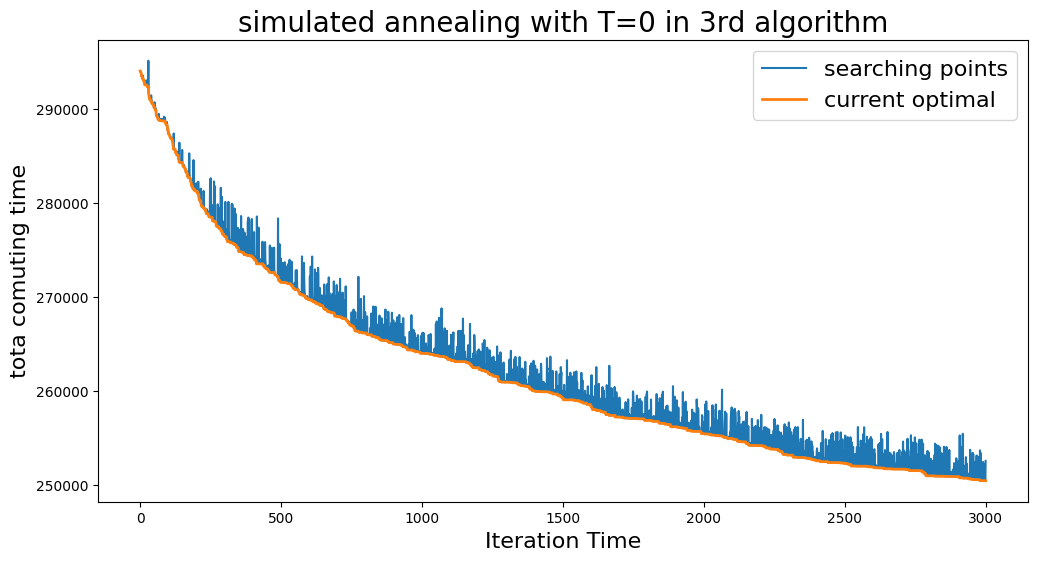

In [10]:
plt.figure(figsize=(12,6))
plt.plot(result, label='searching points')
plt.plot(temp, linewidth=2, label='current optimal')
plt.xlabel('Iteration Time', fontsize=16)
plt.ylabel('tota comuting time',fontsize=16)
plt.legend(fontsize=16)
plt.title('simulated annealing with T=0 in 3rd algorithm', fontsize=20)

In [11]:
df_schedule.to_csv('../result/df_schedule_al3_SA.csv')
pd.DataFrame(result).to_csv('../result/SA_al3_process.csv')